In [69]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
from scipy.interpolate import interp1d
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import copy

In [70]:
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Data

## Whole time domain

In [71]:
df = pd.read_excel(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\Data\PINNs\PINNs Data.xlsx")
df_training = pd.read_excel(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\Data\PINNs\PINNs Training Data.xlsx")
df_evaluation = pd.read_excel(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\Data\PINNs\PINNs Testing Data.xlsx")
df_testing = pd.read_excel(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\Data\PINNs\PINNs Validation Data.xlsx")
df_gen = pd.read_excel(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\Data\Generated Data.xlsx")  
time = df['Time']
time = np.array(time)

In [72]:
 #---- 1. Creating new training dataset  ----
df_training = df_training.iloc[::10].reset_index(drop=True)

# ---- 2. Creating new testing dataset (20% random samples from df excluding training times) ----
training_times = set(df_training['Time'])
remaining_df = df[~df['Time'].isin(training_times)].copy()

test_size = int(0.2 * len(df_training))
df_testing = remaining_df.sample(n=test_size, random_state=42).sort_values(by="Time").reset_index(drop=True)

In [73]:
df_training

Time            pim            pem       omegat     u_egr1     u_egr2  \
0    0.0  101339.735203  102371.759481  5236.000000  18.251800  18.181300   
1    2.0  154943.419002  170855.423337  6244.088187  73.118610  72.331054   
2    4.0  169303.198831  185440.207149  6769.938978  75.562774  75.811345   
3    6.0  171195.161081  183860.582642  6920.123179  65.690332  66.076126   
4    8.0  169015.579238  179721.386203  6894.029179  61.219253  61.339827   
5   10.0  167882.989930  178904.352035  6867.587259  53.128177  53.691113   
6   12.0  168734.009007  180904.802330  6957.920512  34.129517  34.807979   
7   14.0  165391.333496  172463.521542  6831.096343  28.294638  28.231296   
8   16.0  158580.871838  164513.519414  6572.777672  29.173817  29.372281   
9   18.0  165168.624088  181340.712983  6822.159185  19.949495  20.175489   
10  20.0  178714.371030  195664.061804  7235.407492  37.075317  35.687303   
11  22.0  169743.545125  177211.733010  6998.030653  70.525615  69.662528   
12  24.0  160567.082321  166123.837513  6696.627794  65.046804  65.817766   
13  26.0  160879.390759  170292.492766  6570.232761  56.939254  56.732887   
14  28.0  171706.199056  191036.771010  6805.456340  65.001156  65.029888   
15  30.0  174139.286031  188149.657390  7076.915128  38.990431  40.423237   
16  32.0  166649.132876  174422.649534  7043.802879  23.241582  22.750554   
17  34.0  166543.830746  177707.383762  6878.750586  63.002045  61.076652   
18  36.0  175181.253235  196749.042170  7008.476475  85.628845  85.691010   
19  38.0  178591.180539  196932.879036  7212.630852  69.329875  70.394385   
20  40.0  166656.937751  172081.000673  7178.806208  42.821578  43.779894   
21  42.0  154425.822967  157790.376749  6822.500190  29.169561  29.356671   
22  44.0  151807.843540  156611.236328  6689.643763  30.666103  30.519463   
23  46.0  152868.051939  158367.762237  6720.268946  31.172681  31.193184   
24  48.0  155565.425118  162832.863951  6803.945406  31.430773  31.360534   
25  50.0  163425.015499  175899.019143  7044.357572  36.128160  35.849382   
26  52.0  174487.429726  193998.567478  7358.537724  45.401830  44.981597   
27  54.0  178504.576408  195887.251515  7535.869584  51.885574  51.803602   
28  56.0  169370.536287  176788.993038  7399.382841  48.793736  49.038694   
29  58.0  158905.448117  163663.451916  7066.186467  41.626199  41.909064   
30  60.0  160663.945223  172427.997063  6982.422156  37.443453  37.488751   

        u_vgt        xr          T1       uvgt       uegr  
0   59.470000  0.020222  314.948446  30.000000  80.000000  
1   43.607178  0.027688  314.798804  43.599961  73.221548  
2   40.911849  0.028828  314.268710  40.930787  75.438679  
3   45.456258  0.028581  313.869416  45.469982  65.641614  
4   49.060488  0.028185  313.763133  49.070000  61.223592  
5   49.563037  0.028129  313.830093  49.559945  52.971172  
6   50.543910  0.028330  313.909872  50.560063  33.960079  
7   60.525291  0.027483  313.537541  60.550137  28.327750  
8   66.219289  0.026776  313.642280  66.219189  29.075838  
9   50.345851  0.028527  314.414963  50.329849  19.915839  
10  42.808954  0.029625  313.992243  42.819892  37.400698  
11  54.086378  0.027865  313.441422  54.099867  70.736599  
12  62.267145  0.026903  313.546155  62.229975  64.804697  
13  53.913373  0.027371  313.920908  53.889138  57.024790  
14  37.693500  0.029379  314.458608  37.669951  64.991964  
15  46.348822  0.028961  313.889180  46.359950  38.596313  
16  59.773089  0.027659  313.563639  59.769994  23.367304  
17  48.756771  0.028040  313.890644  48.721138  63.631187  
18  34.819578  0.029898  314.520161  34.809474  85.751699  
19  37.830185  0.029785  314.117594  37.839708  68.956775  
20  61.328377  0.027391  313.340964  61.349613  42.594098  
21  76.718685  0.026119  313.515707  76.769976  29.162489  
22  74.199641  0.026063  313.756073  74.230065  30.650841  
23  71.042754  0.026241  313.794736  71.019912  31.167388  
24  64.506401  0.026678  313.888495  64

In [74]:
data_col = df_gen.columns[0]

# Merge to extract W_egr for each subset
train_with_W = df_training.merge(df_gen[[data_col, "W_egr"]], on=data_col, how="left")
eval_with_W  = df_evaluation.merge(df_gen[[data_col, "W_egr"]], on=data_col, how="left")
test_with_W  = df_testing.merge(df_gen[[data_col, "W_egr"]], on=data_col, how="left")

# Just the W_egr column aligned with each dataset
Wegr_data_train = train_with_W["W_egr"].to_numpy()
Wegr_data_eval  = eval_with_W["W_egr"].to_numpy()
Wegr_data_test  = test_with_W["W_egr"].to_numpy()


In [75]:
pim_data = np.array(df['pim'])
pem_data = np.array(df['pem'])
omegat_data = np.array(df['omegat'])
u_egr1_data = np.array(df['u_egr1'])
u_egr2_data = np.array(df['u_egr2'])
u_vgt_data = np.array(df['u_vgt'])
xr_data = np.array(df['xr'])
uegr_data = np.array(df['uegr'])
uvgt_data = np.array(df['uvgt'])
T1_data = np.array(df['T1'])
ne_data = np.array(df_gen['n_e'])
u_delta_data = np.array(df_gen['u_delta'])
Wegr_data = np.array(df_gen['W_egr'])   

## Training Data

In [76]:
pim_data_train = np.array(df_training['pim'])
pem_data_train = np.array(df_training['pem'])
omegat_data_train = np.array(df_training['omegat'])
u_egr1_data_train = np.array(df_training['u_egr1'])
u_egr2_data_train = np.array(df_training['u_egr2'])
u_vgt_data_train = np.array(df_training['u_vgt'])
xr_data_train = np.array(df_training['xr'])
uegr_data_train = np.array(df_training['uegr'])
uvgt_data_train = np.array(df_training['uvgt'])
uegr_data_train = np.array(df_training['uegr'])
T1_data_train = np.array(df_training['T1'])

## Testing Data

In [77]:
pim_data_test = np.array(df_testing['pim'])
pem_data_test = np.array(df_testing['pem'])
omegat_data_test = np.array(df_testing['omegat'])
u_egr1_data_test = np.array(df_testing['u_egr1'])
u_egr2_data_test = np.array(df_testing['u_egr2'])
u_vgt_data_test = np.array(df_testing['u_vgt'])
xr_data_test = np.array(df_testing['xr'])
uegr_data_test = np.array(df_testing['uegr'])
uvgt_data_test = np.array(df_testing['uvgt'])
uegr_data_test = np.array(df_testing['uegr'])
T1_data_test = np.array(df_testing['T1'])

## Evaluation Data

In [78]:
pim_data_eval = np.array(df_evaluation['pim'])
pem_data_eval = np.array(df_evaluation['pem'])
omegat_data_eval = np.array(df_evaluation['omegat'])
u_egr1_data_eval = np.array(df_evaluation['u_egr1'])
u_egr2_data_eval = np.array(df_evaluation['u_egr2'])
u_vgt_data_eval = np.array(df_evaluation['u_vgt'])
xr_data_eval = np.array(df_evaluation['xr'])
uegr_data_eval = np.array(df_evaluation['uegr'])
uvgt_data_eval = np.array(df_evaluation['uvgt'])
uegr_data_eval = np.array(df_evaluation['uegr'])
T1_data_eval = np.array(df_evaluation['T1'])

## Constants

In [79]:
  #-------------   Table 7 --------------#
Ra = 287.0
Tim = 300.6186
Vim = 0.0220
Re = 286.0
Vem = 0.0200
Vd = 0.0127
ncyl = 6.0
gamma_a = 1.3964
cpa = 1011.0
cva = 724.0
rc = 17.0
xcv = 2.3371e-14
qHV = 42900000
dpipe = 0.1
lpipe = 1.0
npipe = 2.0
cpe = 1332.0
tegr1 = 0.05
tegr2 = 0.13
tdegr = 0.065
Kegr = 1.8
Πegropt = 0.6500
Jt = 2.0e-4
tvgt = 0.025
tdvgt = 0.04
cpe = 1332.0
gamma_e = 1.2734

Rt = 0.04
Rc = 0.0400
#----------   Table 9  -------------#
cvol1 = -2.0817e-4
cvol2 = -0.0034
cvol3 = 1.1497
cωψ1 = 1.0882e-8
cωψ2 = -1.7320e-4
cωψ1 = 1.0286
pcopt = 1.0455
Wcopt = 0.2753
a1 = 3.0919
a2 = 2.1479
a3 = -2.4823
eta_cmax = 0.7364
cp = 0.2708
cegr1 = -1.1104e-4
cegr2 = 0.0178
cegr3 = 0.0
cωφ1 = -1.4298e-8
cωφ2 = -0.0015

cωφ3 = 29.6462
cm1 = 1.3563
cm2 = 2.7692e3
cm3 = 0.0100
BSRopt = 0.9755
eta_tm_max = 0.8180
cψ2 = 0.0
cφ2 = 0.0
cvgt1 = 126.8719
cvgt2 = 117.1447
cf1 = 1.9480
cf2 = -0.7763
Kt = 2.8902

h_tm_max = 0.8180
#---------------True values of unknown parameters-----------------#
Aegrmax_true = 4.0e-4
eta_sc_true = 1.1015
htot_true = 96.2755
Avgtmax_true = 8.4558e-4
#---------------#
pi = np.pi
pamb = 1.0111e5
Tamb = 298.4636
#----Guesses----#
cψ1 , cφ1 = 1.0, 1.0

# Pre-Trained NNs

## $N_1^{(P)}(x; \theta_1^P) - \eta_{\mathit{vol}}$

In [80]:
class FFNN1_PT(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

torch.manual_seed(123)
FFNN1_PT = FFNN1_PT(2, 1, 10)

## $N_2^{(P)}(x; \theta_2^P) - f_{\mathit{egr}}$

In [81]:
class FFNN2(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        x = self.output_transformation(x)
        return x

torch.manual_seed(123)
FFNN2_PT = FFNN2(1, 1, 32)

## $N_3^{(P)}(x; \theta_3^P) - F_{\mathit{vgt,Π_t}}$

In [82]:
class FFNN3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        x = self.output_transformation(x)
        return x

torch.manual_seed(123)
FFNN3_PT = FFNN3(2, 1, 4)

## $N_4^{(P)}(x; \theta_4^P) - \eta_{\mathit{tm}}$

In [83]:
class FFNN4(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        return x

torch.manual_seed(123)
FFNN4_PT = FFNN4(3, 1,16 )

## $N_5^{(P)}(x; \theta_5^P) - \eta_{\mathit{c}}$

In [84]:
class FFNN5(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

torch.manual_seed(123)
FFNN5_PT = FFNN5(2, 1, 4)

## $N_6^{(P)}(x; \theta_6^P) - Φ_c$

In [85]:
class FFNN6(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_tranformation = nn.Sigmoid()
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        return self.output_tranformation(x)

torch.manual_seed(123)
FFNN6_PT = FFNN6(3, 1, 12)

## Loading pre-trained NNs

In [86]:
FFNN1_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN1_PT.pth"))
FFNN2_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN2_PT.pth"))
FFNN3_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN3_PT.pth"))
FFNN4_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN4_PT.pth"))
FFNN5_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN5_PT.pth"))
FFNN6_PT.load_state_dict(torch.load(r"C:\Users\dimka\Documents\GitHub\ML-Projects\Diesel-Engine-Model\models\Pre-Trained NNs\FFNN6_PT.pth"))

<All keys matched successfully>

# FFNNS for predicting state variables

## $\mathcal{N}_1 (\mathbf{t};\mathbf{\theta_1}) - predicting\ p_{im}, p_{em}$

In [87]:
class FFN1(nn.Module):
    def __init__(self, N_INPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Softplus()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh1 = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffnh2 = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffnh3 = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, 2)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh1(x)
        x = self.ffnh2(x)
        x = self.ffnh3(x)
        x = self.ffne(x)

        x = self.output_transformation(x) + 1  # shape: [batch_size, 2]
        return x * 1e5

## $\mathcal{N}_2 (\mathbf{t};\mathbf{\theta_2}) - predicting\ x_r$ 

In [88]:
class FFN2(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Softplus()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh1 = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffnh2 = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh1(x)
        x = self.ffnh2(x)
        x = self.ffne(x)

        x = 0.01 * self.output_transformation(x)
        
        return x

## $\mathcal{N}_3 (\mathbf{t};\mathbf{\theta_3}) - predicting\ T_1$

In [89]:
class FFN3(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Softplus()

        # Define the layers
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        x = self.output_transformation(x) + 313/300

        return  300 * x

## $\mathcal{N}_4 (\mathbf{t};\mathbf{\theta_4}) - predicting\ \tilde{u}_{egr1}, \tilde{u}_{egr2}$

In [90]:
class FFN4(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        x = self.output_transformation(x)

        return  100 * x

## $\mathcal{N}_5 (\mathbf{t};\mathbf{\theta_5}) - predicting\ \omega_t$

In [91]:
class FFN5(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Softplus()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        x = self.output_transformation(x) + 1.5

        return  1e3 * x

## $\mathcal{N}_6 (\mathbf{t};\mathbf{\theta_6}) - predicting\ \tilde{u}_{vgt}$

In [92]:
class FFN6(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation_hidden = nn.Tanh
        self.output_transformation = nn.Sigmoid()

        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation_hidden())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation_hidden())
        self.ffne = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)

        x = self.output_transformation(x)

        return  100 * x

# The Model

## Defining Time Domain

In [93]:
def scale_time (t):
    return 2 * (t/60) - 1

In [94]:
time = np.array(df['Time']).reshape(-1,1)
t_train = np.array(df_training['Time']).reshape(-1,1)
t_test = np.array(df_testing['Time']).reshape(-1,1)
t_eval = np.array(df_evaluation['Time']).reshape(-1,1)


In [95]:
# Defining the data, residual testing points and boundary
t_data = t_train
t_physics = t_data
t_boundary = 0


# Scale factor according to chain rule
scale_factor = 2.0 / (t_data.max() - t_data.min())

# Scaling time points from -1 to 1
t_data_scaled = scale_time(t_data,)
t_physics_scaled = scale_time(t_physics)
t_boundary_scaled = scale_time(t_boundary)
t_test_scaled = scale_time(t_test)
t_eval_scaled = scale_time(t_eval)

# Converting the above to tensors
t_data_tensor = torch.tensor(t_data, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_physics_tensor = torch.tensor(t_physics, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_boundary_tensor = torch.tensor(t_boundary, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_test_tensor = torch.tensor(t_test, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_eval_tensor = torch.tensor(t_eval, dtype = torch.float32).view(-1,1).requires_grad_(True)

t_data_scaled_tensor = torch.tensor(t_data_scaled, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_physics_scaled_tensor = torch.tensor(t_physics_scaled, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_boundary_scaled_tensor = torch.tensor(t_boundary_scaled, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_test_scaled_tensor = torch.tensor(t_test_scaled, dtype = torch.float32).view(-1,1).requires_grad_(True)
t_eval_scaled_tensor = torch.tensor(t_eval_scaled, dtype = torch.float32).view(-1,1).requires_grad_(True)

## Normalizer

In [96]:
def normalize_tensor_0_1(tensor):
    """
    Normalizes a PyTorch tensor to the range [0, 1].

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Normalized tensor.
    """
    min_val = tensor.min()
    max_val = tensor.max()
    return (tensor - min_val) / (max_val - min_val + 1e-8)  # +epsilon to avoid division by zero

def normalize_tensor(tensor, min, max):
    """
    Normalizes a PyTorch tensor to the range [0, 1].

    Args:
        tensor (torch.Tensor): Input tensor.

    Returns:
        torch.Tensor: Normalized tensor.
    """
    min_val = min
    max_val = max
    return (tensor - min_val) / (max_val - min_val + 1e-8)  # +epsilon to avoid division by zero

## Training Process

First of all , we will train the pinns that are respinsible for predicting the dynamics of variables which are independent from the approximation of the other equations. These variables are $\tilde{u}_{egr1}, \tilde{u}_{egr2}, \tilde{u}_{vgt}$. So, at first we train PINN4 and PINN6 and then we use the predicted dynamics for the training of the rest networks.


#### Derivative function

In [97]:
# --------------------------------
#  Helper for Automatic Diff
# --------------------------------
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

### $PINN6 - u_{vgt}$

#### Initial Condition

In [98]:
#Converting to tensors
uvgt_data_train_tensor = torch.tensor(uvgt_data_train, dtype = torch.float32).view(-1,1).requires_grad_(True)
u_vgt_data_train_tensor = torch.tensor(u_vgt_data_train, dtype = torch.float32).view(-1,1).requires_grad_(True)

uvgt_data_test_tensor = torch.tensor(uvgt_data_test, dtype = torch.float32).view(-1,1).requires_grad_(True)
u_vgt_data_test_tensor = torch.tensor(u_vgt_data_test, dtype = torch.float32).view(-1,1).requires_grad_(True)

#Initial condition for u_vgt (t=0)
print(f"u_vgt[0] = {u_vgt_data[0]}")

u_vgt[0] = 59.47


In [99]:
len(uvgt_data_train_tensor)

31

#### Training

Epoch 00000 | Train Loss: 1.24e+00 | Test Loss: 1.38e+02 | IC: 1.51e+01 | Eq: 2.46e+05 | NoImprove: 0


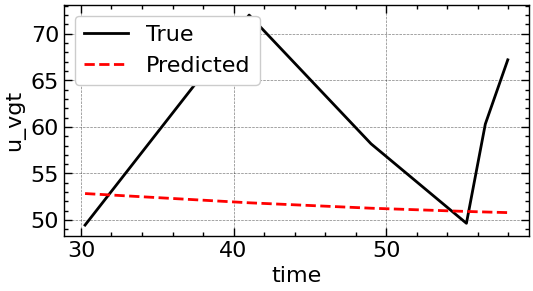

Epoch 01000 | Train Loss: 1.07e+00 | Test Loss: 8.12e+01 | IC: 1.11e+02 | Eq: 1.99e+05 | NoImprove: 1


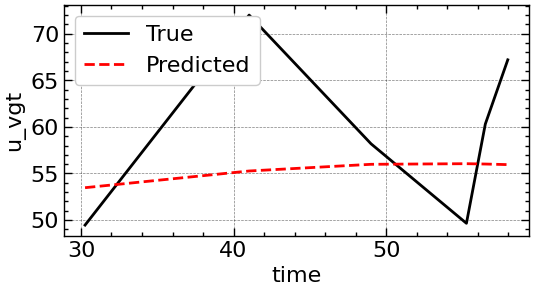

Epoch 02000 | Train Loss: 5.26e-01 | Test Loss: 3.71e+01 | IC: 1.32e+02 | Eq: 8.76e+04 | NoImprove: 0


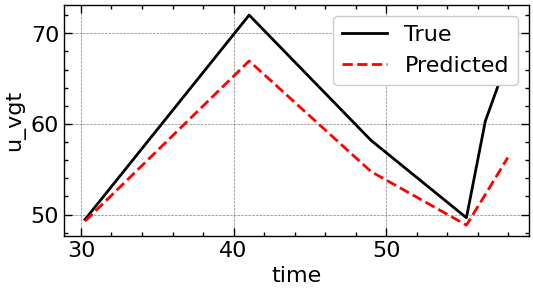

Epoch 03000 | Train Loss: 3.89e-01 | Test Loss: 3.84e+00 | IC: 1.34e+02 | Eq: 5.99e+04 | NoImprove: 1


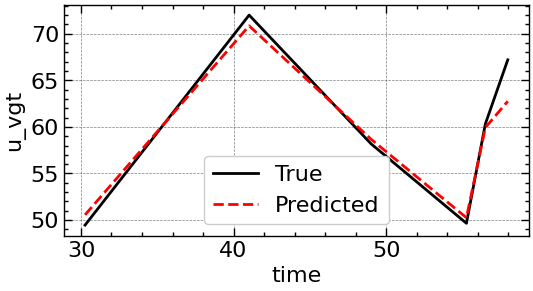

Epoch 04000 | Train Loss: 2.47e-01 | Test Loss: 1.13e+00 | IC: 7.75e+01 | Eq: 3.91e+04 | NoImprove: 16


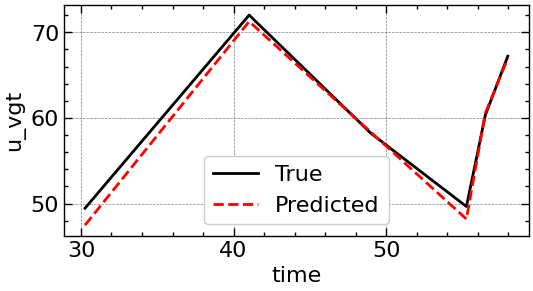

Epoch 05000 | Train Loss: 1.68e-01 | Test Loss: 5.21e-01 | IC: 7.57e+01 | Eq: 2.36e+04 | NoImprove: 732


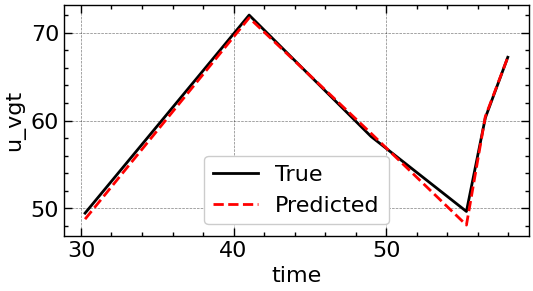

Epoch 06000 | Train Loss: 1.60e-01 | Test Loss: 5.92e-01 | IC: 6.70e+01 | Eq: 2.32e+04 | NoImprove: 10


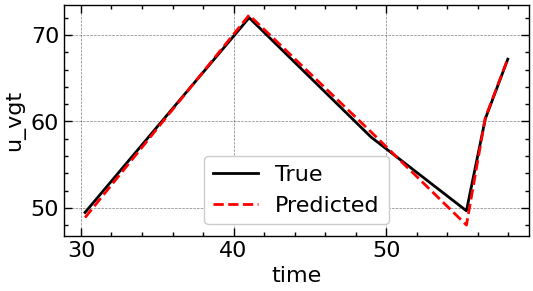

Epoch 07000 | Train Loss: 1.60e-01 | Test Loss: 6.52e-01 | IC: 6.54e+01 | Eq: 2.33e+04 | NoImprove: 333


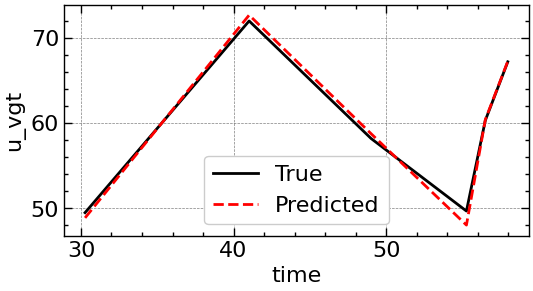

Epoch 08000 | Train Loss: 1.60e-01 | Test Loss: 6.62e-01 | IC: 6.52e+01 | Eq: 2.34e+04 | NoImprove: 1333


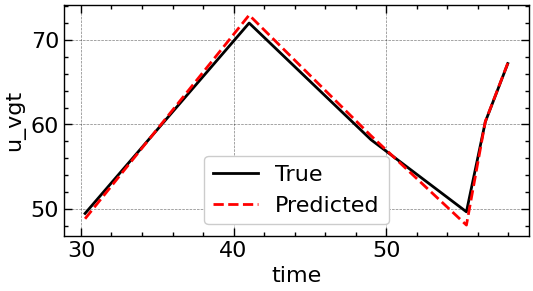

Epoch 09000 | Train Loss: 1.60e-01 | Test Loss: 6.85e-01 | IC: 6.51e+01 | Eq: 2.34e+04 | NoImprove: 48


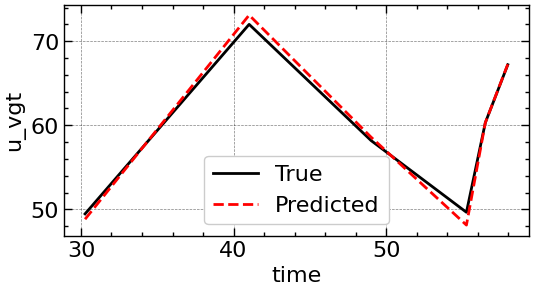

Epoch 10000 | Train Loss: 1.60e-01 | Test Loss: 7.05e-01 | IC: 6.53e+01 | Eq: 2.33e+04 | NoImprove: 1048


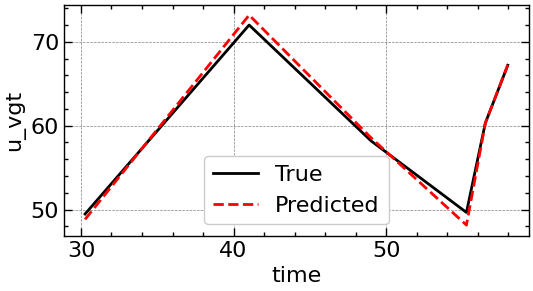

Epoch 11000 | Train Loss: 1.60e-01 | Test Loss: 7.12e-01 | IC: 6.51e+01 | Eq: 2.34e+04 | NoImprove: 2048


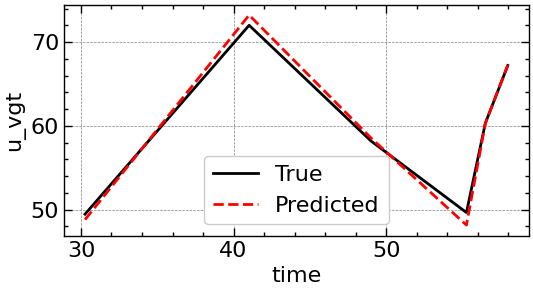

Epoch 12000 | Train Loss: 1.60e-01 | Test Loss: 7.14e-01 | IC: 6.54e+01 | Eq: 2.33e+04 | NoImprove: 3048


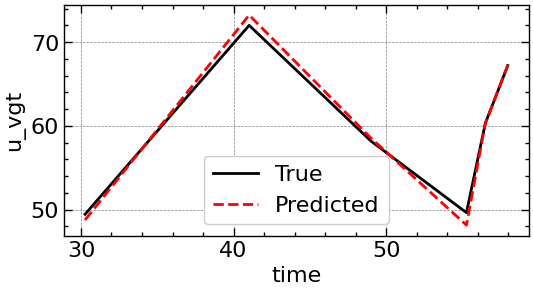

Epoch 13000 | Train Loss: 1.60e-01 | Test Loss: 7.19e-01 | IC: 6.51e+01 | Eq: 2.34e+04 | NoImprove: 4048


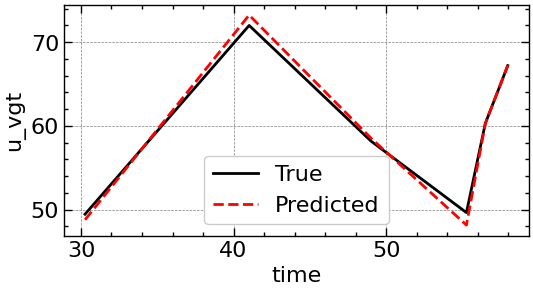

Epoch 14000 | Train Loss: 1.60e-01 | Test Loss: 7.23e-01 | IC: 6.51e+01 | Eq: 2.34e+04 | NoImprove: 5048


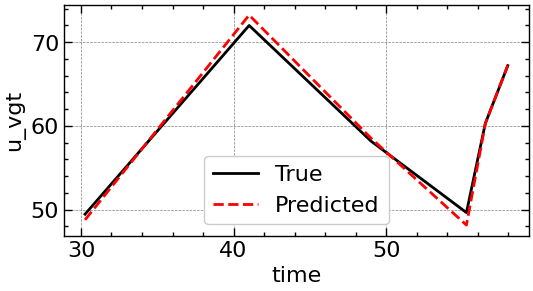

Epoch 15000 | Train Loss: 1.60e-01 | Test Loss: 7.25e-01 | IC: 6.53e+01 | Eq: 2.33e+04 | NoImprove: 6048


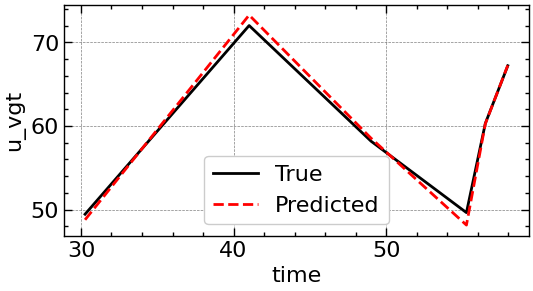

Epoch 16000 | Train Loss: 1.60e-01 | Test Loss: 7.26e-01 | IC: 6.49e+01 | Eq: 2.34e+04 | NoImprove: 7048


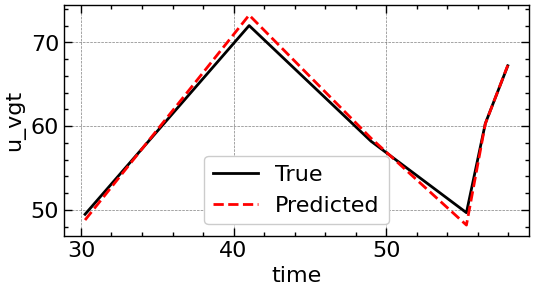

Epoch 17000 | Train Loss: 1.60e-01 | Test Loss: 7.30e-01 | IC: 6.50e+01 | Eq: 2.34e+04 | NoImprove: 502


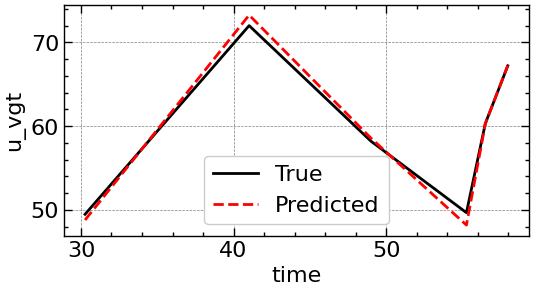

Epoch 18000 | Train Loss: 1.60e-01 | Test Loss: 7.34e-01 | IC: 6.50e+01 | Eq: 2.34e+04 | NoImprove: 1502


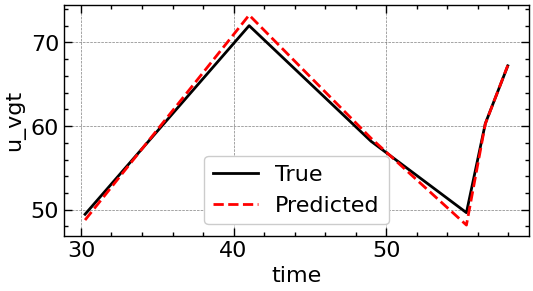

Epoch 19000 | Train Loss: 1.60e-01 | Test Loss: 7.37e-01 | IC: 6.50e+01 | Eq: 2.34e+04 | NoImprove: 2502


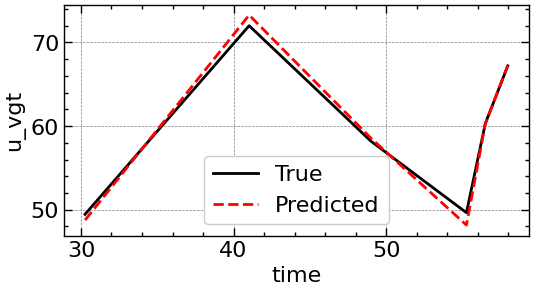

Epoch 20000 | Train Loss: 1.60e-01 | Test Loss: 7.35e-01 | IC: 6.35e+01 | Eq: 2.36e+04 | NoImprove: 3502


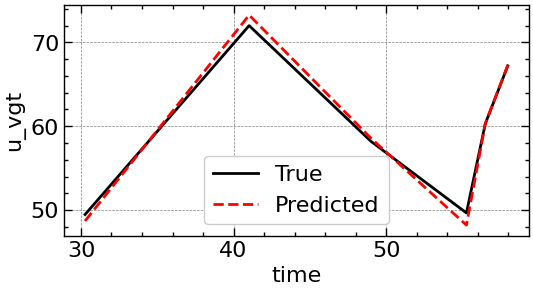

Epoch 21000 | Train Loss: 1.60e-01 | Test Loss: 7.43e-01 | IC: 6.35e+01 | Eq: 2.36e+04 | NoImprove: 4502


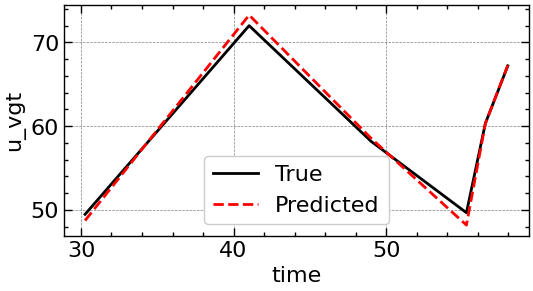

Epoch 22000 | Train Loss: 1.60e-01 | Test Loss: 7.47e-01 | IC: 6.50e+01 | Eq: 2.34e+04 | NoImprove: 5502


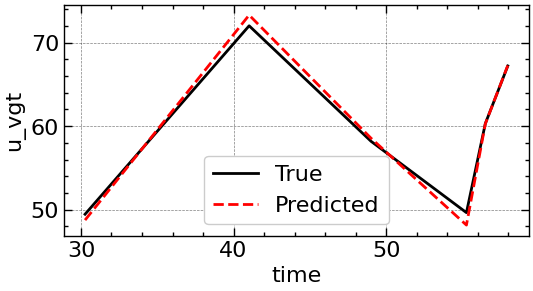

Epoch 23000 | Train Loss: 1.60e-01 | Test Loss: 7.60e-01 | IC: 6.65e+01 | Eq: 2.32e+04 | NoImprove: 6502


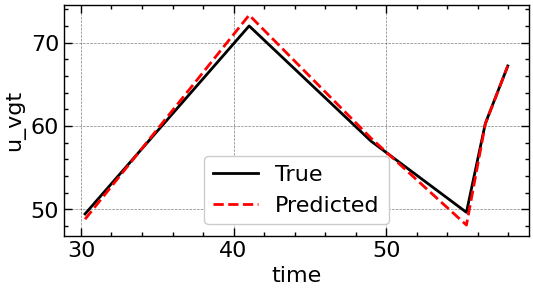

Epoch 24000 | Train Loss: 1.60e-01 | Test Loss: 7.55e-01 | IC: 6.49e+01 | Eq: 2.34e+04 | NoImprove: 7502


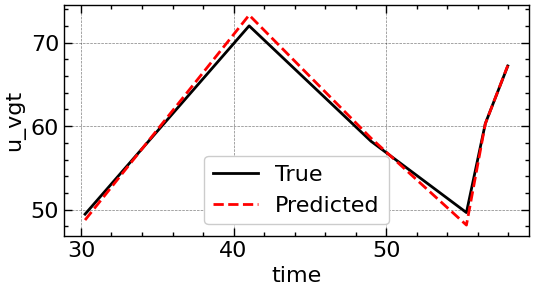

Epoch 25000 | Train Loss: 1.60e-01 | Test Loss: 7.58e-01 | IC: 6.50e+01 | Eq: 2.34e+04 | NoImprove: 8502


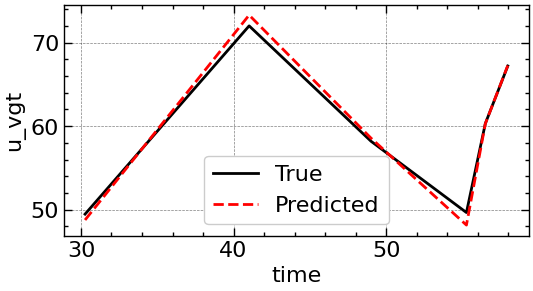

Epoch 26000 | Train Loss: 1.60e-01 | Test Loss: 7.62e-01 | IC: 6.49e+01 | Eq: 2.34e+04 | NoImprove: 9502


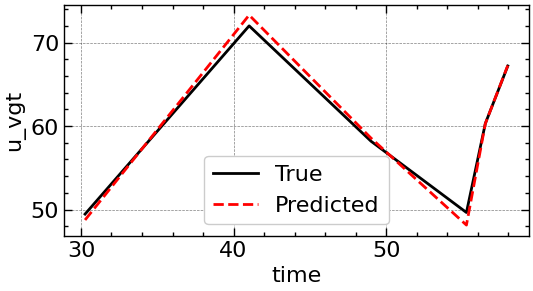


Early stopping at epoch 26498 | Best epoch: 16498 | Best test loss: 7.5075e-01
Best model saved from epoch 16498 with test loss 7.5075e-01


In [100]:
# Model & optimizer
pinn6 = FFN6(1, 1, 64)
optimiser_pinn6 = optim.Adam(pinn6.parameters(), lr=0.0001)

# Loss histories
Train_loss_history_PINN6 = []
IC_loss_history_PINN6 = []
Eq_loss_history_PINN6 = []
Test_loss_history_PINN6 = []

# Early stopping setup
patience = 10000         # stop if no improvement for 10k epochs
min_delta = 0.5e-1         # minimum improvement to reset patience
best_test_loss = float('inf')
best_epoch = -1
best_model_state = None
no_improve_counter = 0

# Training loop
for epoch in range(50000):
    pinn6.train()
    optimiser_pinn6.zero_grad()

    lambda_ic_PINN6, lambda_eq_N6 = (1 / 1.5) * 1e-3, 0.5e-5

    # --- Initial condition loss ---
    u_vgt_pred_ic = pinn6(t_boundary_scaled_tensor)
    IC_loss_PINN6 = torch.mean((torch.squeeze(u_vgt_pred_ic) - u_vgt_data[0]) ** 2)

    # --- Physics (equation) loss ---
    u_vgt_pred_eq = pinn6(t_physics_scaled_tensor)
    du_vgt_preddt = derivative(u_vgt_pred_eq, t_physics_scaled_tensor) * scale_factor
    Eq_loss_PINN6 = torch.mean(
        (du_vgt_preddt - ((1 / tvgt) * (uvgt_data_train_tensor - u_vgt_pred_eq))) ** 2
    )

    # --- Total loss ---
    loss_PINN6 = lambda_ic_PINN6 * IC_loss_PINN6 + lambda_eq_N6 * Eq_loss_PINN6

    # --- Store training losses ---
    Train_loss_history_PINN6.append(loss_PINN6.item())
    IC_loss_history_PINN6.append(IC_loss_PINN6.item())
    Eq_loss_history_PINN6.append(Eq_loss_PINN6.item())

    # --- Backprop ---
    loss_PINN6.backward()
    optimiser_pinn6.step()

    # --- Test loss ---
    pinn6.eval()
    with torch.no_grad():
        u_vgt_pred_test = pinn6(t_test_scaled_tensor).view(-1, 1)
        test_loss = torch.mean((u_vgt_pred_test - u_vgt_data_test_tensor) ** 2).item()
        Test_loss_history_PINN6.append(test_loss)

    # --- Early stopping check ---
    if abs(test_loss - best_test_loss) > min_delta:
        # Significant improvement
        best_test_loss = test_loss
        best_epoch = epoch
        best_model_state = copy.deepcopy(pinn6.state_dict())
        no_improve_counter = 0
    else:
        # No significant improvement
        no_improve_counter += 1

    if no_improve_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch} "
              f"| Best epoch: {best_epoch} "
              f"| Best test loss: {best_test_loss:.4e}")
        break

    # --- Printing every 1000 epochs ---
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:05d} | "
              f"Train Loss: {loss_PINN6.item():.2e} | "
              f"Test Loss: {test_loss:.2e} | "
              f"IC: {IC_loss_PINN6.item():.2e} | "
              f"Eq: {Eq_loss_PINN6.item():.2e} | "
              f"NoImprove: {no_improve_counter}")

        # Optional: plot predictions
        plt.figure(figsize=(6, 3))
        plt.plot(t_test, u_vgt_data_test, label="True", color="black")
        plt.plot(t_test, u_vgt_pred_test.detach().numpy(),
                 label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.xlabel("time")
        plt.ylabel("u_vgt")
        plt.show()

# Save the best model weights
torch.save(best_model_state, "best_pinn6_model.pth")
print(f"Best model saved from epoch {best_epoch} with test loss {best_test_loss:.4e}")



#### Train vs Test Loss

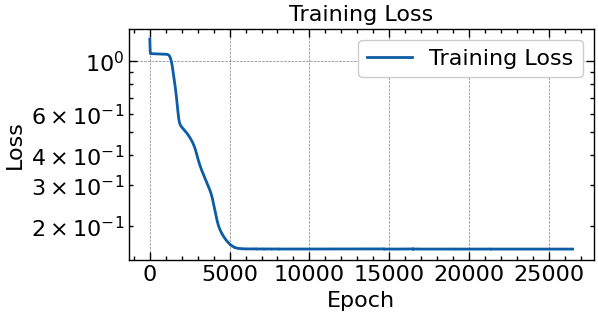

In [101]:
# Plotting the loss history
plt.figure(figsize=(6, 3))
plt.yscale("log")
plt.plot(Train_loss_history_PINN6, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

#### Evaluation

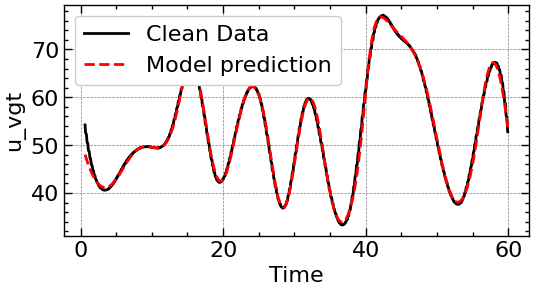

In [102]:
pinn6.eval()
with torch.no_grad():
    u_vgt_pred_eval = pinn6(t_eval_scaled_tensor).view(-1,1)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 3))
plt.plot(t_eval, u_vgt_data_eval, color = 'black', label = 'Clean Data')
plt.plot(t_eval, u_vgt_pred_eval.detach().numpy(), color = 'red', label='Model prediction', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('u_vgt')
plt.legend()
plt.show()

### $PINN4 - \tilde{u}_{egr1}, \tilde{u}_{egr2}$

#### Initial Conditions

In [103]:
# Converting to tensors
uegr_data_train_tensor = torch.tensor(uegr_data_train, dtype = torch.float32).view(-1,1)
u_egr1_data_train_tensor = torch.tensor(u_egr1_data_train, dtype = torch.float32).view(-1,1)
u_egr2_data_train_tensor = torch.tensor(u_egr2_data_train, dtype = torch.float32).view(-1,1)

uegr_data_test_tensor = torch.tensor(uegr_data_test, dtype = torch.float32).view(-1,1)
u_egr1_data_test_tensor = torch.tensor(u_egr1_data_test, dtype = torch.float32).view(-1,1)
u_egr2_data_test_tensor = torch.tensor(u_egr2_data_test, dtype = torch.float32).view(-1,1)

#Initial conditions for u_egr1, u_egr2
print(f"u_egr1[0] = {u_egr1_data[0]}")
print(f"u_egr2[0] = {u_egr2_data[0]}")

u_egr1[0] = 18.2518
u_egr2[0] = 18.1813


#### Model for $\tilde{u}_{egr1} ,\tilde{u}_{egr1}$

Epoch 00000 | Train Loss: 1.10e+02 | Test Loss: 3.27e+02 | IC: 2.18e+03 | Eq: 1.54e+05


<Figure size 1000x400 with 0 Axes>

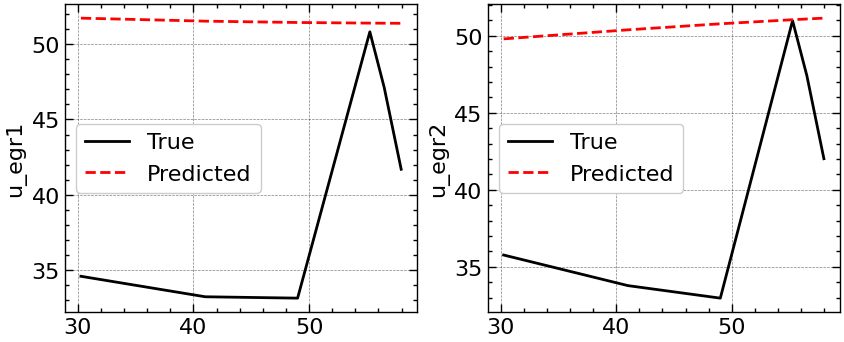

Epoch 01000 | Train Loss: 1.83e+00 | Test Loss: 2.03e+02 | IC: 2.30e-01 | Eq: 2.73e+05


<Figure size 1000x400 with 0 Axes>

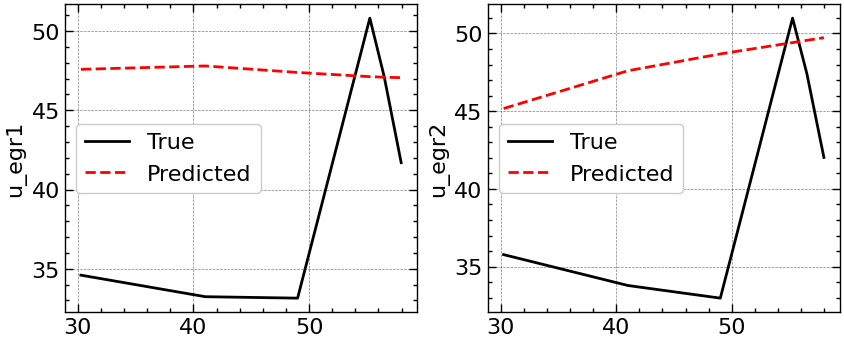

Epoch 02000 | Train Loss: 1.26e+00 | Test Loss: 1.52e+02 | IC: 3.11e-03 | Eq: 1.88e+05


<Figure size 1000x400 with 0 Axes>

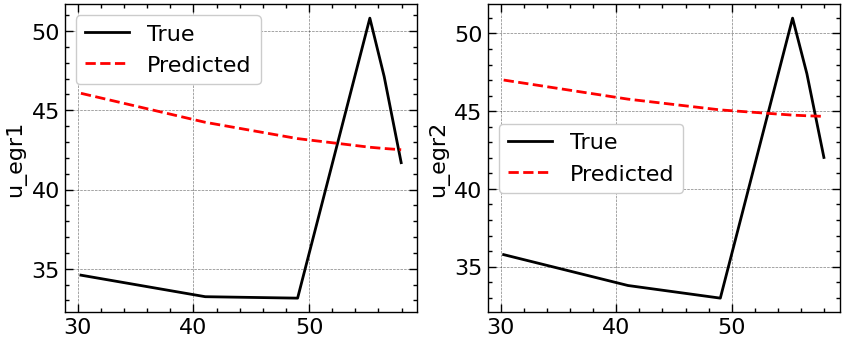

Epoch 03000 | Train Loss: 9.25e-01 | Test Loss: 2.53e+02 | IC: 1.37e-02 | Eq: 1.39e+05


<Figure size 1000x400 with 0 Axes>

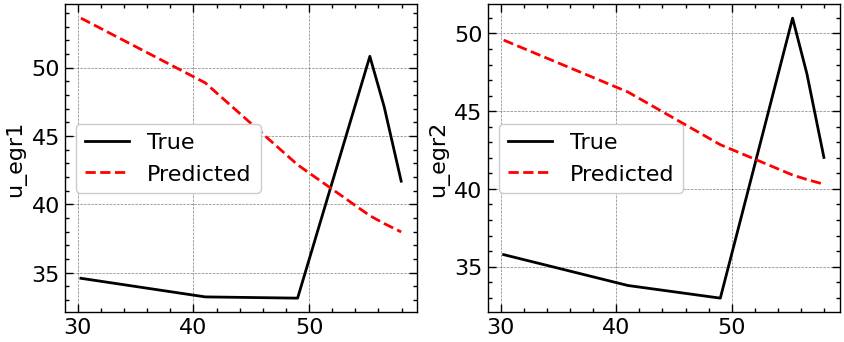

Epoch 04000 | Train Loss: 8.39e-01 | Test Loss: 2.71e+02 | IC: 1.35e-02 | Eq: 1.26e+05


<Figure size 1000x400 with 0 Axes>

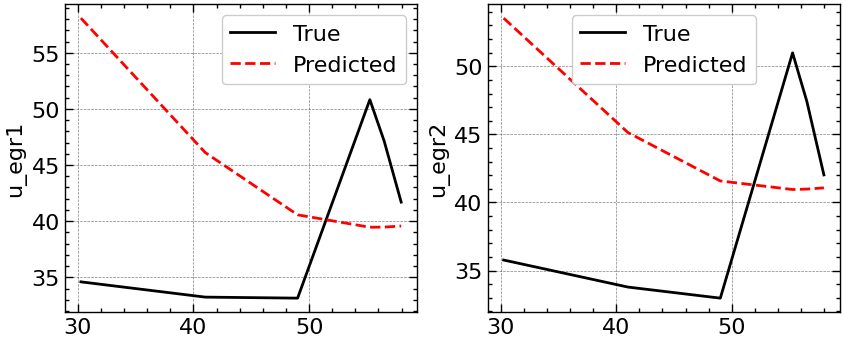

Epoch 05000 | Train Loss: 8.15e-01 | Test Loss: 2.71e+02 | IC: 1.74e-02 | Eq: 1.22e+05


<Figure size 1000x400 with 0 Axes>

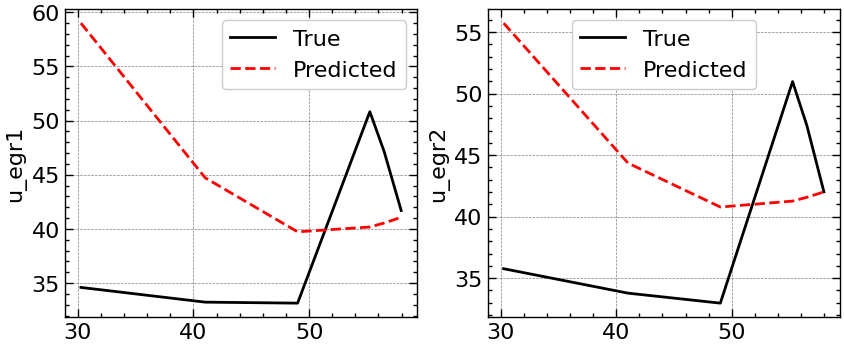

Epoch 06000 | Train Loss: 7.98e-01 | Test Loss: 2.75e+02 | IC: 4.58e-03 | Eq: 1.20e+05


<Figure size 1000x400 with 0 Axes>

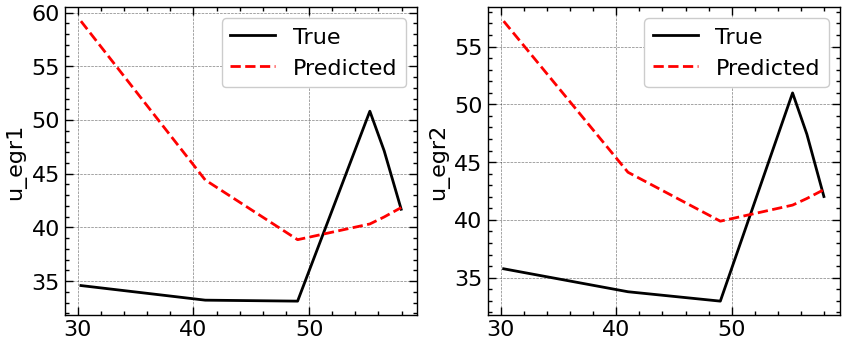

Epoch 07000 | Train Loss: 7.75e-01 | Test Loss: 2.74e+02 | IC: 1.30e-02 | Eq: 1.16e+05


<Figure size 1000x400 with 0 Axes>

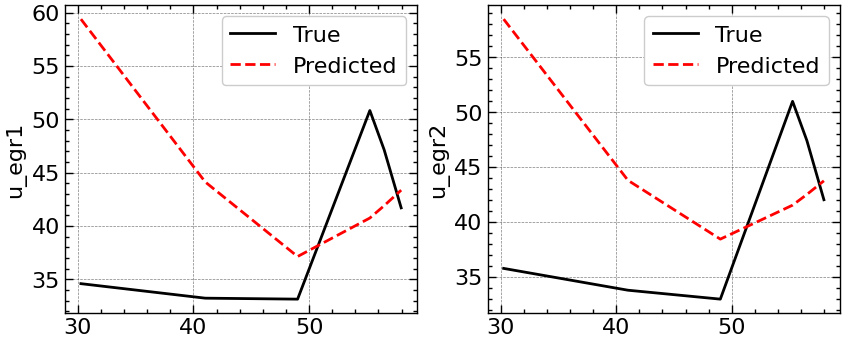

Epoch 08000 | Train Loss: 7.34e-01 | Test Loss: 2.66e+02 | IC: 1.22e-02 | Eq: 1.10e+05


<Figure size 1000x400 with 0 Axes>

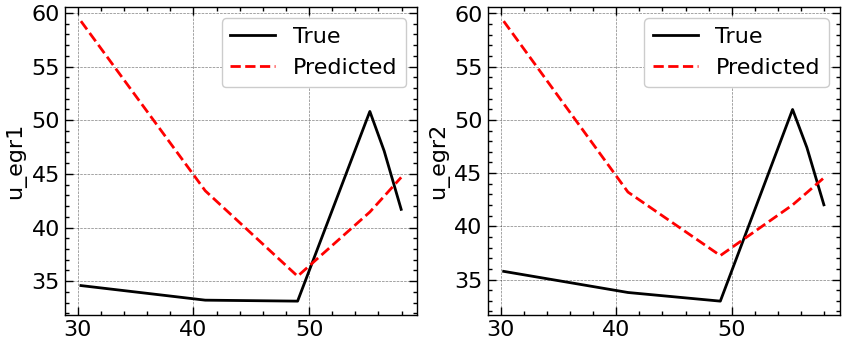

Epoch 09000 | Train Loss: 6.71e-01 | Test Loss: 2.37e+02 | IC: 1.20e-02 | Eq: 1.01e+05


<Figure size 1000x400 with 0 Axes>

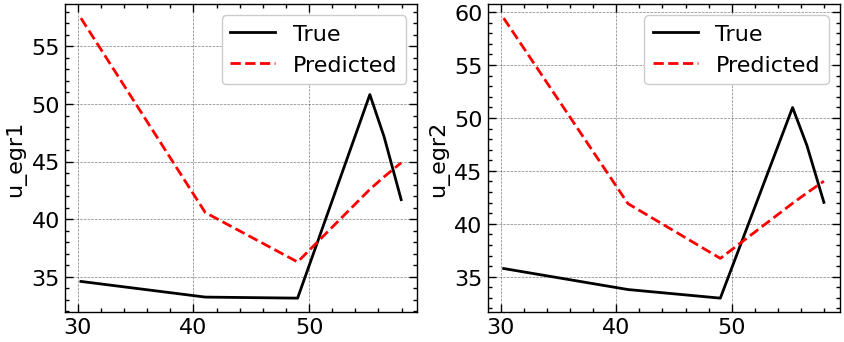

Epoch 10000 | Train Loss: 6.02e-01 | Test Loss: 1.80e+02 | IC: 1.07e-02 | Eq: 9.02e+04


<Figure size 1000x400 with 0 Axes>

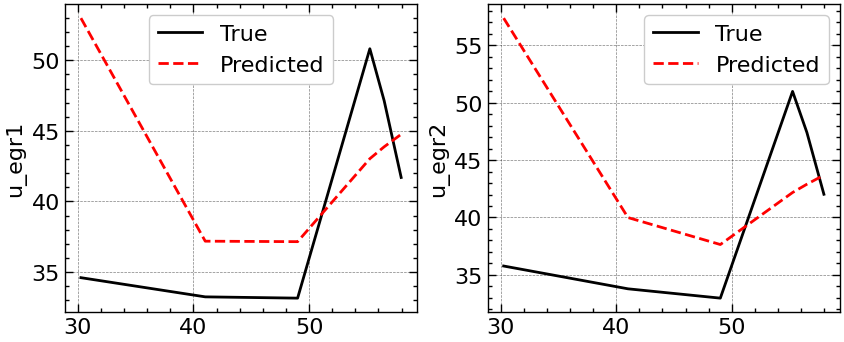


Early stopping at epoch 10026 | Best epoch: 26 | Best test loss: 5.5725e+01
Model from the last epoch saved as 'pinn4_clean.pth'


In [104]:
# Model & optimizer
pinn4 = FFN4(1, 2, 64)
optimiser_pinn4 = optim.Adam(pinn4.parameters(), lr=0.0005)

# Loss histories
Total_loss_history_PINN4 = []
IC_loss_history_PINN4 = []
Eq_loss_history_PINN4 = []
Test_loss_history_PINN4 = []

# Early stopping setup
patience = 10000
best_test_loss = float('inf')
best_epoch = -1
best_model_state = None
no_improve_counter = 0
early_stop_delta = 1e-1  # stop if no improvement greater than this for patience epochs

for epoch in range(50000):
    pinn4.train()
    optimiser_pinn4.zero_grad()

    lambda_ic_pinn4, lambda_eq_pinn4 = 0.5 * 1e-1, (1/1.5) * 1e-5

    # --- Initial conditions ---
    u = pinn4(t_boundary_scaled_tensor)
    u_egr1_pred = u[:, 0].view(-1, 1)
    u_egr2_pred = u[:, 1].view(-1, 1)

    IC_loss_PINN4_u_egr1 = torch.mean((torch.squeeze(u_egr1_pred) - df['u_egr1'][0]) ** 2)
    IC_loss_PINN4_u_egr2 = torch.mean((torch.squeeze(u_egr2_pred) - df['u_egr2'][0]) ** 2)
    IC_loss_total_PINN4 = IC_loss_PINN4_u_egr1 + IC_loss_PINN4_u_egr2

    # --- Physics loss ---
    u = pinn4(t_physics_scaled_tensor)
    u_egr1_pred = u[:, 0].view(-1, 1)
    u_egr2_pred = u[:, 1].view(-1, 1)

    du_egr1_preddt = derivative(u_egr1_pred, t_physics_scaled_tensor) * scale_factor
    du_egr2_preddt = derivative(u_egr2_pred, t_physics_scaled_tensor) * scale_factor

    Eq_loss_PINN4_u_egr1 = torch.mean((du_egr1_preddt - ((1 / tegr1) * (uegr_data_train_tensor - u_egr1_pred))) ** 2)
    Eq_loss_PINN4_u_egr2 = torch.mean((du_egr2_preddt - ((1 / tegr2) * (uegr_data_train_tensor - u_egr2_pred))) ** 2)
    Eq_loss_total_PINN4 = Eq_loss_PINN4_u_egr1 + Eq_loss_PINN4_u_egr2

    # --- Total loss ---
    loss_PINN4 = lambda_ic_pinn4 * IC_loss_total_PINN4 + lambda_eq_pinn4 * Eq_loss_total_PINN4

    # Store training losses
    Total_loss_history_PINN4.append(loss_PINN4.item())
    IC_loss_history_PINN4.append(IC_loss_total_PINN4.item())
    Eq_loss_history_PINN4.append(Eq_loss_total_PINN4.item())

    # Backpropagation
    loss_PINN4.backward()
    optimiser_pinn4.step()

    # Evaluate test loss
    pinn4.eval()
    with torch.no_grad():
        u_egr_pred_test = pinn4(t_test_scaled_tensor)
        u_egr1_pred_test = u_egr_pred_test[:, 0].view(-1, 1)
        u_egr2_pred_test = u_egr_pred_test[:, 1].view(-1, 1)

        test_loss_u_egr1 = torch.mean((u_egr1_pred_test - u_egr1_data_test_tensor) ** 2).item()
        test_loss_u_egr2 = torch.mean((u_egr2_pred_test - u_egr2_data_test_tensor) ** 2).item()
        test_loss = test_loss_u_egr1 + test_loss_u_egr2

        Test_loss_history_PINN4.append(test_loss)

    # Early stopping check
    if test_loss < best_test_loss - early_stop_delta:
        best_test_loss = test_loss
        best_epoch = epoch
        best_model_state = copy.deepcopy(pinn4.state_dict())
        no_improve_counter = 0
    else:
        no_improve_counter += 1

    if no_improve_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch} | Best epoch: {best_epoch} | Best test loss: {best_test_loss:.4e}")
        break

    # Print progress every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:05d} | "
              f"Train Loss: {loss_PINN4.item():.2e} | "
              f"Test Loss: {test_loss:.2e} | "
              f"IC: {IC_loss_total_PINN4.item():.2e} | "
              f"Eq: {Eq_loss_total_PINN4.item():.2e}")

        # Plot predictions
        plt.figure(figsize=(10, 4))
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        axs[0].plot(t_test, u_egr1_data_test, label="True", color="black")
        axs[0].plot(t_test, u_egr1_pred_test.detach().numpy(), label="Predicted", color="red", linestyle="--")
        axs[0].set_ylabel("u_egr1")
        axs[0].legend()

        axs[1].plot(t_test, u_egr2_data_test, label="True", color="black")
        axs[1].plot(t_test, u_egr2_pred_test.detach().numpy(), label="Predicted", color="red", linestyle="--")
        axs[1].set_ylabel("u_egr2")
        axs[1].legend()

        plt.show()

# Save the last epoch model weights too
torch.save(pinn4.state_dict(), "pinn4_clean.pth")
print("Model from the last epoch saved as 'pinn4_clean.pth'")

#### Loss

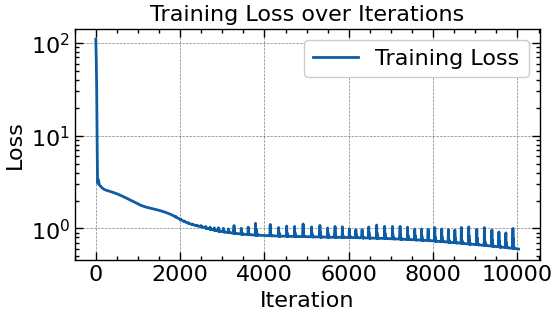

In [105]:
# Plotting the loss history
plt.figure(figsize=(6, 3))
plt.yscale("log")
plt.plot(Total_loss_history_PINN4, label="Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over Iterations")
plt.legend()
plt.show()

<Figure size 1000x400 with 0 Axes>

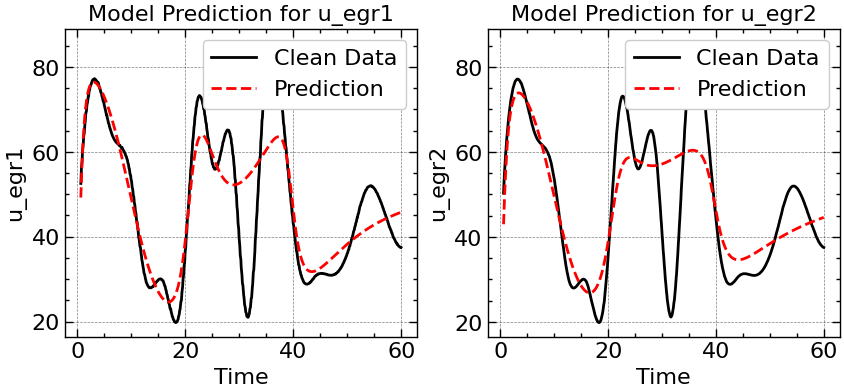

In [106]:
pinn4.eval()

# Assume t_eval is your evaluation tensor (scaled as needed)
with torch.no_grad():
    u_pred = pinn4(t_eval_scaled_tensor)  # shape: [N, 2]
    u_egr1_pred = u_pred[:, 0].numpy()
    u_egr2_pred = u_pred[:, 1].numpy()

# Plot predictions
plt.figure(figsize=(10, 4))
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(t_eval, u_egr1_data_eval, label="Clean Data", color="black")
axs[0].plot(t_eval, u_egr1_pred, label="Prediction", color="red", linestyle="--")
axs[0].set_title("Model Prediction for u_egr1")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("u_egr1")
axs[0].legend()

axs[1].plot(t_eval, u_egr2_data_eval, label="Clean Data", color="black")
axs[1].plot(t_eval, u_egr2_pred, label="Prediction", color="red", linestyle="--")
axs[1].set_title("Model Prediction for u_egr2")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("u_egr2")
axs[1].legend()

plt.show()

### The variables $p_{im}$, $p_{em}$, $ω_{t}$, $x_{r}$ and $T_{1}$ are included in a system of coupled ODEs so the $PINNs$ responsible for the prediction of these variables have to be trained together.After having trained $PINN4$ and $PINN6$ we can use the predicted variables $\tilde{u}_{egr1}, \tilde{u}_{egr2}, \tilde{u}_{vgt}$ for the training of the forementioned variables

#### Training and testing Data for $\tilde{u}_{egr1}, \tilde{u}_{egr2}, \tilde{u}_{vgt}, \tilde{u}_{egr}$

In [107]:
## Predicted values for the variables u_egr1, u_egr2, u_vgt, u_egr

# data points
u_egr1_pred_data = pinn4(t_data_scaled_tensor)[:,0].view(-1,1)
u_egr1_pred_data = u_egr1_pred_data.detach()

u_egr2_pred_data = pinn4(t_data_scaled_tensor)[:,1].view(-1,1)
u_egr2_pred_data = u_egr2_pred_data.detach()

u_vgt_pred_data = pinn6(t_data_scaled_tensor).view(-1,1)
u_vgt_pred_data = u_vgt_pred_data.detach()

u_egr_pred_data = Kegr * u_egr1_pred_data - (Kegr - 1) * u_egr2_pred_data

# residual points
u_egr1_pred_physics = pinn4(t_physics_scaled_tensor)[:,0].view(-1,1)
u_egr1_pred_physics = u_egr1_pred_physics.detach()

u_egr2_pred_physics = pinn4(t_physics_scaled_tensor)[:,1].view(-1,1)
u_egr2_pred_physics = u_egr2_pred_physics.detach()

u_vgt_pred_physics = pinn6(t_physics_scaled_tensor).view(-1,1)
u_vgt_pred_physics = u_vgt_pred_physics.detach()

u_egr_pred_physics = Kegr * u_egr1_pred_physics - (Kegr - 1) * u_egr2_pred_physics

# boundary
u_egr1_pred_boundary = pinn4(t_boundary_scaled_tensor)[:,0].view(-1,1)
u_egr1_pred_boundary = u_egr1_pred_boundary.detach()

u_egr2_pred_boundary = pinn4(t_boundary_scaled_tensor)[:,1].view(-1,1)
u_egr2_pred_boundary = u_egr2_pred_boundary.detach()

u_vgt_pred_boundary = pinn6(t_boundary_scaled_tensor).view(-1,1)
u_vgt_pred_boundary = u_vgt_pred_boundary.detach()

u_egr_pred_boundary = Kegr * u_egr1_pred_boundary - (Kegr - 1) * u_egr2_pred_boundary

# Test
u_egr1_pred_test = pinn4(t_test_scaled_tensor)[:,0].view(-1,1)
u_egr1_pred_test = u_egr1_pred_test.detach()

u_egr2_pred_test = pinn4(t_test_scaled_tensor)[:,1].view(-1,1)
u_egr2_pred_test = u_egr2_pred_test.detach()

u_vgt_pred_test = pinn6(t_test_scaled_tensor).view(-1,1)
u_vgt_pred_test = u_vgt_pred_test.detach()

u_egr_pred_test = Kegr * u_egr1_pred_test - (Kegr - 1) * u_egr2_pred_test

In [108]:
### Normalizing the predicted variables u_egr1, u_egr2, u_vgt in data and residual points

# u_egr1
u_egr1_pred_data_norm = (1/100) * (u_egr1_pred_data)
u_egr1_pred_physics_norm = (1/100) * (u_egr1_pred_physics)
u_egr1_pred_boundary_norm = (1/100) * (u_egr1_pred_boundary)
u_egr1_pred_test_norm = (1/100) * (u_egr1_pred_test)


# u_egr2
u_egr2_pred_data_norm = (1/100) * (u_egr2_pred_data)
u_egr2_pred_physics_norm = (1/100) * (u_egr2_pred_physics)
u_egr2_pred_boundary_norm = (1/100) * (u_egr2_pred_boundary)
u_egr2_pred_test_norm = (1/100) * (u_egr2_pred_test)

# u_vgt
u_vgt_pred_data_norm = (1/100) * (u_vgt_pred_data)
u_vgt_pred_physics_norm = (1/100) * (u_vgt_pred_physics)
u_vgt_pred_boundary_norm = (1/100) * (u_vgt_pred_boundary)
u_vgt_pred_test_norm = (1/100) * (u_vgt_pred_test)

In [109]:
u_egr1_data_train = df_training['u_egr1'].values.reshape(-1, 1)
u_egr2_data_train = df_training['u_egr2'].values.reshape(-1, 1)
u_vgt_data_train = df_training['u_vgt'].values.reshape(-1, 1)

In [110]:
len(u_egr1_data_train)

31

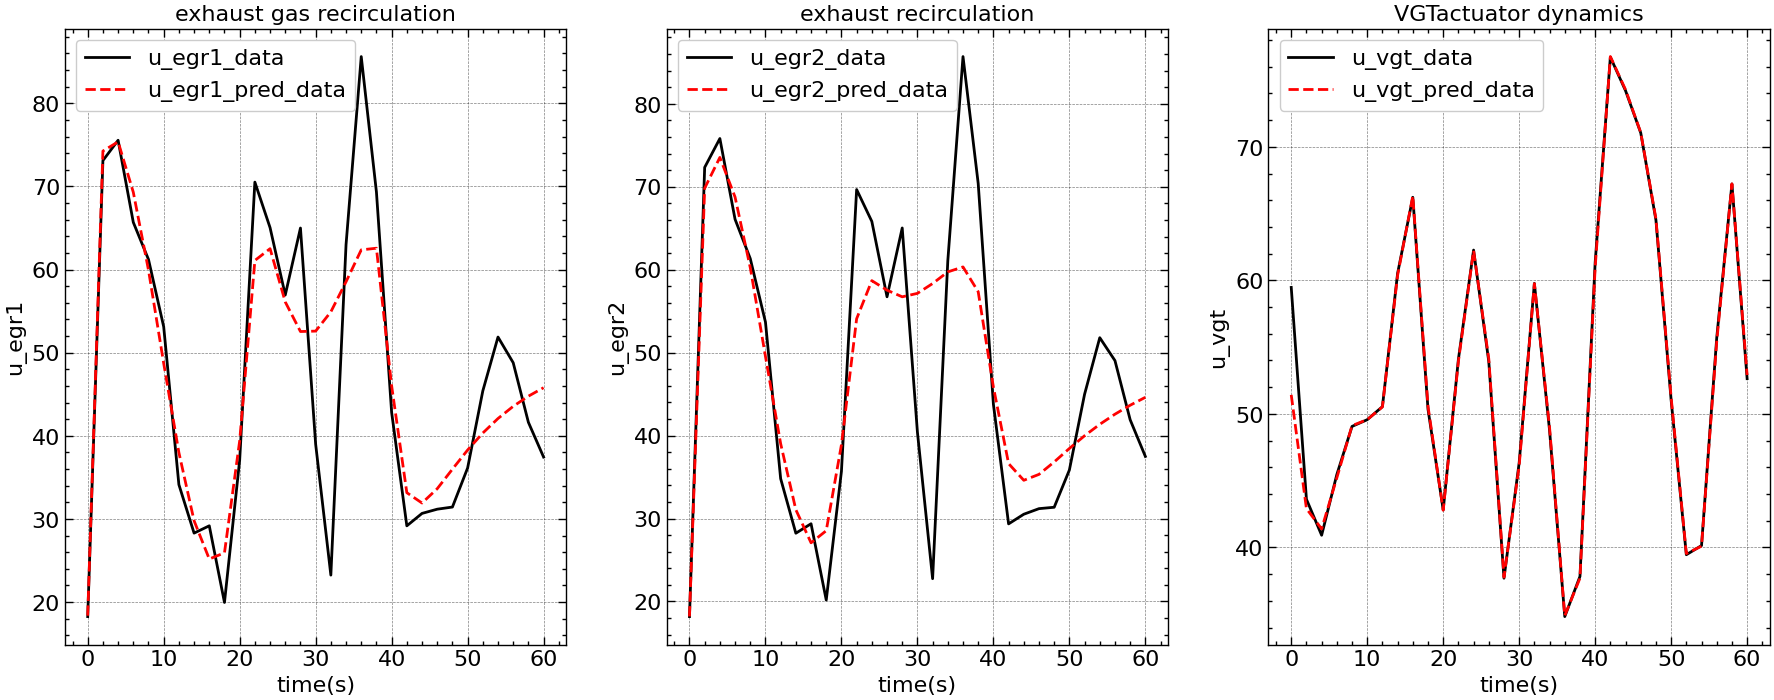

In [111]:
fig , ax = plt.subplots(1,3, figsize = (22,8))

ax[0].plot(t_data, u_egr1_data_train, label = "u_egr1_data", color = 'black')
ax[0].plot(t_data, u_egr1_pred_data, label = "u_egr1_pred_data", color = 'red', linestyle = '--')
ax[0].set_ylabel("u_egr1")
ax[0].set_xlabel("time(s)")
ax[0].set_title("exhaust gas recirculation")
ax[0].legend()

ax[1].plot(t_data, u_egr2_data_train, label = "u_egr2_data", color = 'black')
ax[1].plot(t_data, u_egr2_pred_data, label = "u_egr2_pred_data", color = 'red', linestyle = '--')
ax[1].set_ylabel("u_egr2")
ax[1].set_xlabel("time(s)")
ax[1].set_title("exhaust recirculation")
ax[1].legend()

ax[2].plot(t_data, u_vgt_data_train, label = "u_vgt_data", color = 'black')
ax[2].plot(t_data, u_vgt_pred_data, label = "u_vgt_pred_data", color = 'red', linestyle = '--')
ax[2].set_ylabel("u_vgt")
ax[2].set_xlabel("time(s)")
ax[2].set_title("VGTactuator dynamics")
ax[2].legend()

plt.show()

#### Initial Conditions

In [112]:
# Initial Conditions for pim, pem, omeggat, xr, T1
print(f"pim[0] = {pim_data[0]:.4e}")
print(f"pem[0] = {pem_data[0]:.4e}")
print(f"omeggat[0] = {omegat_data[0]:.4e}")
print(f"xr[0] = {xr_data[0]:.4e}")
print(f"T1[0] = {T1_data[0]:.4e}")

pim[0] = 1.0134e+05
pem[0] = 1.0237e+05
omeggat[0] = 5.2360e+03
xr[0] = 2.0222e-02
T1[0] = 3.1495e+02


#### Theoritical values for unknown parameters

In [113]:
print(f"Theoritical values for unknown parameters\n")
print(f"Aegrmax = {Aegrmax_true:.0e}")
print(f"Avgtmax = {Avgtmax_true:.4e}")
print(f"hsc = {eta_sc_true}")
print(f"htot = {htot_true}")

Theoritical values for unknown parameters

Aegrmax = 4e-04
Avgtmax = 8.4558e-04
hsc = 1.1015
htot = 96.2755


#### Preprocessing

In [114]:
# Functions for calculations in equation losses

def Pi_egr_torch(pim: torch.Tensor, pem: torch.Tensor, Πegropt: float) -> torch.Tensor:
    ratio = pim / pem  # same as pem[i] / pim[i]
    clamped_ratio = torch.clamp(ratio, min=Πegropt, max=1.0)
    return clamped_ratio

def Pi_egr(pim: np.ndarray, pem: np.ndarray, Πegropt: float):
    pegr_values = []
    for i in range(len(pim)):
        ratio = pim[i]/pem[i]
        if ratio < Πegropt:
            pegr_values.append(Πegropt)
        elif ratio > 1:
            pegr_values.append(1)
        else:
            pegr_values.append(ratio)
    return np.array(pegr_values)

In [115]:
Psi_egr_data_np = 1 - ((1 - Pi_egr(pim_data, pem_data, Πegropt))/(1 - Πegropt) - 1)**2
Psi_egr_data_np = Psi_egr_data_np.reshape(-1,1)

In [116]:
# Convering input variables to tensors

# data points
ne_data = np.full((len(t_data,)), ne_data[0])
u_delta_data = np.full((len(t_data,)), u_delta_data[0])

ne_data_tensor = torch.tensor(ne_data, dtype = torch.float32).view(-1,1)
u_delta_data_tensor = torch.tensor(u_delta_data, dtype = torch.float32).view(-1,1)

# residual points
ne_physics = np.full((len(t_physics,)), ne_data[0])
u_delta_physics = np.full((len(t_physics,)), u_delta_data[0])

ne_physics_tensor = torch.tensor(ne_physics, dtype = torch.float32).view(-1,1)
u_delta_physics_tensor = torch.tensor(u_delta_physics, dtype = torch.float32).view(-1,1)

# Tamb
Tamb_array_physics = np.zeros(len(t_physics))
for i in range (len(Tamb_array_physics)):
    Tamb_array_physics[i] = Tamb
Tamb_physics_tensor = torch.tensor(Tamb_array_physics, dtype=torch.float32).view(-1, 1)
Tamb_physics_norm_tensor = normalize_tensor_0_1(Tamb_physics_tensor).view(-1, 1)

In [117]:
pim_data_train_torch = torch.tensor(pim_data_train, dtype = torch.float32).view(-1,1)
pem_data_train_torch = torch.tensor(pem_data_train, dtype = torch.float32).view(-1,1)
omegat_data_train_torch = torch.tensor(omegat_data_train, dtype = torch.float32).view(-1,1)
xr_data_train_torch = torch.tensor(xr_data_train, dtype = torch.float32).view(-1,1)
T1_data_train_torch = torch.tensor(T1_data_train, dtype = torch.float32).view(-1,1)
Wegr_data_train_torch = torch.tensor(Wegr_data_train, dtype = torch.float32).view(-1,1)

#### Model


Epoch 0/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 3.21e+00
  Eq_loss_pem     = 1.02e+00
  Eq_loss_omeggat = 5.38e-01
  Eq_loss_T1      = 1.01e+03
  Eq_loss_xr      = 9.97e+01

Data Losses:
  Data_loss_pim     = 2.11e+00
  Data_loss_pem     = 4.32e+00
  Data_loss_omegat = 2.25e+02
  Data_loss_Wegr    = 1.08e+00

Initial Condition Losses:
  IC_loss_pim     = 9.45e-01
  IC_loss_pem     = 6.78e-01
  IC_loss_omegat = 1.08e+00
  IC_loss_T1      = 9.33e+02
  IC_loss_xr      = 1.80e+00
------------------------------------------------------------
Total PINN1 Loss: 1.23e+01
Total PINN2 Loss: 1.02e+02
Total PINN3 Loss: 1.94e+03
Total PINN5 Loss: 2.26e+02

Total Loss: 2.28e+03



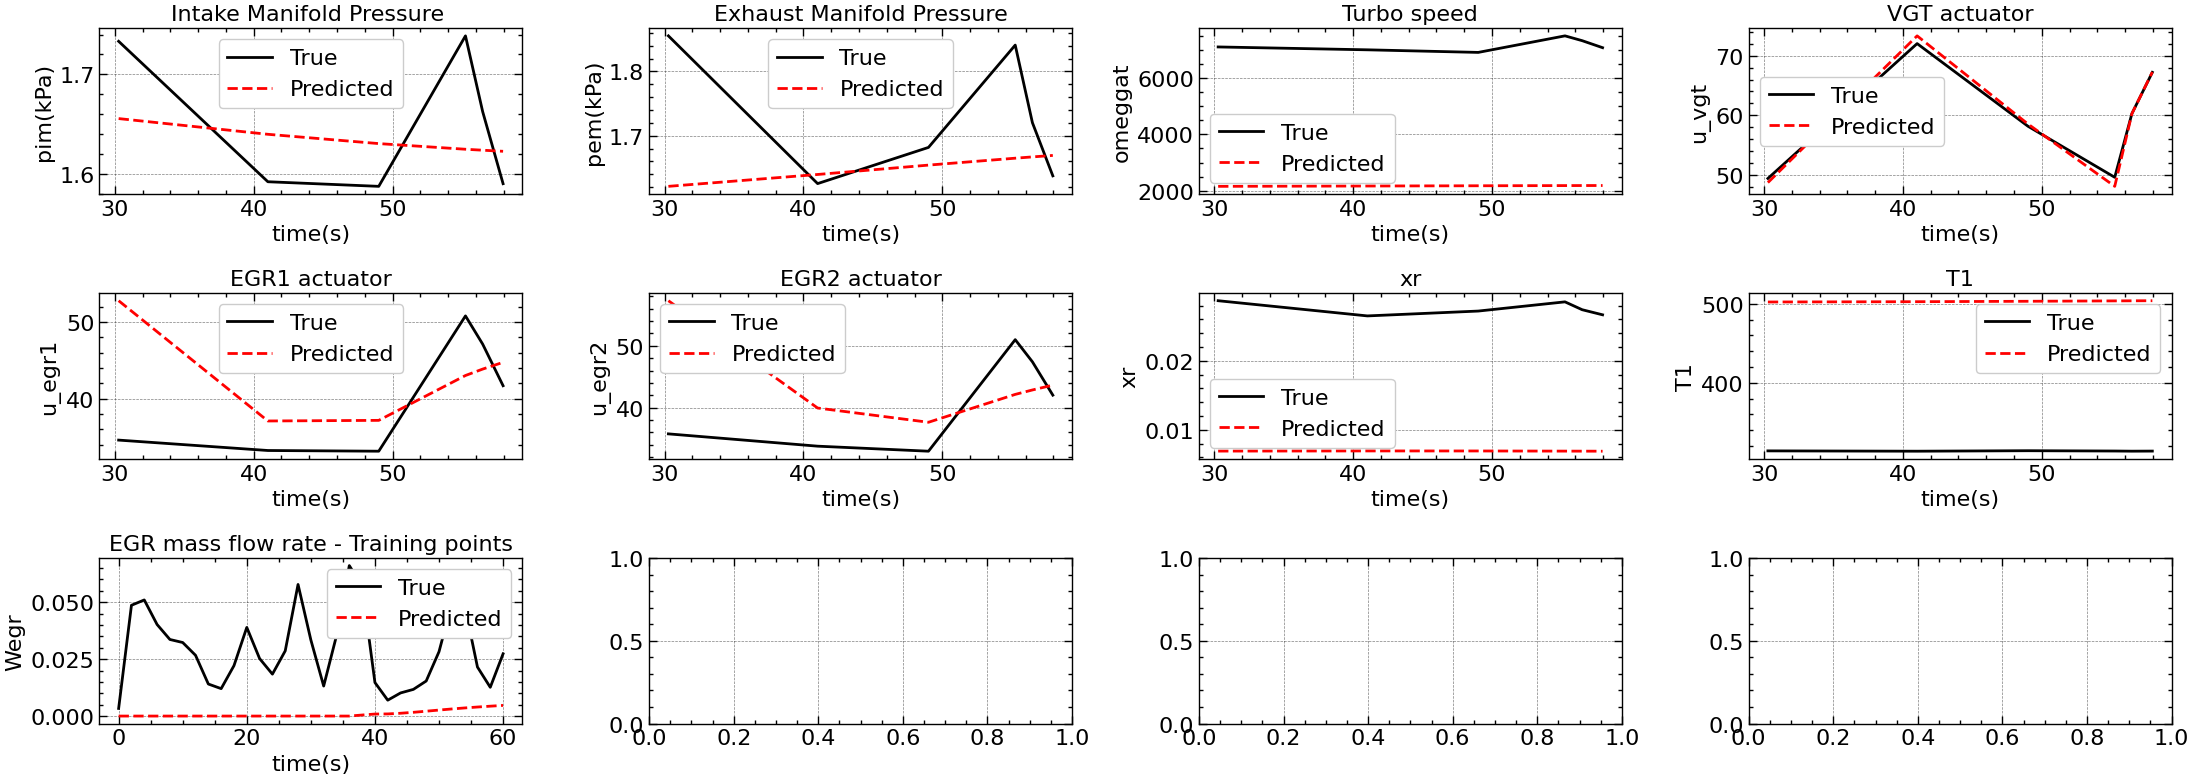


Epoch 5000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 4.76e-02
  Eq_loss_pem     = 1.51e-02
  Eq_loss_omeggat = 6.32e-03
  Eq_loss_T1      = 8.91e-03
  Eq_loss_xr      = 1.12e-01

Data Losses:
  Data_loss_pim     = 1.69e-01
  Data_loss_pem     = 5.24e-01
  Data_loss_omegat = 7.46e-01
  Data_loss_Wegr    = 1.13e-01

Initial Condition Losses:
  IC_loss_pim     = 7.58e-04
  IC_loss_pem     = 6.65e-04
  IC_loss_omegat = 3.39e-02
  IC_loss_T1      = 2.40e-03
  IC_loss_xr      = 1.01e-02
------------------------------------------------------------
Total PINN1 Loss: 7.57e-01
Total PINN2 Loss: 1.22e-01
Total PINN3 Loss: 1.13e-02
Total PINN5 Loss: 7.87e-01

Total Loss: 1.79e+00



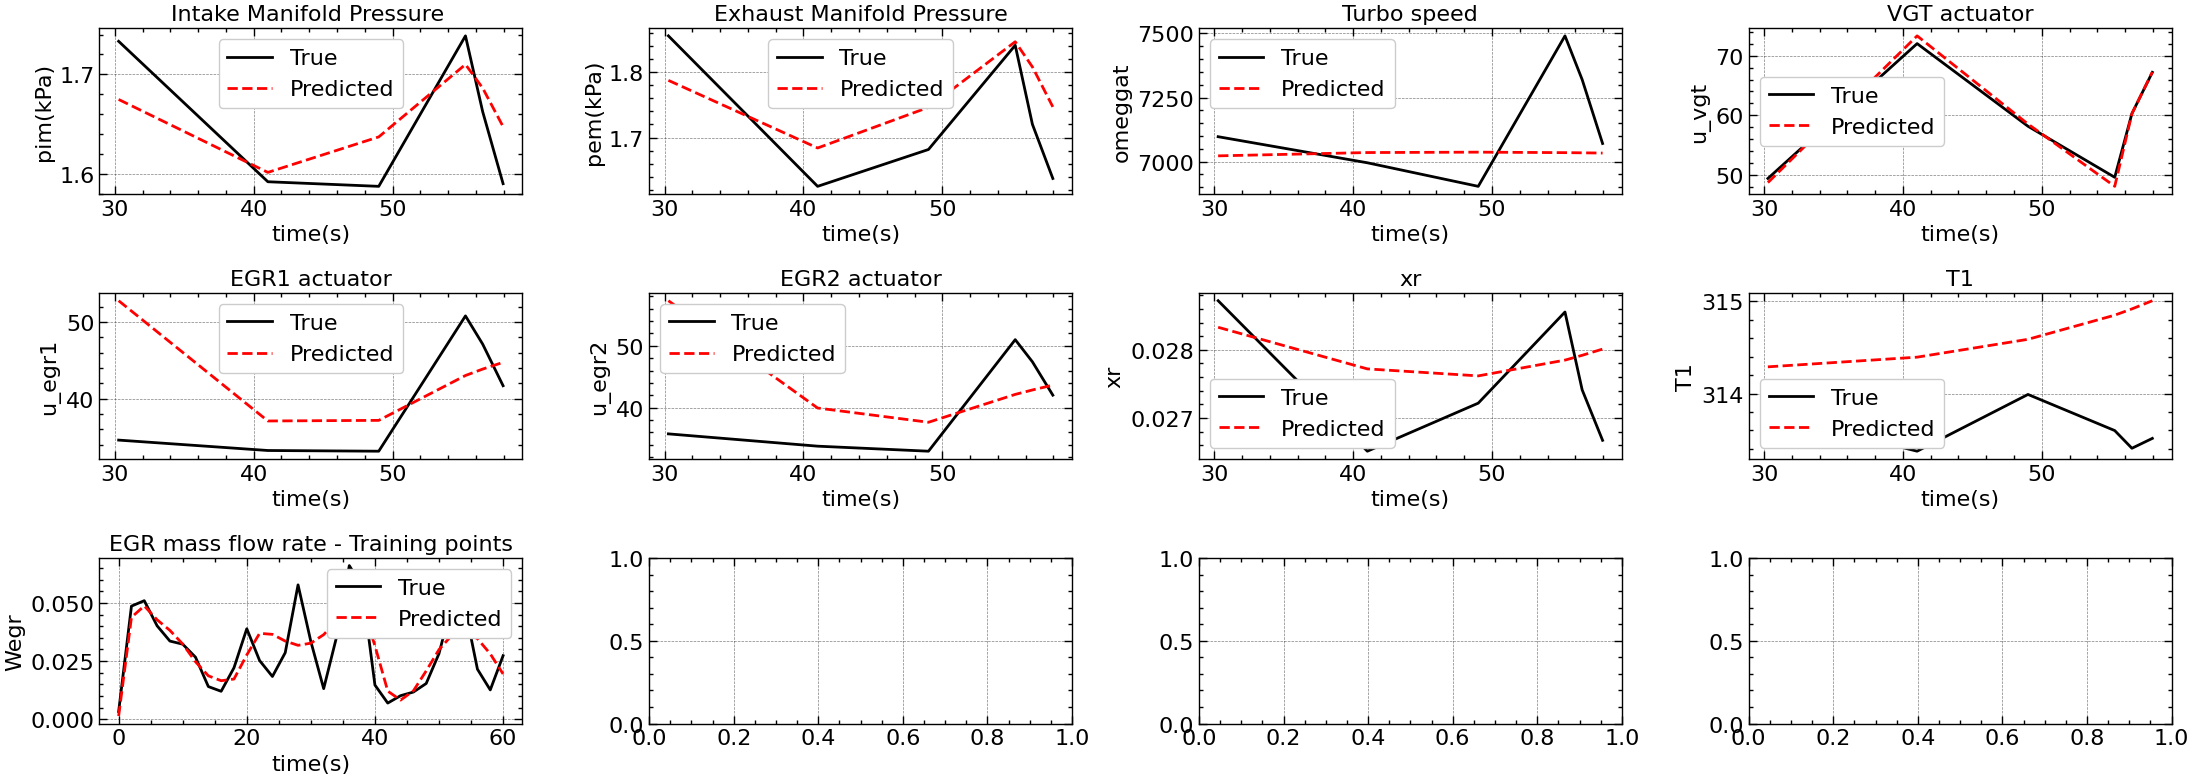


Epoch 10000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.80e-02
  Eq_loss_pem     = 1.46e-02
  Eq_loss_omeggat = 3.96e-03
  Eq_loss_T1      = 1.48e-03
  Eq_loss_xr      = 1.11e-02

Data Losses:
  Data_loss_pim     = 1.41e-01
  Data_loss_pem     = 4.57e-01
  Data_loss_omegat = 3.85e-01
  Data_loss_Wegr    = 1.04e-01

Initial Condition Losses:
  IC_loss_pim     = 1.55e-04
  IC_loss_pem     = 8.05e-05
  IC_loss_omegat = 9.01e-05
  IC_loss_T1      = 1.24e-05
  IC_loss_xr      = 5.62e-05
------------------------------------------------------------
Total PINN1 Loss: 6.41e-01
Total PINN2 Loss: 1.12e-02
Total PINN3 Loss: 1.49e-03
Total PINN5 Loss: 3.89e-01

Total Loss: 1.15e+00



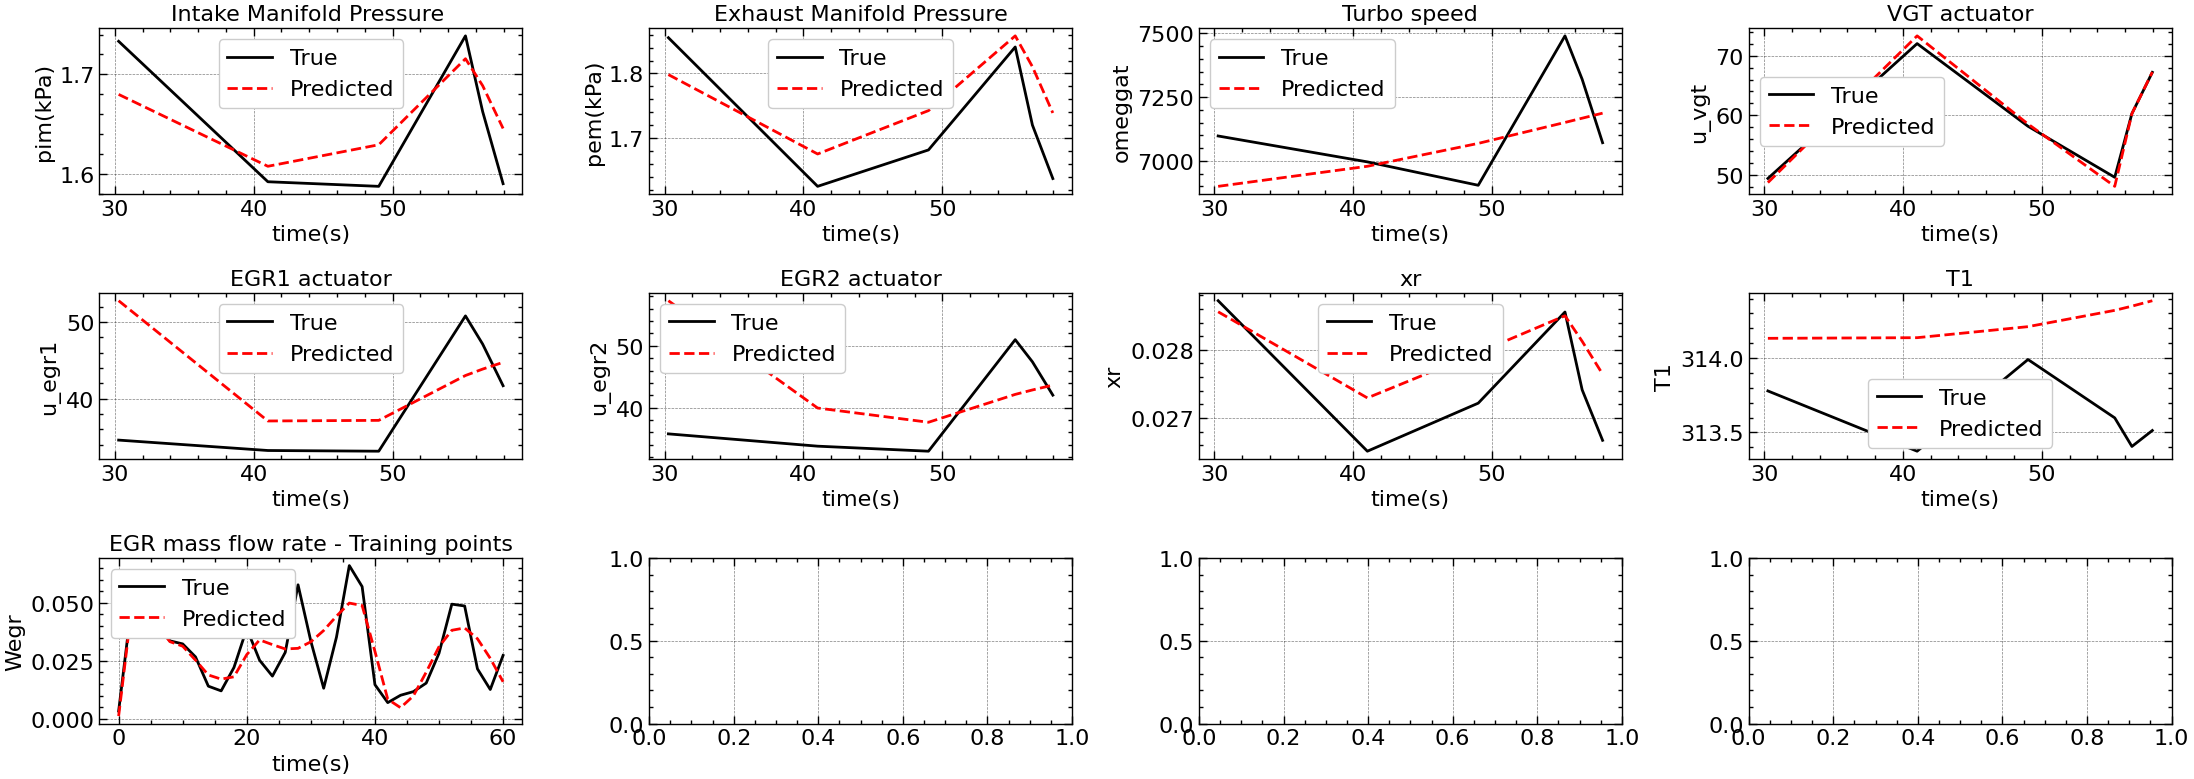


Epoch 15000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.97e-02
  Eq_loss_pem     = 1.12e-02
  Eq_loss_omeggat = 1.26e-03
  Eq_loss_T1      = 2.16e-03
  Eq_loss_xr      = 3.50e-02

Data Losses:
  Data_loss_pim     = 2.59e-02
  Data_loss_pem     = 9.15e-02
  Data_loss_omegat = 6.26e-02
  Data_loss_Wegr    = 2.53e-02

Initial Condition Losses:
  IC_loss_pim     = 5.20e-05
  IC_loss_pem     = 3.83e-06
  IC_loss_omegat = 8.35e-05
  IC_loss_T1      = 2.33e-05
  IC_loss_xr      = 3.34e-05
------------------------------------------------------------
Total PINN1 Loss: 1.58e-01
Total PINN2 Loss: 3.50e-02
Total PINN3 Loss: 2.19e-03
Total PINN5 Loss: 6.39e-02

Total Loss: 2.85e-01



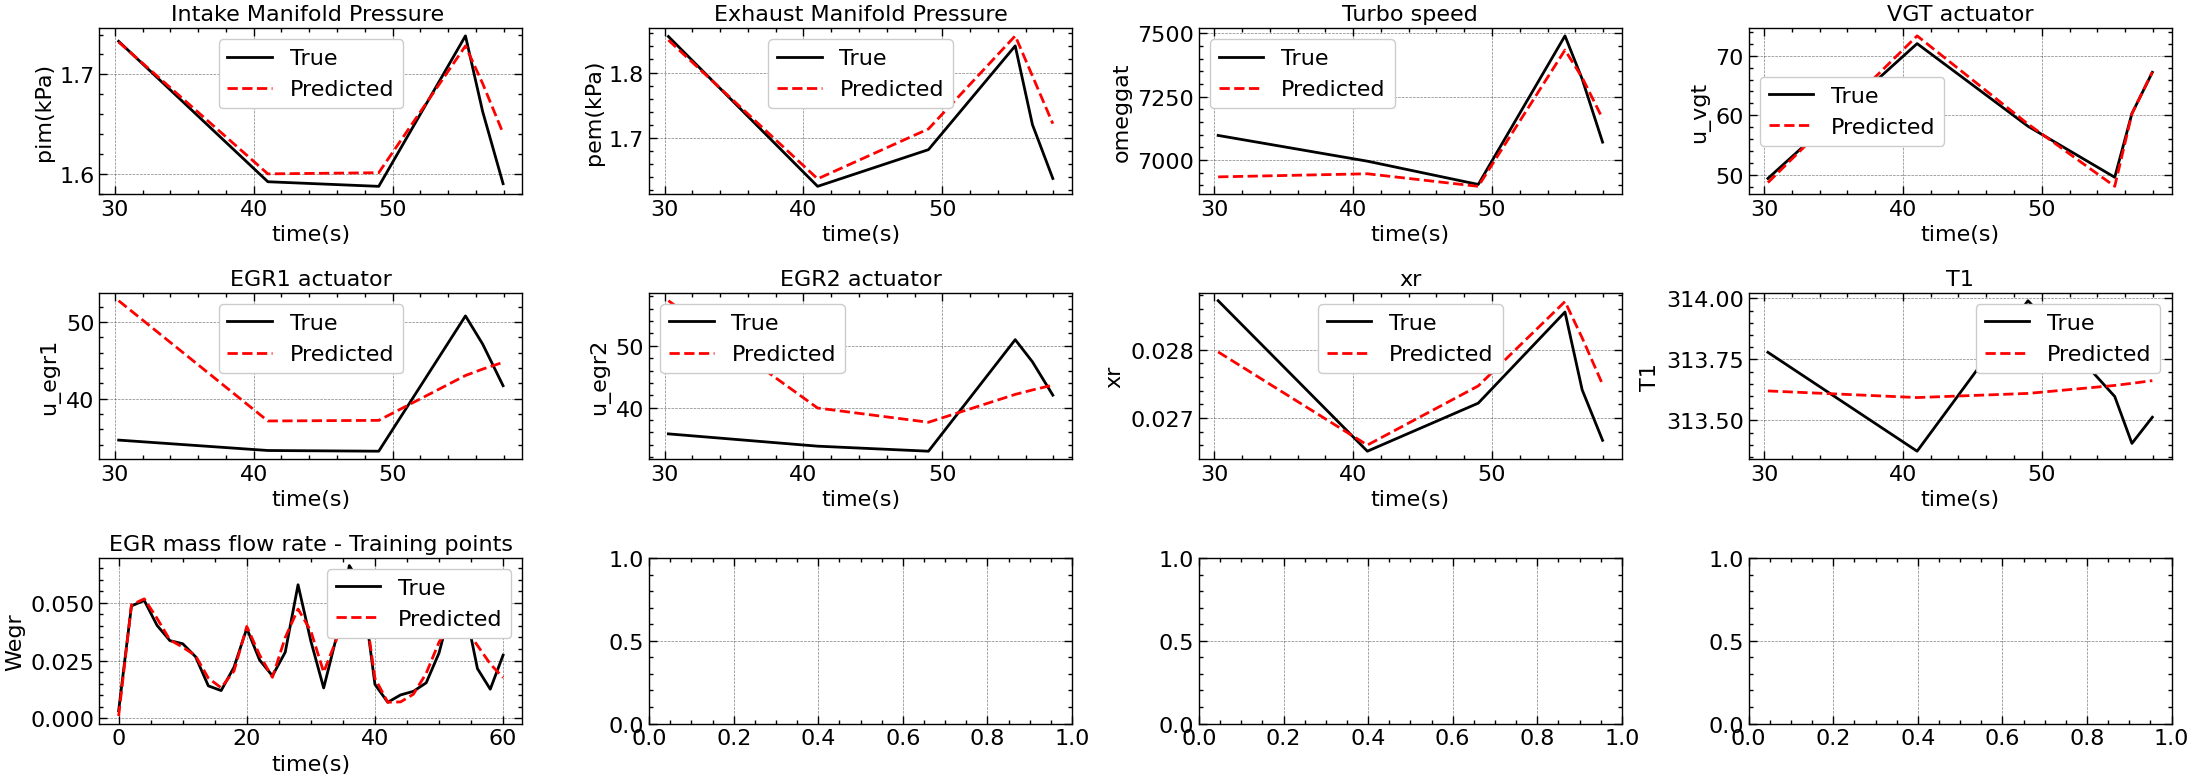


Epoch 20000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.60e-02
  Eq_loss_pem     = 1.01e-02
  Eq_loss_omeggat = 8.65e-04
  Eq_loss_T1      = 1.71e-03
  Eq_loss_xr      = 2.84e-02

Data Losses:
  Data_loss_pim     = 6.24e-03
  Data_loss_pem     = 1.35e-02
  Data_loss_omegat = 4.92e-03
  Data_loss_Wegr    = 7.01e-03

Initial Condition Losses:
  IC_loss_pim     = 4.86e-05
  IC_loss_pem     = 1.05e-06
  IC_loss_omegat = 9.99e-05
  IC_loss_T1      = 8.55e-06
  IC_loss_xr      = 3.51e-05
------------------------------------------------------------
Total PINN1 Loss: 5.59e-02
Total PINN2 Loss: 2.84e-02
Total PINN3 Loss: 1.71e-03
Total PINN5 Loss: 5.89e-03

Total Loss: 9.89e-02



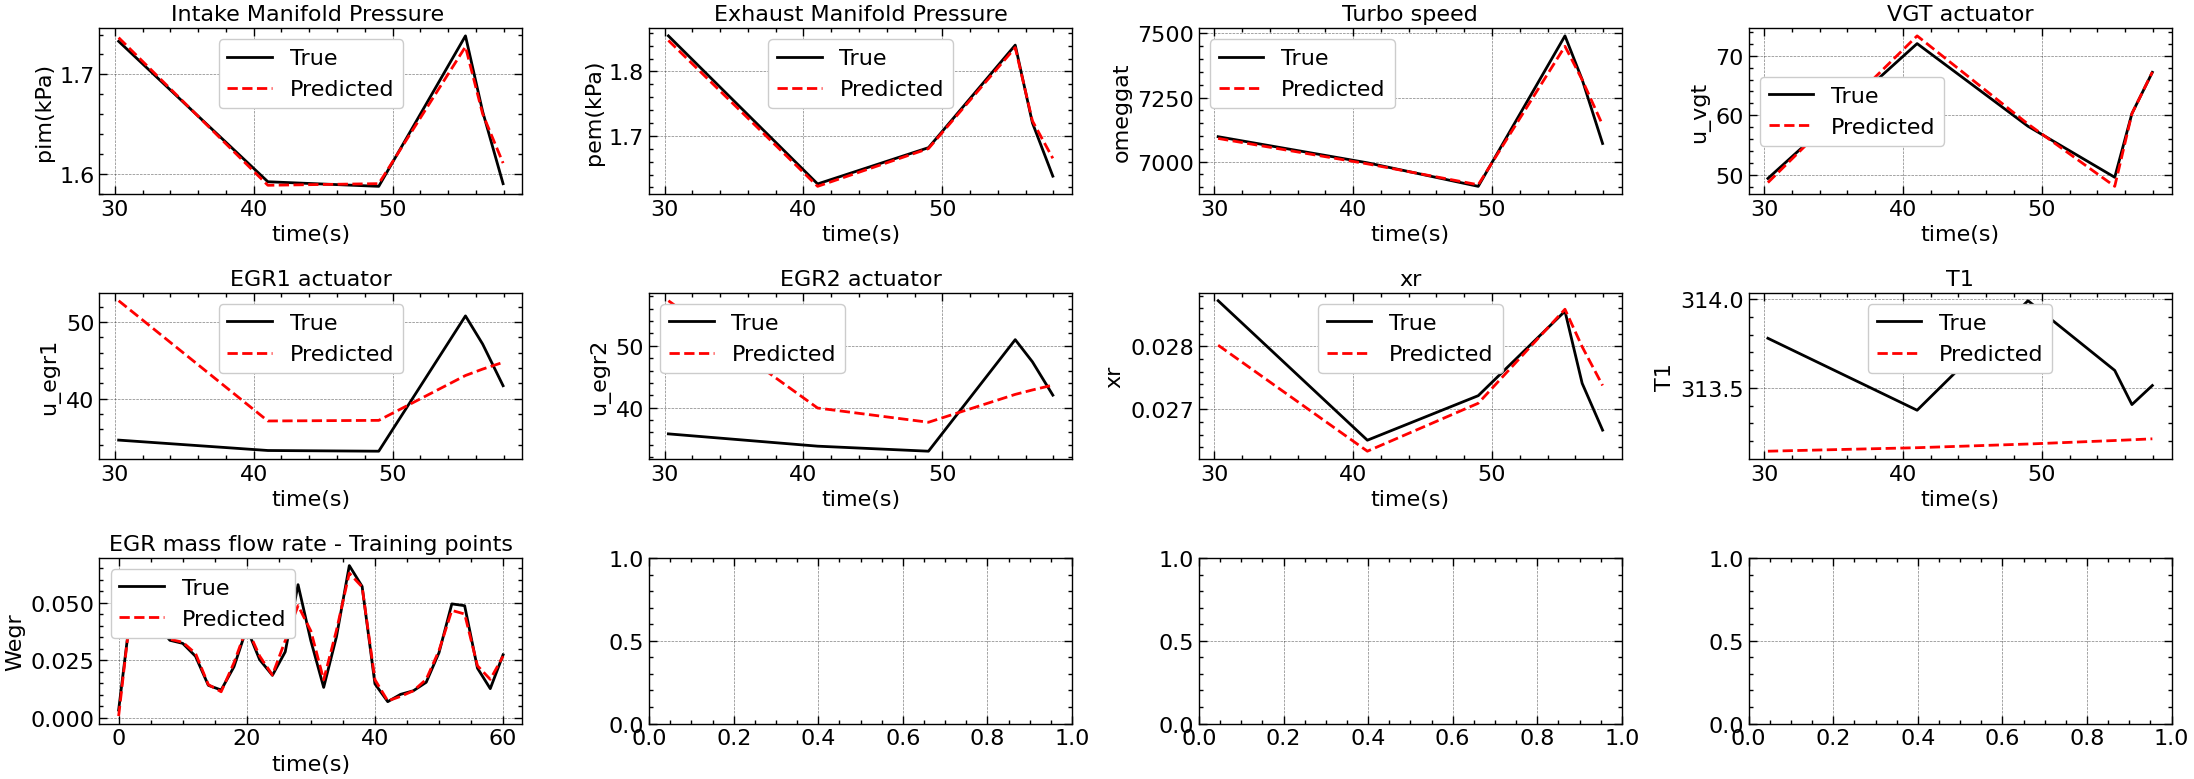


Epoch 25000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.59e-02
  Eq_loss_pem     = 9.94e-03
  Eq_loss_omeggat = 7.35e-04
  Eq_loss_T1      = 2.05e-03
  Eq_loss_xr      = 2.09e-03

Data Losses:
  Data_loss_pim     = 4.70e-03
  Data_loss_pem     = 7.30e-03
  Data_loss_omegat = 1.07e-03
  Data_loss_Wegr    = 5.47e-03

Initial Condition Losses:
  IC_loss_pim     = 5.11e-05
  IC_loss_pem     = 1.45e-06
  IC_loss_omegat = 9.87e-05
  IC_loss_T1      = 8.55e-06
  IC_loss_xr      = 3.41e-05
------------------------------------------------------------
Total PINN1 Loss: 4.79e-02
Total PINN2 Loss: 2.12e-03
Total PINN3 Loss: 2.06e-03
Total PINN5 Loss: 1.91e-03

Total Loss: 5.95e-02



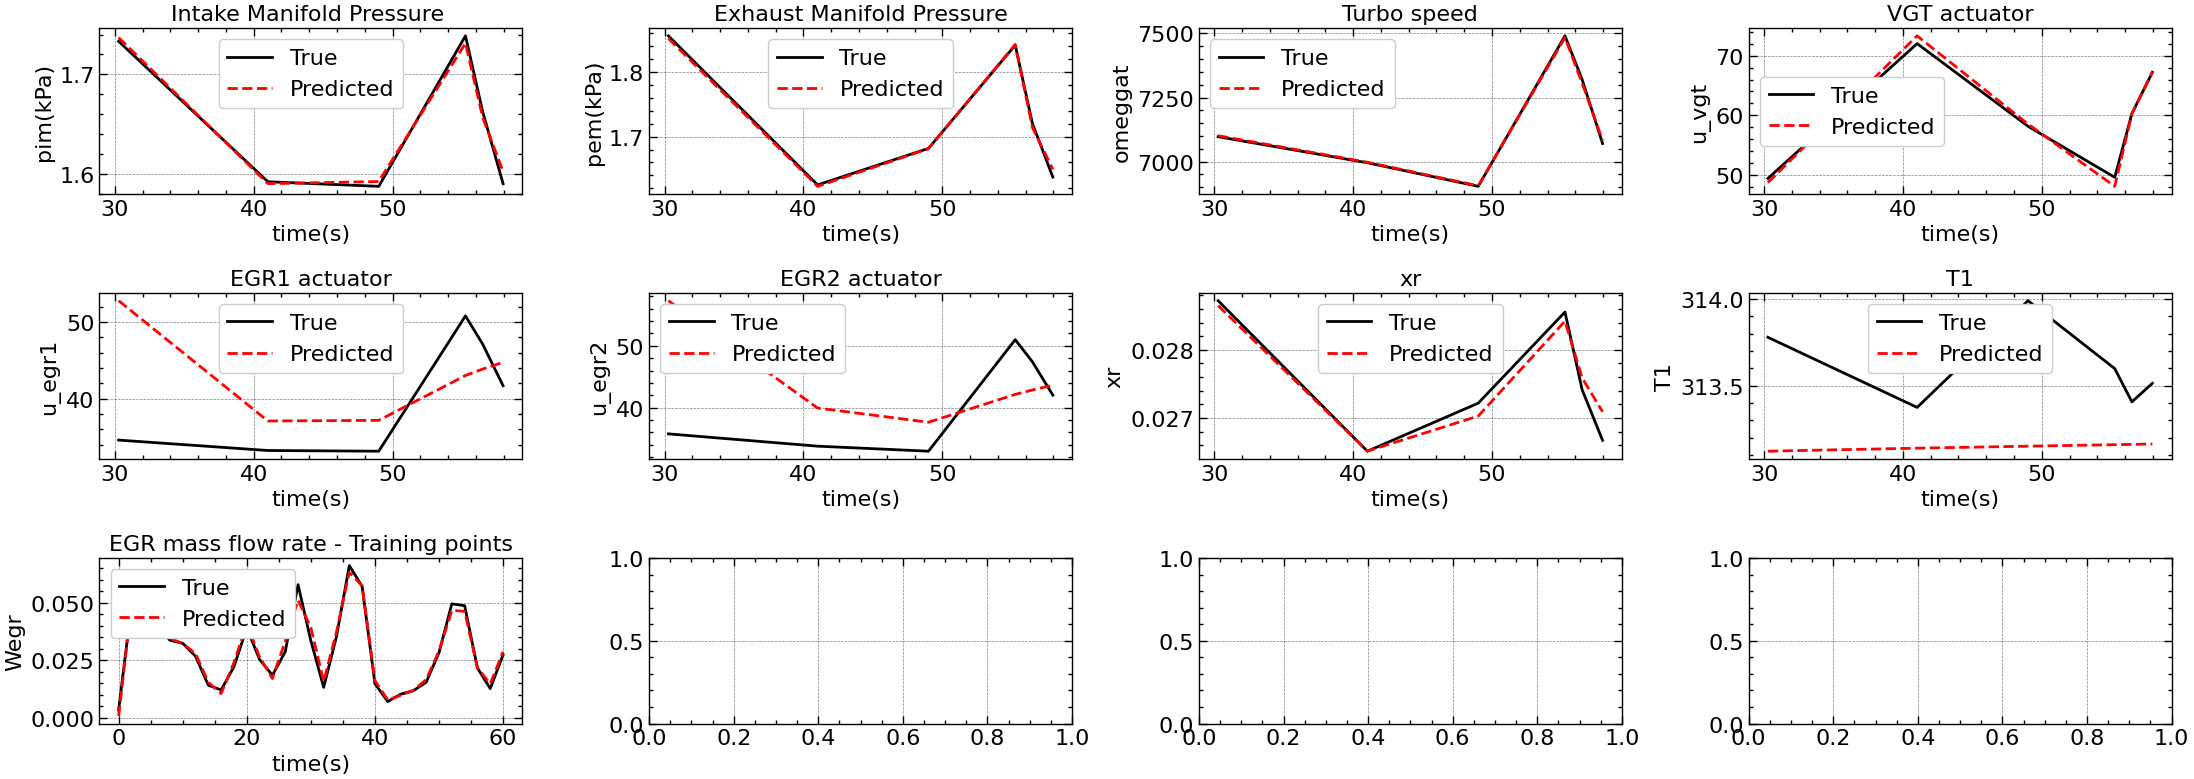


Epoch 30000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.60e-02
  Eq_loss_pem     = 9.89e-03
  Eq_loss_omeggat = 6.88e-04
  Eq_loss_T1      = 2.13e-03
  Eq_loss_xr      = 3.59e-04

Data Losses:
  Data_loss_pim     = 3.90e-03
  Data_loss_pem     = 5.75e-03
  Data_loss_omegat = 7.27e-04
  Data_loss_Wegr    = 4.68e-03

Initial Condition Losses:
  IC_loss_pim     = 4.42e-05
  IC_loss_pem     = 7.06e-07
  IC_loss_omegat = 1.00e-04
  IC_loss_T1      = 9.51e-06
  IC_loss_xr      = 3.71e-05
------------------------------------------------------------
Total PINN1 Loss: 4.55e-02
Total PINN2 Loss: 3.96e-04
Total PINN3 Loss: 2.13e-03
Total PINN5 Loss: 1.51e-03

Total Loss: 5.43e-02



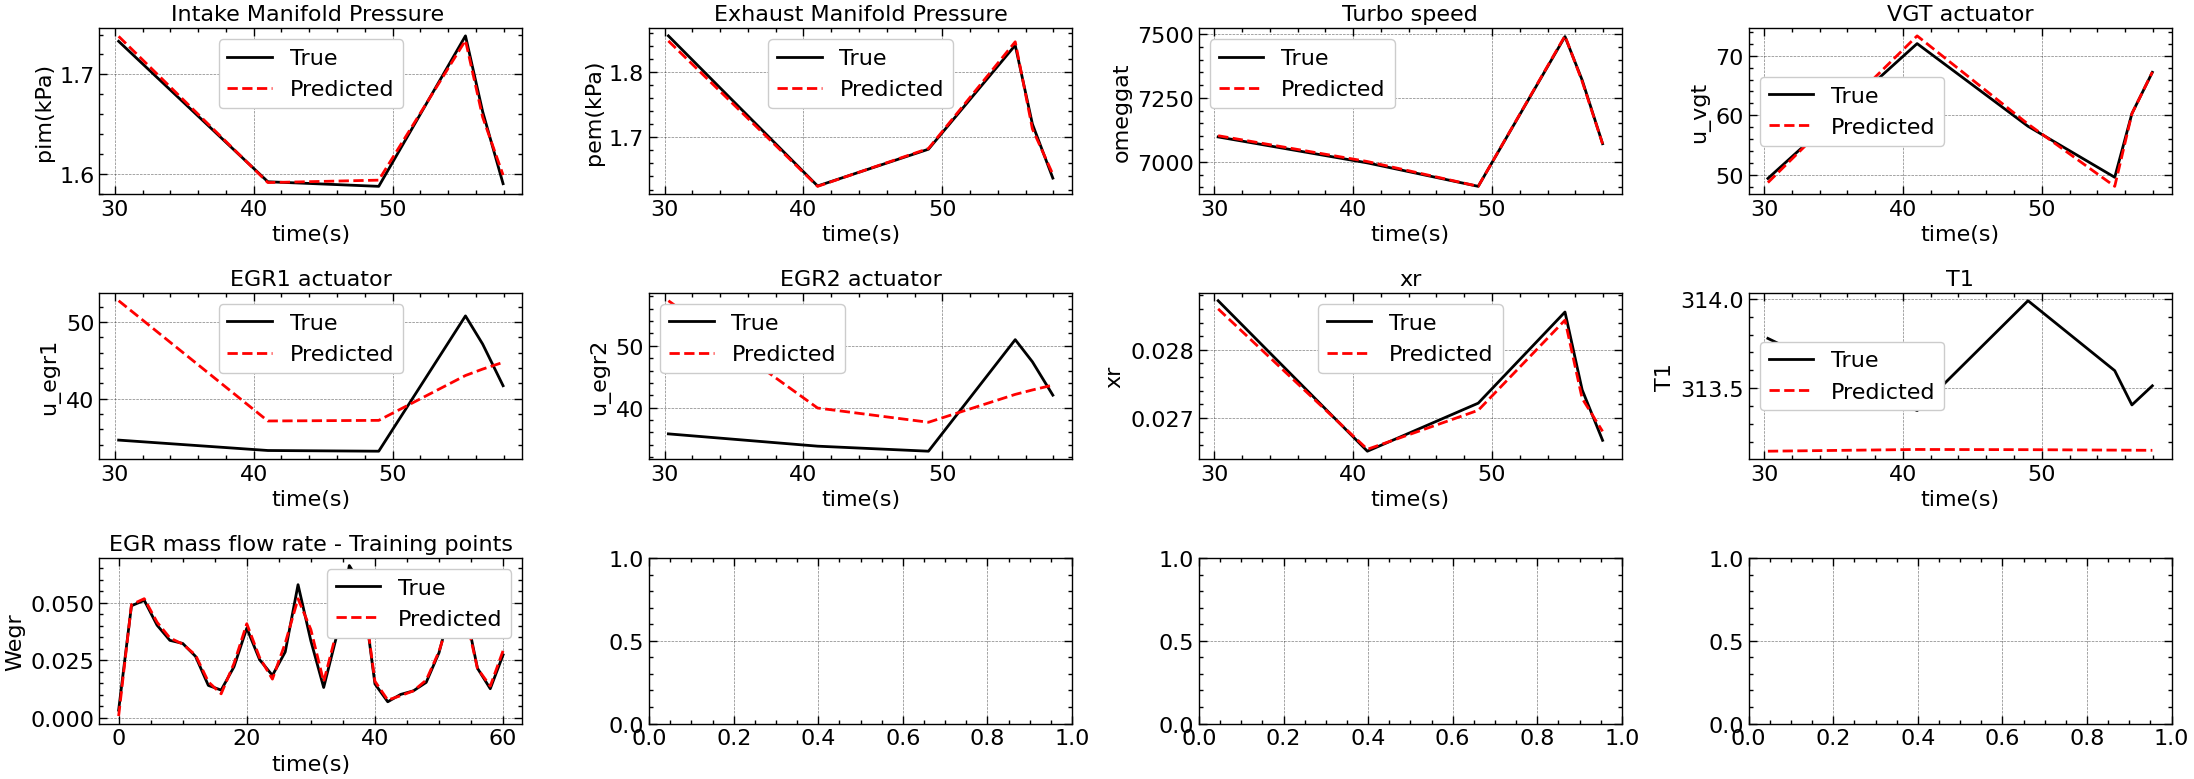


Epoch 35000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.61e-02
  Eq_loss_pem     = 9.83e-03
  Eq_loss_omeggat = 6.37e-04
  Eq_loss_T1      = 2.14e-03
  Eq_loss_xr      = 2.32e-04

Data Losses:
  Data_loss_pim     = 3.37e-03
  Data_loss_pem     = 4.09e-03
  Data_loss_omegat = 6.20e-04
  Data_loss_Wegr    = 4.06e-03

Initial Condition Losses:
  IC_loss_pim     = 3.86e-05
  IC_loss_pem     = 4.33e-07
  IC_loss_omegat = 1.00e-04
  IC_loss_T1      = 1.01e-05
  IC_loss_xr      = 3.69e-05
------------------------------------------------------------
Total PINN1 Loss: 4.35e-02
Total PINN2 Loss: 2.69e-04
Total PINN3 Loss: 2.15e-03
Total PINN5 Loss: 1.36e-03

Total Loss: 5.13e-02



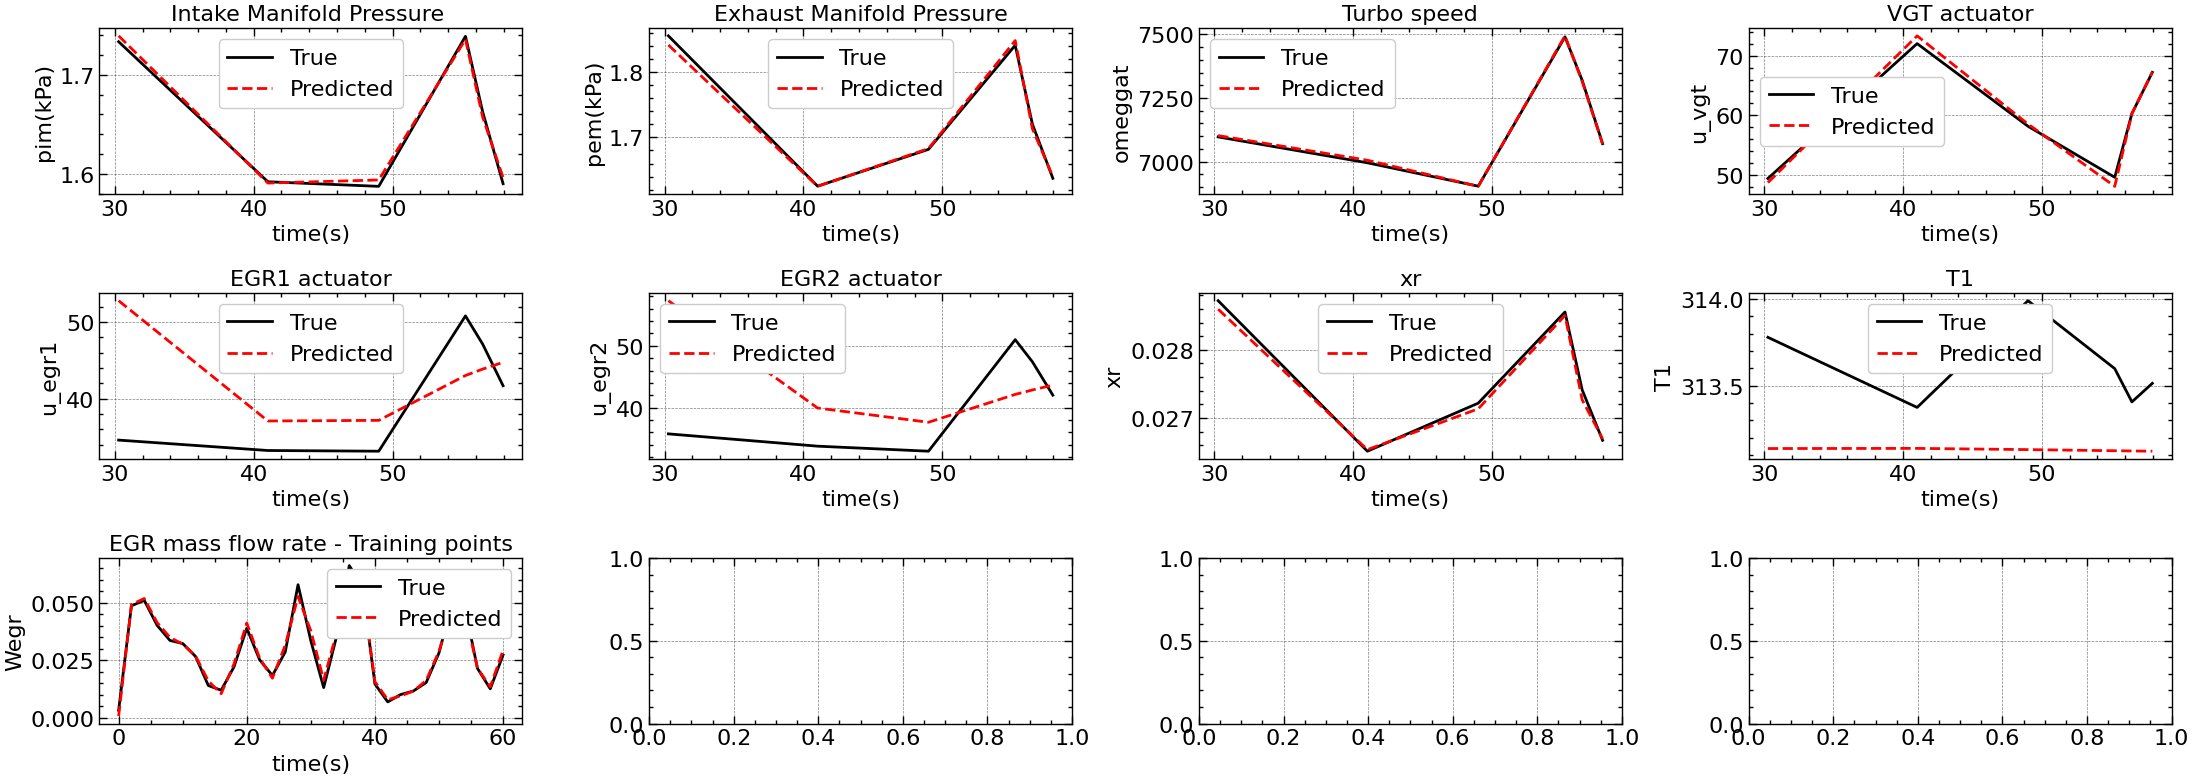


Epoch 40000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.71e-02
  Eq_loss_pem     = 9.79e-03
  Eq_loss_omeggat = 6.50e-04
  Eq_loss_T1      = 2.21e-03
  Eq_loss_xr      = 4.99e-04

Data Losses:
  Data_loss_pim     = 3.39e-03
  Data_loss_pem     = 3.21e-03
  Data_loss_omegat = 6.58e-04
  Data_loss_Wegr    = 3.69e-03

Initial Condition Losses:
  IC_loss_pim     = 3.77e-05
  IC_loss_pem     = 1.23e-07
  IC_loss_omegat = 1.18e-04
  IC_loss_T1      = 3.17e-06
  IC_loss_xr      = 3.35e-06
------------------------------------------------------------
Total PINN1 Loss: 4.35e-02
Total PINN2 Loss: 5.03e-04
Total PINN3 Loss: 2.21e-03
Total PINN5 Loss: 1.43e-03

Total Loss: 5.14e-02



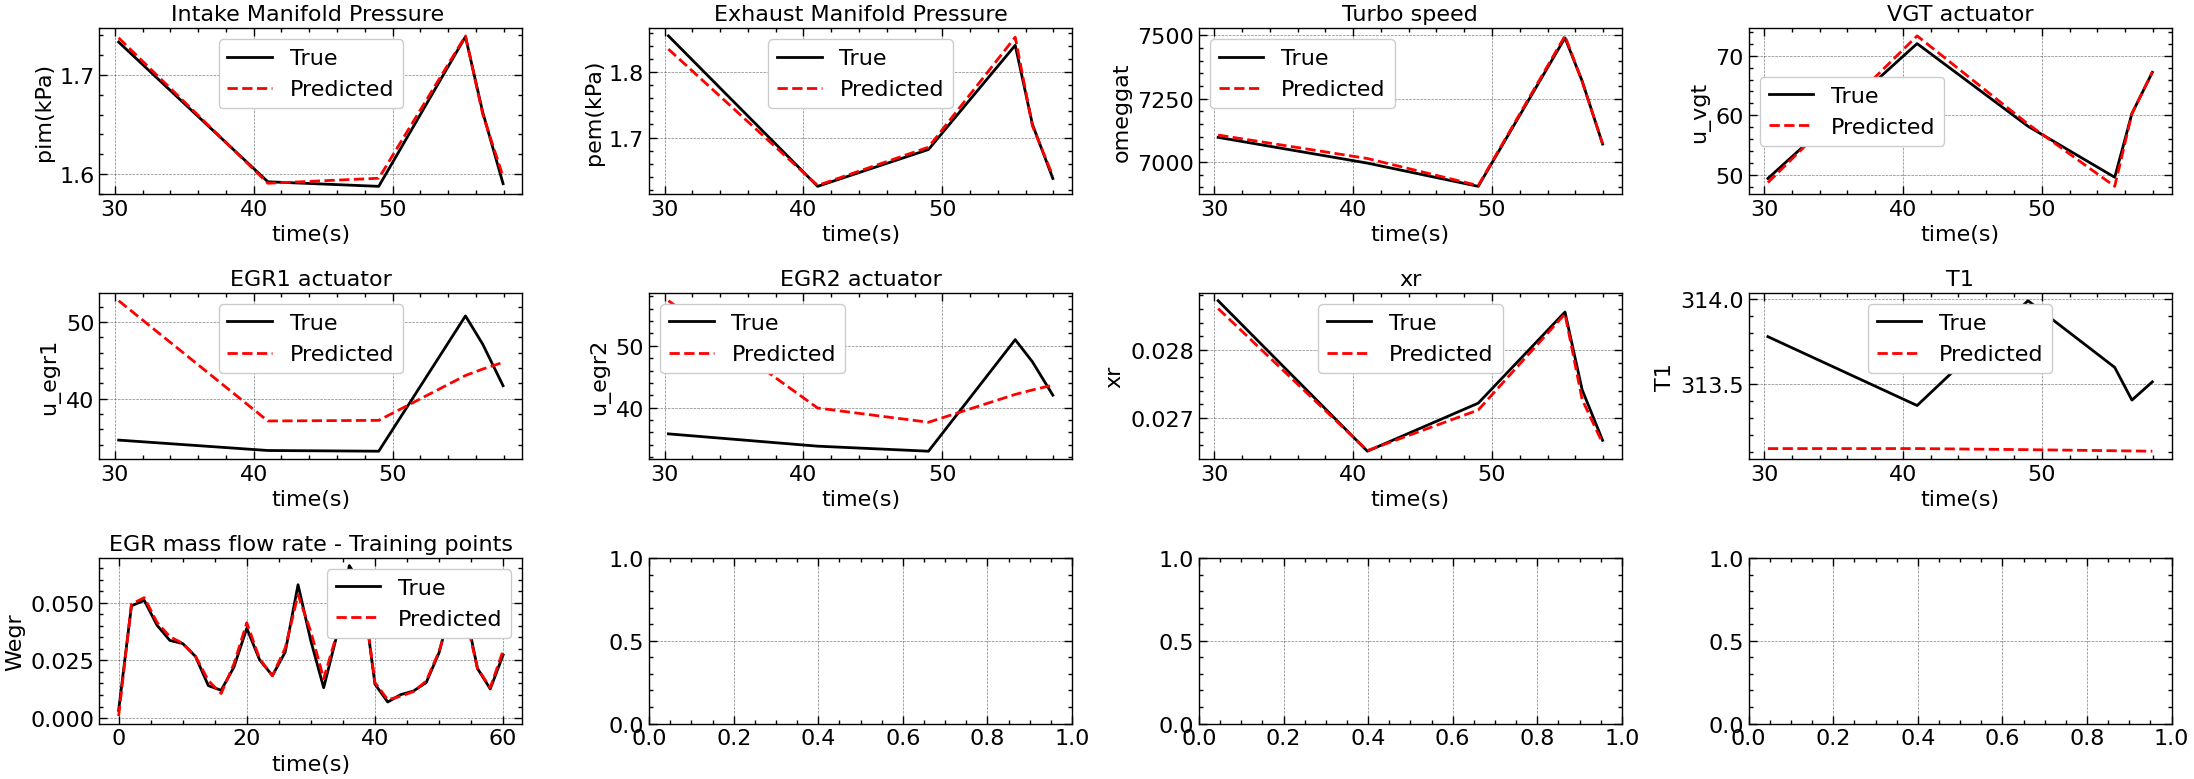


Epoch 45000/45001
------------------------------------------------------------
Equation Losses:
  Eq_loss_pim     = 2.64e-02
  Eq_loss_pem     = 9.76e-03
  Eq_loss_omeggat = 6.26e-04
  Eq_loss_T1      = 2.18e-03
  Eq_loss_xr      = 2.26e-04

Data Losses:
  Data_loss_pim     = 1.81e-03
  Data_loss_pem     = 2.42e-03
  Data_loss_omegat = 4.88e-04
  Data_loss_Wegr    = 3.34e-03

Initial Condition Losses:
  IC_loss_pim     = 3.96e-05
  IC_loss_pem     = 2.75e-07
  IC_loss_omegat = 9.67e-05
  IC_loss_T1      = 1.23e-05
  IC_loss_xr      = 4.69e-05
------------------------------------------------------------
Total PINN1 Loss: 4.05e-02
Total PINN2 Loss: 2.73e-04
Total PINN3 Loss: 2.19e-03
Total PINN5 Loss: 1.21e-03

Total Loss: 4.75e-02



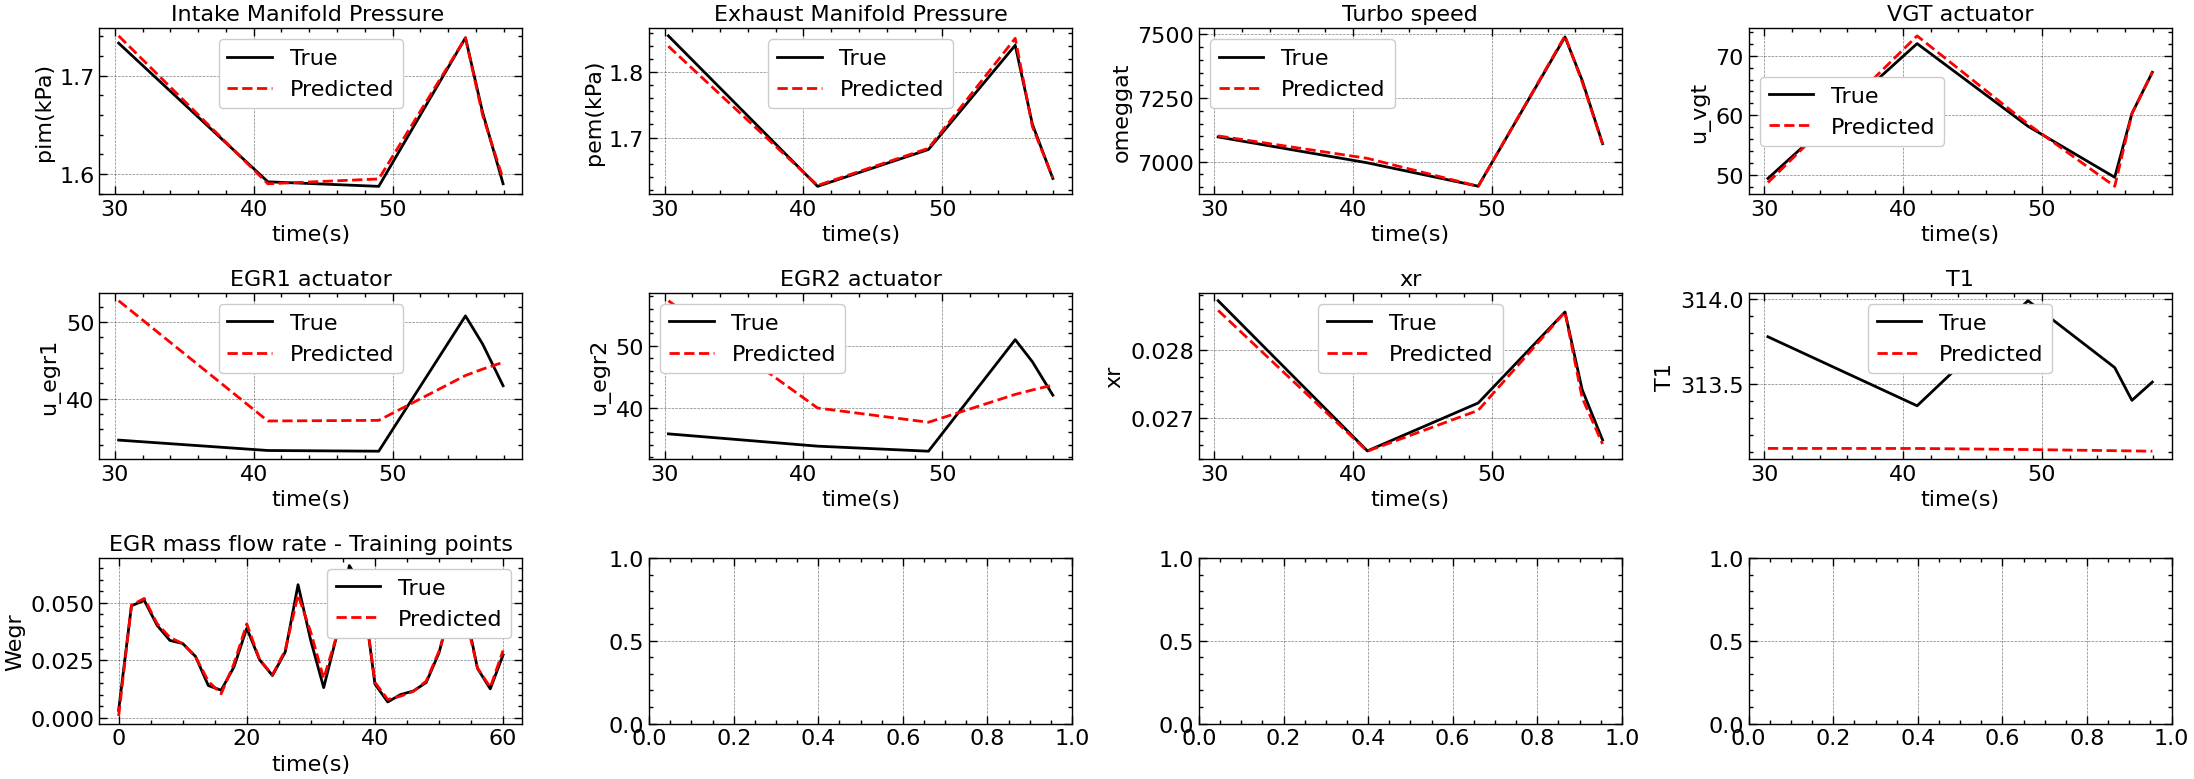

In [118]:
# PINNs for predicting the dynamics of the variables pim, pem, omeggat, T1, xr
pinn1 = FFN1(1, 128) # pim, pem
pinn2 = FFN2(1, 1, 128) # xr
pinn3 = FFN3(1, 1, 128) # T1
pinn5 = FFN5(1, 1, 64) # omeggat

# Defining learnable parameters
Aegrmax = torch.nn.Parameter(torch.tensor([1e-4], dtype=torch.float32, requires_grad=True))
hsc = torch.nn.Parameter(torch.tensor([1], dtype=torch.float32, requires_grad=True))
htot = torch.nn.Parameter(torch.tensor([100], dtype=torch.float32, requires_grad=True))
Avgtmax = torch.nn.Parameter(torch.tensor([1e-4], dtype=torch.float32, requires_grad=True))

# Storing parameter values over epochs
Aegrmax_values, hsc_values, htot_values, Avgtmax_values = [], [], [], []

# Optimizer
optimizer = optim.Adam(
    list(pinn1.parameters()) + list(pinn2.parameters()) + list(pinn3.parameters()) +
     list(pinn5.parameters()) +
    [Aegrmax, hsc, htot, Avgtmax],
    lr=0.0001
)

# Initializing loss histories
Loss_history_PINN1 = []
Loss_history_PINN2 = []
Loss_history_PINN3 = []
Loss_history_PINN5 = []
Loss_history_Wegr = []
Loss_history_total = []

# Epochs
num_epochs = 45001
print_every = 5000

# MSE Loss
MSE_Loss = nn.MSELoss()

# Training the model
for epoch in range(num_epochs):
    pinn1.train()
    pinn2.train()
    pinn3.train()
    pinn5.train()
    optimizer.zero_grad()

    ####################################################
    # -----------Initial Condition Losses -------------#
    ####################################################

    ### IC Losses for pim, pem
    p_pred_boundary = pinn1(t_boundary_scaled_tensor)
    pim_pred_boundary = p_pred_boundary[:,0].view(-1,1)
    pem_pred_boundary = p_pred_boundary[:,1].view(-1,1)

    IC_loss_pim = MSE_Loss(torch.squeeze(pim_pred_boundary), torch.full_like(torch.squeeze(pim_pred_boundary), df['pim'][0]))
    IC_loss_pem = MSE_Loss(torch.squeeze(pem_pred_boundary), torch.full_like(torch.squeeze(pem_pred_boundary), df['pem'][0]))


    ###  IC Loss for xr
    xr_pred_boundary = pinn2(t_boundary_scaled_tensor)

    IC_loss_xr = MSE_Loss(torch.squeeze(xr_pred_boundary) , torch.full_like(torch.squeeze(xr_pred_boundary), df['xr'][0]))

    ### IC Loss for T1
    T1_pred_boundary = pinn3(t_boundary_scaled_tensor)

    IC_loss_T1 = MSE_Loss(torch.squeeze(T1_pred_boundary) , torch.full_like(torch.squeeze(T1_pred_boundary), df['T1'][0]))

    ### IC Loss for omeggat
    omegat_pred_boundary = pinn5(t_boundary_scaled_tensor)

    IC_loss_omegat = MSE_Loss(torch.squeeze(omegat_pred_boundary) , torch.full_like(torch.squeeze(omegat_pred_boundary), df['omegat'][0]))

    ### IC_LOSS
    IC_loss_total = IC_loss_pim + IC_loss_pem + IC_loss_xr + IC_loss_T1 + IC_loss_omegat

    ####################################################
    # -----------       Data Losses       -------------#
    ####################################################

    ### Data Losses for pim, pem
    p_pred_data = pinn1(t_data_scaled_tensor)
    pim_pred_data = p_pred_data[:,0].view(-1,1)
    pem_pred_data = p_pred_data[:,1].view(-1,1)

    Data_loss_pim =  torch.mean((torch.from_numpy(pim_data_train) - torch.squeeze(pim_pred_data))**2)
    Data_loss_pem = torch.mean((torch.from_numpy(pem_data_train) - torch.squeeze(pem_pred_data))**2)

    ### Data Loss for omeggat
    omegat_pred_data = pinn5(t_data_scaled_tensor).view(-1,1)

    Data_loss_omegat = torch.mean((torch.from_numpy(omegat_data_train) - torch.squeeze(omegat_pred_data))**2)

    ### Data Loss for Wegr
    T1_pred_data = pinn3(t_data_scaled_tensor).view(-1,1)
    xr_pred_data = pinn2(t_data_scaled_tensor).view(-1,1)

    # Normalizing pim, ne, u_egr
    pim_pred_data_norm = normalize_tensor_0_1(pim_pred_data)
    ne_data_tensor_norm = normalize_tensor_0_1(ne_data_tensor)
    u_egr_pred_data_norm = normalize_tensor_0_1(u_egr_pred_data)

    ## Calculating Wegr

    # eta_vol surrogate for data points
    with torch.no_grad():
        input_tensor_eta_vol = torch.cat((pim_pred_data_norm, ne_data_tensor_norm), dim=1)
        eta_vol_pred_data = FFNN1_PT(input_tensor_eta_vol)

    # fegr surrofate for data points
    with torch.no_grad():
        fegr_pred_data = FFNN2_PT(u_egr_pred_data_norm)

    # Calculations
    Wei_data= (eta_vol_pred_data* pim_pred_data * ne_data_tensor * Vd)/(120 * Ra * Tim)
    Wf_data = 1e-6 * u_delta_data_tensor * ne_data_tensor * ncyl/120
    Weo_data = (Wei_data + Wf_data)
    Pe_data = pem_pred_data/pim_pred_data
    qin_data = (Wf_data * qHV * (1 - xr_pred_data))/(Wei_data + Wf_data)
    xp_data = (1 + (qin_data * xcv) / (cva * T1_pred_data * (rc**(gamma_a - 1))))
    xv_data = (1 + qin_data * (1 - xcv) / (cpa * ((qin_data * xcv / cva) + T1_pred_data * (rc**(gamma_a - 1)))))
    Te_data = ((hsc) * (Pe_data**(1 - 1/gamma_a)) * (rc**(1 - gamma_a)) * (xp_data**(1/gamma_a - 1)) * (qin_data * ((1 - xcv) / cpa + xcv / cva) + T1_pred_data * (rc**(gamma_a - 1))))
    Tem_data = Tamb + (Te_data - Tamb) * torch.exp((-(htot)* pi * dpipe * lpipe * npipe) / (Weo_data * cpe ))
    Pi_egr_data = Pi_egr_torch(pim_pred_data, pem_pred_data, Πegropt)
    Psi_egr_data = 1 - ((1 - Pi_egr_data) / (1 - Πegropt) - 1)**2
    Aegr_data = Aegrmax * fegr_pred_data

    Wegr_pred_data = (Aegr_data * pim_pred_data * Psi_egr_data)/(torch.sqrt(Tem_data * Re))

    Data_loss_Wegr =  torch.mean((torch.from_numpy(Wegr_data_train) - torch.squeeze(Wegr_pred_data))**2)

    ### DATA LOSS
    Data_loss_total = Data_loss_pim + Data_loss_pem + Data_loss_omegat + Data_loss_Wegr

    ####################################################
    # -----------     Physics Losses     -------------#
    ####################################################

    ### predicted state variables

    p_pred_physics = pinn1(t_physics_scaled_tensor)
    pim_pred_physics = p_pred_physics[:,0].view(-1,1)
    pem_pred_physics = p_pred_physics[:,1].view(-1,1)

    xr_pred_physics = pinn2(t_physics_scaled_tensor).view(-1,1)
    T1_pred_physics = pinn3(t_physics_scaled_tensor).view(-1,1)
    omeggat_pred_physics = pinn5(t_physics_scaled_tensor).view(-1,1)

    Pi_t_physics_tensor = pamb/pem_pred_physics
    Pi_c_physics_tensor = pim_pred_physics/pamb

    # normalizing inputs for pre-trained NNs
    pim_pred_physics_norm = normalize_tensor_0_1(pim_pred_physics)
    ne_physics_tensor_norm = normalize_tensor_0_1(ne_data_tensor)
    u_egr_pred_physics_norm = normalize_tensor_0_1(u_egr_pred_physics)
    u_vgt_pred_physics_norm = normalize_tensor_0_1(u_vgt_pred_physics)
    Pi_t_physics_tensor_norm = normalize_tensor_0_1(Pi_t_physics_tensor)
    omeggat_pred_physics_norm = normalize_tensor_0_1(omeggat_pred_physics)
    Tamb_physics_tensor_norm = normalize_tensor_0_1(Tamb_physics_tensor)
    Pi_c_physics_tensor_norm = normalize_tensor_0_1(Pi_c_physics_tensor)

    ### Pre-Trained NNs - Surrogates for residual points

    # Switching pre-trained NNs to evaluation mode
    FFNN1_PT.eval() # eta_vol
    FFNN2_PT.eval() # fegr
    FFNN3_PT.eval() # F_vgt_Pit
    FFNN5_PT.eval() # eta_tm
    FFNN6_PT.eval() # Fc

    # eta_vol
    with torch.no_grad():
        input_tensor_eta_vol = torch.cat((pim_pred_physics_norm, ne_physics_tensor_norm), dim=1)
        eta_vol_pred_physics = FFNN1_PT(input_tensor_eta_vol)
        eta_vol_pred_physics = eta_vol_pred_physics.detach()

    # fegr
    with torch.no_grad():
        fegr_pred_physics = FFNN2_PT(u_egr_pred_physics_norm)
        fegr_pred_physics = fegr_pred_physics.detach()

    # F_vgt_Pit
    with torch.no_grad():
        input_tensor_F_vgt_Pit = torch.cat((u_vgt_pred_physics_norm, Pi_t_physics_tensor_norm), dim=1)
        F_vgt_Pit_pred_physics = FFNN3_PT(input_tensor_F_vgt_Pit)
        F_vgt_Pit_pred_physics = F_vgt_Pit_pred_physics.detach()

    # Fc
    with torch.no_grad():
        input_tensor_Fc = torch.cat((Tamb_physics_tensor_norm, Pi_c_physics_tensor_norm, omeggat_pred_physics_norm), dim=1)
        Fc_pred_physics = FFNN6_PT(input_tensor_Fc)
        Fc_pred_physics = Fc_pred_physics.detach()

    # Calculations
    Wei_physics= (eta_vol_pred_physics* pim_pred_physics * ne_physics_tensor * Vd)/(120 * Ra * Tim)
    Wf_physics = 1e-6 * u_delta_physics_tensor * ne_physics_tensor * ncyl/120
    Weo_physics = (Wei_physics + Wf_physics)
    Pe_physics = pem_pred_physics/pim_pred_physics
    qin_physics = (Wf_physics * qHV * (1 - xr_pred_physics))/(Wei_physics + Wf_physics)
    xp_physics = (1 + (qin_physics * xcv) / (cva * T1_pred_physics * (rc**(gamma_a - 1))))
    xv_physics = (1 + qin_physics * (1 - xcv) / (cpa * ((qin_physics * xcv / cva) + T1_pred_physics * (rc**(gamma_a - 1)))))
    Te_physics = ((hsc) * (Pe_physics**(1 - 1/gamma_a)) * (rc**(1 - gamma_a)) * (xp_physics**(1/gamma_a - 1)) * (qin_physics * ((1 - xcv) / cpa + xcv / cva) + T1_pred_physics * (rc**(gamma_a - 1))))
    Tem_physics = Tamb + (Te_physics - Tamb) * torch.exp((-(htot)* pi * dpipe * lpipe * npipe) / (Weo_physics * cpe ))

    # --------------------------------------------------------------------------------------------------------------------------
    # eta_tm
    Tem_physics_tensor_norm = normalize_tensor_0_1(Tem_physics).view(-1,1)
    Pi_t_physics_tensor_norm = normalize_tensor_0_1(Pi_t_physics_tensor).view(-1,1)
    with torch.no_grad():
        input_tensor_eta_tm = torch.cat((omeggat_pred_physics_norm,Tem_physics_tensor_norm, Pi_t_physics_tensor_norm), dim=1)
        eta_tm_pred_physics = FFNN4_PT(input_tensor_eta_tm)
        eta_tm_pred_physics = eta_tm_pred_physics.detach()
    # --------------------------------------------------------------------------------------------------------------------------

    Pi_egr_physics = Pi_egr_torch(pim_pred_physics, pem_pred_physics, Πegropt)
    Psi_egr_physics = 1 - ((1 - Pi_egr_physics) / (1 - Πegropt) - 1)**2
    Aegr_physics = Aegrmax * fegr_pred_physics
    Wegr_physics = (Aegr_physics * pim_pred_physics * Psi_egr_physics)/(torch.sqrt(Tem_physics * Re))
    Wc_physics = (pamb * pi * (Rc**3) * omeggat_pred_physics * Fc_pred_physics)/(Ra * Tamb)

    # ----------------------------------------------------------------------------------------------
    # eta_c
    Wc_physics_tensor_norm = normalize_tensor_0_1(Wc_physics).view(-1,1)
    Pi_c_tensor_norm = normalize_tensor_0_1(Pi_c_physics_tensor).view(-1,1)
    with torch.no_grad():
        input_tensor_eta_c = torch.cat((Wc_physics_tensor_norm, Pi_c_tensor_norm), dim=1)
        eta_c_pred_physics = FFNN5_PT(input_tensor_eta_c)
        eta_c_pred_physics = eta_c_pred_physics.detach()
    # ----------------------------------------------------------------------------------------------

    Pc_physics = (Wc_physics * cpa * Tamb * (Pi_c_physics_tensor**(1 - 1/gamma_a) - 1))/eta_c_pred_physics
    Wt_physics = (Avgtmax * pem_pred_physics * F_vgt_Pit_pred_physics)/(torch.sqrt(Tem_physics * Re))
    Pt_eta_m_physics = eta_tm_pred_physics * Wt_physics * cpe * Tem_physics * (1 - (Pi_t_physics_tensor**(1 - 1/gamma_e)))

    ## gradients for state variables
    du_pim_pred_physics_dt = derivative(pim_pred_physics, t_physics_scaled_tensor)
    du_pem_pred_physics_dt = derivative(pem_pred_physics, t_physics_scaled_tensor)
    du_omeggat_pred_physics_dt = derivative(omeggat_pred_physics, t_physics_scaled_tensor)
    du_xr_predd_physics_dt = derivative(xr_pred_physics, t_physics_scaled_tensor)
    du_T1_predd_physics_dt = derivative(T1_pred_physics, t_physics_scaled_tensor)

    # multiplying with approrpiate scale factor according to chain rule
    du_pim_pred_physics_dt = du_pim_pred_physics_dt * scale_factor
    du_pem_pred_physics_dt = du_pem_pred_physics_dt * scale_factor
    du_omeggat_pred_physics_dt = du_omeggat_pred_physics_dt * scale_factor
    du_xr_predd_physics_dt = du_xr_predd_physics_dt * scale_factor
    du_T1_predd_physics_dt = du_T1_predd_physics_dt * scale_factor

    ## residuals
    res_1 = du_pim_pred_physics_dt - (Ra * Tim) * (Wc_physics + Wegr_physics - Wei_physics)/Vim
    res_2 = du_pem_pred_physics_dt - (Re * Tem_physics) * (Weo_physics - Wt_physics - Wegr_physics )/Vim
    res_3 = du_omeggat_pred_physics_dt - (Pt_eta_m_physics - Pc_physics)/(Jt * omeggat_pred_physics)
    res_4 = T1_pred_physics - (xr_pred_physics * Te_physics + (1 - xr_pred_physics) * Tim )
    res_5 = xr_pred_physics - (((pem_pred_physics/pim_pred_physics)**(1/gamma_a)) * (xp_physics**(-1/gamma_a)))/(rc * xv_physics)

    ## Equation Losses
    Eq_loss_pim = torch.mean(res_1**2)
    Eq_loss_pem = torch.mean(res_2**2)
    Eq_loss_omeggat = torch.mean(res_3**2)
    Eq_loss_T1 = torch.mean(res_4**2)
    Eq_loss_xr = torch.mean(res_5**2)

    # loss weights for IC, Equation and Data Losses
    lambda_ic_pim, lambda_eq_pim, lambda_data_pim = 1e-9/5, 1e-11/2, 1e-8 # pim
    lambda_ic_pem, lambda_eq_pem, lambda_data_pem = 1e-9/5, 1e-12/8, 1e-8 # pem
    lambda_ic_omeggat, lambda_eq_omegat, lambda_data_omeggat = 1e-6/9, 1e-8/3, 1e-7 # omeggat
    lambda_ic_xr, lambda_eq_xr = 1e4, 1e3*(10/7) # xr
    lambda_ic_T1, lambda_eq_T1 = 1e-4/4, 1e-4/4 # T1
    lambda_data_Wegr = 1e3 # Wegr

    ### Weighted losses

    # weighted IC losses
    IC_loss_pim_weighted = lambda_ic_pim * IC_loss_pim
    IC_loss_pem_weighted = lambda_ic_pem * IC_loss_pem
    IC_loss_omegat_weighted = lambda_ic_omeggat * IC_loss_omegat
    IC_loss_xr_weighted = lambda_ic_xr * IC_loss_xr
    IC_loss_T1_weighted = 1000*lambda_ic_T1 * IC_loss_T1

    # weighted equation losses
    Eq_loss_pim_weighted = lambda_eq_pim * Eq_loss_pim
    Eq_loss_pem_weighted = lambda_eq_pem * Eq_loss_pem
    Eq_loss_omeggat_weighted = lambda_eq_omegat * Eq_loss_omeggat
    Eq_loss_xr_weighted = 100*lambda_eq_xr * Eq_loss_xr
    Eq_loss_T1_weighted = 1000*lambda_eq_T1 * Eq_loss_T1

    # weighted data losses
    Data_loss_pim_weighted = lambda_data_pim * Data_loss_pim
    Data_loss_pem_weighted = lambda_data_pem * Data_loss_pem
    Data_loss_omegat_weighted = 100*lambda_data_omeggat * Data_loss_omegat
    Data_loss_Wegr_weighted = lambda_data_Wegr * Data_loss_Wegr

    ### Total loss
    Total_loss = (Eq_loss_pim_weighted + Eq_loss_pem_weighted + Eq_loss_omeggat_weighted +  Eq_loss_T1_weighted +  Eq_loss_xr_weighted +
                  IC_loss_pim_weighted + IC_loss_pem_weighted + IC_loss_omegat_weighted + IC_loss_xr_weighted +  IC_loss_T1_weighted +
                  Data_loss_pim_weighted + Data_loss_pem_weighted + Data_loss_omegat_weighted + Data_loss_Wegr_weighted)

    # PINNs Losses
    PINN1_loss = IC_loss_pim_weighted + Eq_loss_pim_weighted + Data_loss_pim_weighted + IC_loss_pem_weighted + Eq_loss_pem_weighted + Data_loss_pem_weighted
    PINN2_loss = IC_loss_xr_weighted + Eq_loss_xr_weighted
    PINN3_loss = IC_loss_T1_weighted +  Eq_loss_T1_weighted
    PINN5_loss = IC_loss_omegat_weighted + Eq_loss_omeggat_weighted + Data_loss_omegat_weighted


    # Tracking progress for each PINN Loss and Total Loss as well
    Loss_history_total.append(Total_loss.item())
    Loss_history_PINN1.append(PINN1_loss.item())
    Loss_history_PINN2.append(PINN2_loss.item())
    Loss_history_PINN3.append(PINN3_loss.item())
    Loss_history_PINN5.append(PINN5_loss.item())

    Total_loss.backward()
    optimizer.step()

    Avgtmax_values.append(Avgtmax.item())
    Aegrmax_values.append(Aegrmax.item())
    hsc_values.append(hsc.item())
    htot_values.append(htot.item())

    # Weighted Losses progress
    if epoch  % print_every == 0:
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 60)
        print("Equation Losses:")
        print(f"  Eq_loss_pim     = {Eq_loss_pim_weighted:.2e}")
        print(f"  Eq_loss_pem     = {Eq_loss_pem_weighted:.2e}")
        print(f"  Eq_loss_omeggat = {Eq_loss_omeggat_weighted:.2e}")
        print(f"  Eq_loss_T1      = {Eq_loss_T1_weighted:.2e}")
        print(f"  Eq_loss_xr      = {Eq_loss_xr_weighted:.2e}")
        print("\nData Losses:")
        print(f"  Data_loss_pim     = {Data_loss_pim_weighted:.2e}")
        print(f"  Data_loss_pem     = {Data_loss_pem_weighted:.2e}")
        print(f"  Data_loss_omegat = {Data_loss_omegat_weighted:.2e}")
        print(f"  Data_loss_Wegr    = {Data_loss_Wegr_weighted:.2e}")
        print("\nInitial Condition Losses:")
        print(f"  IC_loss_pim     = {IC_loss_pim_weighted:.2e}")
        print(f"  IC_loss_pem     = {IC_loss_pem_weighted:.2e}")
        print(f"  IC_loss_omegat = {IC_loss_omegat_weighted:.2e}")
        print(f"  IC_loss_T1      = {IC_loss_T1_weighted:.2e}")
        print(f"  IC_loss_xr      = {IC_loss_xr_weighted:.2e}")
        print("-" * 60)
        print(f"Total PINN1 Loss: {PINN1_loss:.2e}")
        print(f"Total PINN2 Loss: {PINN2_loss:.2e}")
        print(f"Total PINN3 Loss: {PINN3_loss:.2e}")
        print(f"Total PINN5 Loss: {PINN5_loss:.2e}\n")
        print(f"Total Loss: {Total_loss:.2e}\n")


    # Ploting predicted and ground truth dynamics of  state variables during training at test points
    if (epoch) % print_every == 0:
        pinn1.eval()
        pinn2.eval()
        pinn3.eval()
        pinn5.eval()

        with torch.no_grad():
            p_pred_test = pinn1(t_test_scaled_tensor)
            pim_pred_test = p_pred_test[:,0].view(-1,1)
            pem_pred_test = p_pred_test[:,1].view(-1,1)
            xr_pred_test = pinn2(t_test_scaled_tensor).view(-1,1)
            T1_pred_test = pinn3(t_test_scaled_tensor).view(-1,1)
            omeggat_pred_test = pinn5(t_test_scaled_tensor).view(-1,1)


        fig, ax = plt.subplots(3, 4, figsize=(22, 8))

        ax[0][0].plot(t_test, (1/1e5) * pim_data_test, label = "True", color = 'black')
        ax[0][0].plot(t_test, (1/1e5) * pim_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[0][0].set_ylabel("pim(kPa)")
        ax[0][0].set_xlabel("time(s)")
        ax[0][0].set_title("Intake Manifold Pressure ")
        ax[0][0].legend()

        ax[0][1].plot(t_test, (1/1e5) * pem_data_test, label = "True", color = 'black')
        ax[0][1].plot(t_test, (1/1e5) * pem_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[0][1].set_ylabel("pem(kPa)")
        ax[0][1].set_xlabel("time(s)")
        ax[0][1].set_title("Exhaust Manifold Pressure")
        ax[0][1].legend()

        ax[0][2].plot(t_test, omegat_data_test, label = "True", color = 'black')
        ax[0][2].plot(t_test, omeggat_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[0][2].set_ylabel("omeggat")
        ax[0][2].set_xlabel("time(s)")
        ax[0][2].set_title("Turbo speed")
        ax[0][2].legend()

        ax[0][3].plot(t_test, u_vgt_data_test, label = "True", color = 'black')
        ax[0][3].plot(t_test, u_vgt_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[0][3].set_ylabel("u_vgt")
        ax[0][3].set_xlabel("time(s)")
        ax[0][3].set_title("VGT actuator")
        ax[0][3].legend()

        ax[1][0].plot(t_test, u_egr1_data_test, label = "True", color = 'black')
        ax[1][0].plot(t_test, u_egr1_pred_test, label = "Predicted", color = 'red', linestyle = '--')
        ax[1][0].set_ylabel("u_egr1")
        ax[1][0].set_xlabel("time(s)")
        ax[1][0].set_title("EGR1 actuator")
        ax[1][0].legend()

        ax[1][1].plot(t_test, u_egr2_data_test, label = "True", color = 'black')
        ax[1][1].plot(t_test, u_egr2_pred_test, label = "Predicted", color = 'red', linestyle = '--')
        ax[1][1].set_ylabel("u_egr2")
        ax[1][1].set_xlabel("time(s)")
        ax[1][1].set_title("EGR2 actuator")
        ax[1][1].legend()

        ax[1][2].plot(t_test, xr_data_test, label = "True", color = 'black')
        ax[1][2].plot(t_test, xr_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[1][2].set_ylabel("xr")
        ax[1][2].set_xlabel("time(s)")
        ax[1][2].set_title("xr")
        ax[1][2].legend()

        ax[1][3].plot(t_test, T1_data_test, label = "True", color = 'black')
        ax[1][3].plot(t_test, T1_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[1][3].set_ylabel("T1")
        ax[1][3].set_xlabel("time(s)")
        ax[1][3].set_title("T1")
        ax[1][3].legend()
        
        ax[2][0].plot(t_train, Wegr_data_train, label = "True", color = 'black')
        ax[2][0].plot(t_train, Wegr_pred_data.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
        ax[2][0].set_ylabel("Wegr")
        ax[2][0].set_xlabel("time(s)")
        ax[2][0].set_title("EGR mass flow rate - Training points")
        ax[2][0].legend()

        plt.tight_layout()
        plt.subplots_adjust(hspace=0.6)
        plt.subplots_adjust(wspace=0.3)
        plt.show()


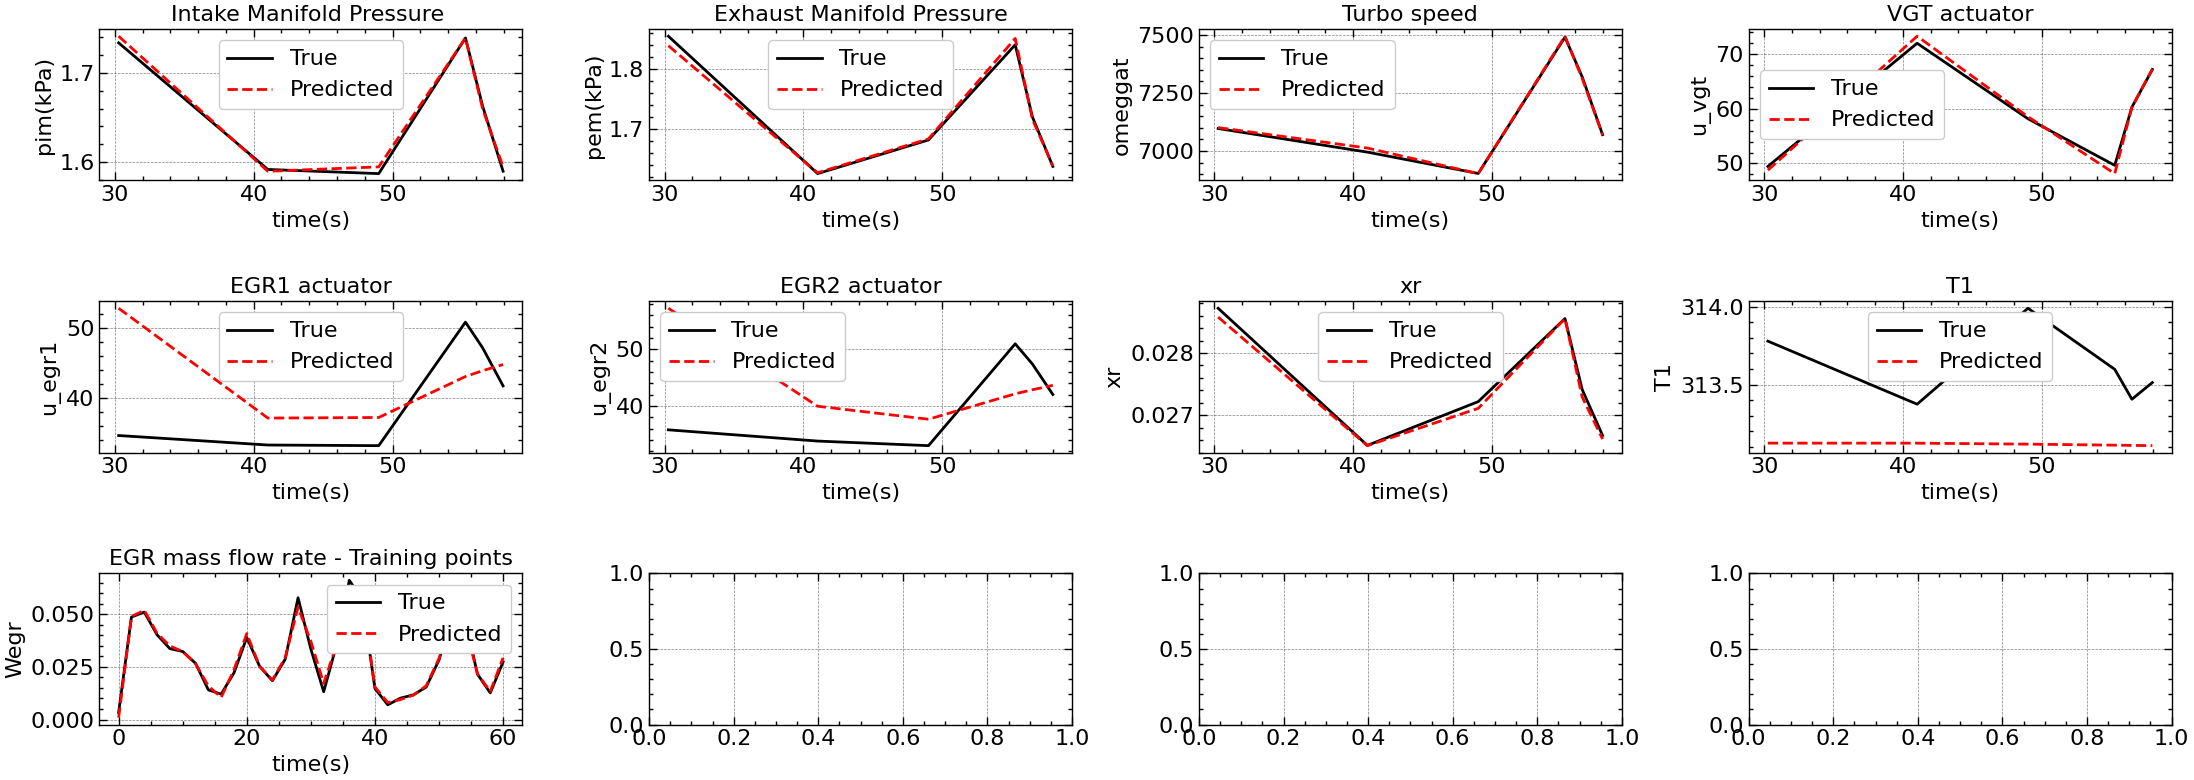

In [119]:
p_pred_test = pinn1(t_test_scaled_tensor)
pim_pred_test = p_pred_test[:,0].view(-1,1)
pem_pred_test = p_pred_test[:,1].view(-1,1)
xr_pred_test = pinn2(t_test_scaled_tensor).view(-1,1)
T1_pred_test = pinn3(t_test_scaled_tensor).view(-1,1)
omeggat_pred_test = pinn5(t_test_scaled_tensor).view(-1,1)

fig, ax = plt.subplots(3, 4, figsize=(22, 8))

ax[0][0].plot(t_test, (1/1e5) * pim_data_test, label = "True", color = 'black')
ax[0][0].plot(t_test, (1/1e5) * pim_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][0].set_ylabel("pim(kPa)")
ax[0][0].set_xlabel("time(s)")
ax[0][0].set_title("Intake Manifold Pressure ")
ax[0][0].legend()

ax[0][1].plot(t_test, (1/1e5) * pem_data_test, label = "True", color = 'black')
ax[0][1].plot(t_test, (1/1e5) * pem_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][1].set_ylabel("pem(kPa)")
ax[0][1].set_xlabel("time(s)")
ax[0][1].set_title("Exhaust Manifold Pressure")
ax[0][1].legend()

ax[0][2].plot(t_test, omegat_data_test, label = "True", color = 'black')
ax[0][2].plot(t_test, omeggat_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][2].set_ylabel("omeggat")
ax[0][2].set_xlabel("time(s)")
ax[0][2].set_title("Turbo speed")
ax[0][2].legend()

ax[0][3].plot(t_test, u_vgt_data_test, label = "True", color = 'black')
ax[0][3].plot(t_test, u_vgt_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][3].set_ylabel("u_vgt")
ax[0][3].set_xlabel("time(s)")
ax[0][3].set_title("VGT actuator")
ax[0][3].legend()

ax[1][0].plot(t_test, u_egr1_data_test, label = "True", color = 'black')
ax[1][0].plot(t_test, u_egr1_pred_test, label = "Predicted", color = 'red', linestyle = '--')
ax[1][0].set_ylabel("u_egr1")
ax[1][0].set_xlabel("time(s)")
ax[1][0].set_title("EGR1 actuator")
ax[1][0].legend()

ax[1][1].plot(t_test, u_egr2_data_test, label = "True", color = 'black')
ax[1][1].plot(t_test, u_egr2_pred_test, label = "Predicted", color = 'red', linestyle = '--')
ax[1][1].set_ylabel("u_egr2")
ax[1][1].set_xlabel("time(s)")
ax[1][1].set_title("EGR2 actuator")
ax[1][1].legend()

ax[1][2].plot(t_test, xr_data_test, label = "True", color = 'black')
ax[1][2].plot(t_test, xr_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][2].set_ylabel("xr")
ax[1][2].set_xlabel("time(s)")
ax[1][2].set_title("xr")
ax[1][2].legend()

ax[1][3].plot(t_test, T1_data_test, label = "True", color = 'black')
ax[1][3].plot(t_test, T1_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][3].set_ylabel("T1")
ax[1][3].set_xlabel("time(s)")
ax[1][3].set_title("T1")
ax[1][3].legend()

ax[2][0].plot(t_train, Wegr_data_train, label = "True", color = 'black')
ax[2][0].plot(t_train, Wegr_pred_data.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[2][0].set_ylabel("Wegr")
ax[2][0].set_xlabel("time(s)")
ax[2][0].set_title("EGR mass flow rate - Training points")
ax[2][0].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.8)
plt.subplots_adjust(wspace=0.3)
plt.show()

In [120]:
pem_data[0]

np.float64(102371.759481181)

#### Improving $PINN5$ - Prediction for $T_1$

##### Preprocessing

In [121]:
# Evaluating PINNS
pinn1.eval()
pinn2.eval()
pinn5.eval()

# Dynamics predictions of state variables in training points

# pim,pem predictions on training points
p_data_train_pred = pinn1(t_physics_scaled_tensor)
pim_data_train_pred = p_data_train_pred[:,0].view(-1,1).detach()
pem_data_train_pred = p_data_train_pred[:,1].view(-1,1).detach()

# omegat predictions on training points
omegat_data_train_pred = pinn5(t_physics_scaled_tensor).detach()

# xr predictions on training points
xr_data_train_pred = pinn2(t_physics_scaled_tensor).detach()

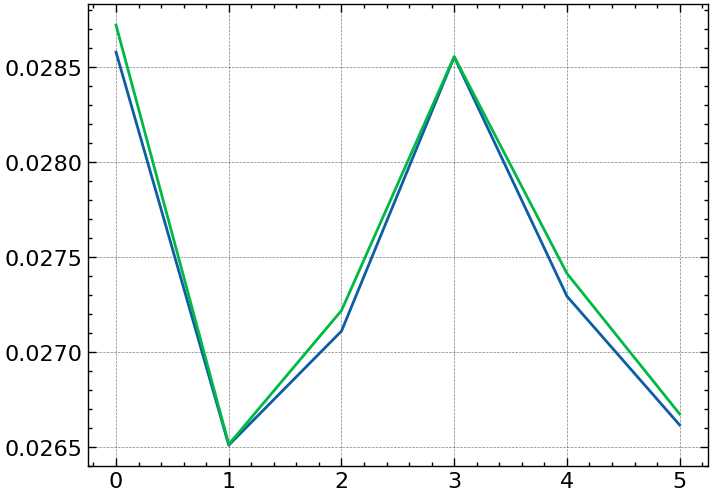

In [122]:
xr_data_test_pred = pinn2(t_test_scaled_tensor).detach()
plt.plot(xr_data_test_pred)
plt.plot(xr_data_test)

##### Training Proccess


Epoch 0/140001
------------------------------------------------------------
IC_loss_T1 = 5.09e+02
Eq_loss_T1 = 1.16e+00
Total PINN3 Loss = 5.10e+02
------------------------------------------------------------


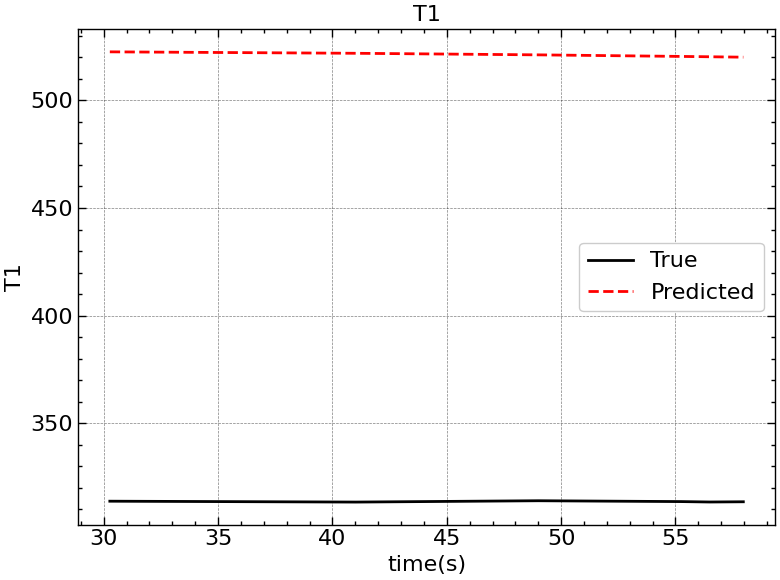


Epoch 5000/140001
------------------------------------------------------------
IC_loss_T1 = 2.38e-07
Eq_loss_T1 = 1.24e-04
Total PINN3 Loss = 1.25e-04
------------------------------------------------------------


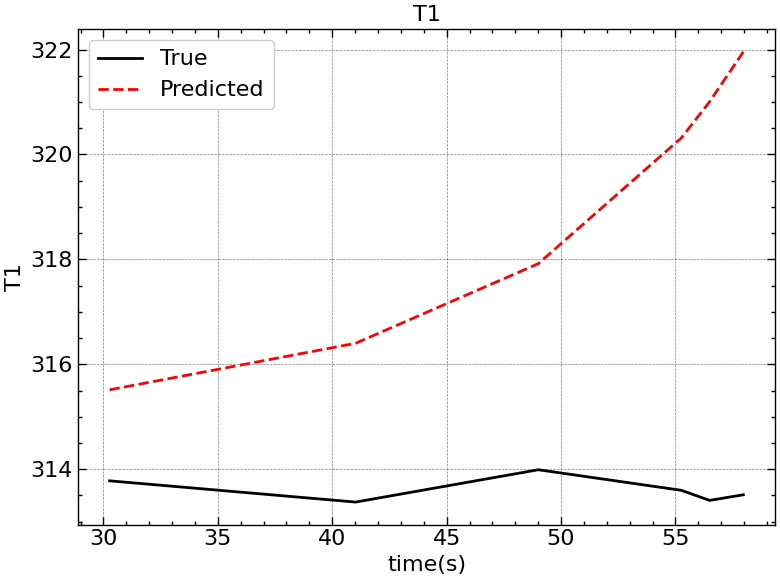


Epoch 10000/140001
------------------------------------------------------------
IC_loss_T1 = 3.73e-09
Eq_loss_T1 = 1.94e-05
Total PINN3 Loss = 1.94e-05
------------------------------------------------------------


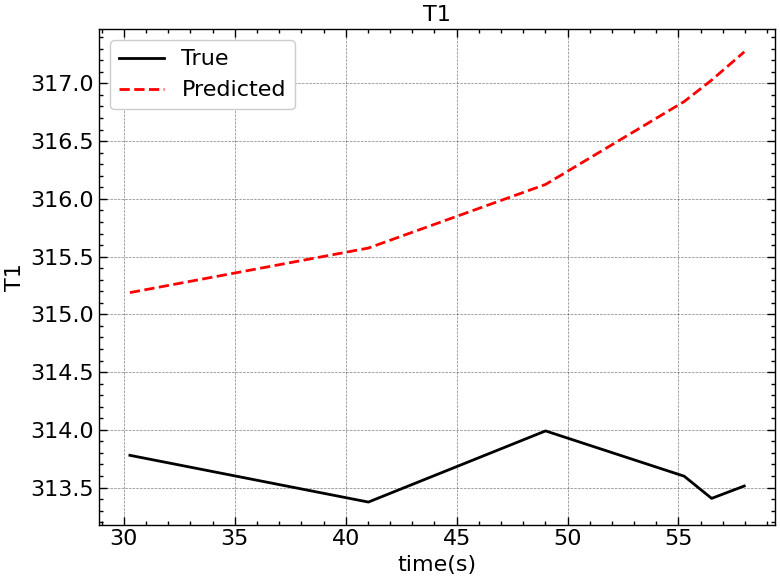


Epoch 15000/140001
------------------------------------------------------------
IC_loss_T1 = 9.31e-12
Eq_loss_T1 = 5.13e-06
Total PINN3 Loss = 5.13e-06
------------------------------------------------------------


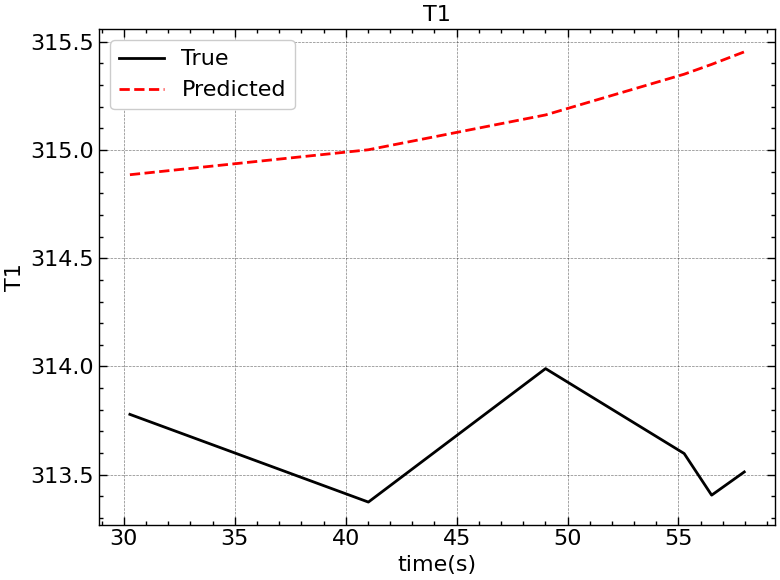


Epoch 20000/140001
------------------------------------------------------------
IC_loss_T1 = 0.00e+00
Eq_loss_T1 = 3.16e-06
Total PINN3 Loss = 3.16e-06
------------------------------------------------------------


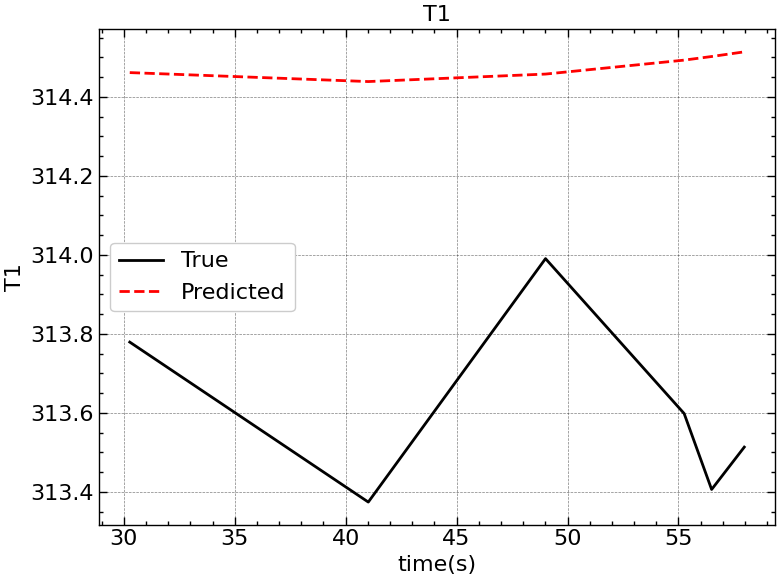


Epoch 25000/140001
------------------------------------------------------------
IC_loss_T1 = 9.31e-10
Eq_loss_T1 = 3.02e-06
Total PINN3 Loss = 3.02e-06
------------------------------------------------------------


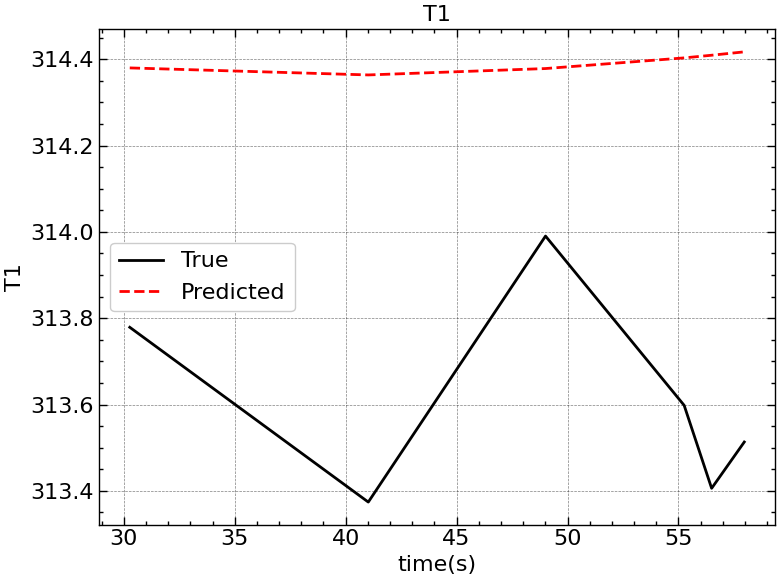


Epoch 30000/140001
------------------------------------------------------------
IC_loss_T1 = 3.73e-11
Eq_loss_T1 = 2.92e-06
Total PINN3 Loss = 2.92e-06
------------------------------------------------------------


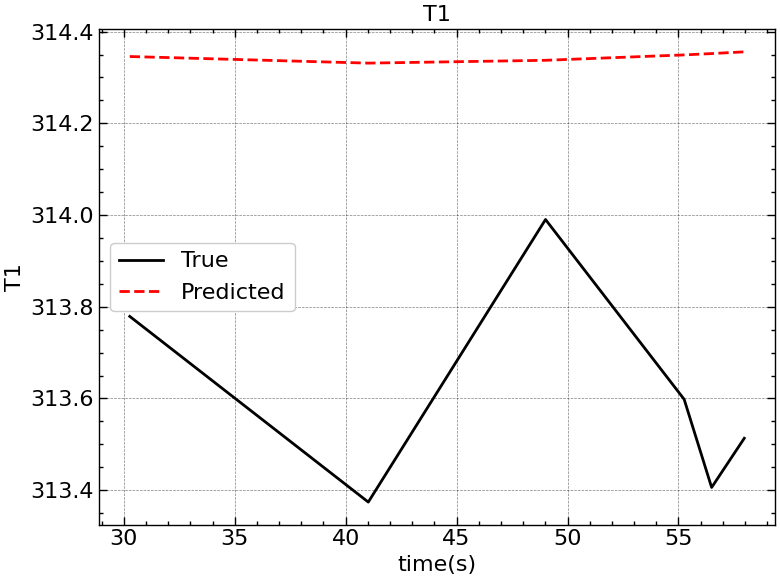


Epoch 35000/140001
------------------------------------------------------------
IC_loss_T1 = 4.11e-09
Eq_loss_T1 = 2.83e-06
Total PINN3 Loss = 2.83e-06
------------------------------------------------------------


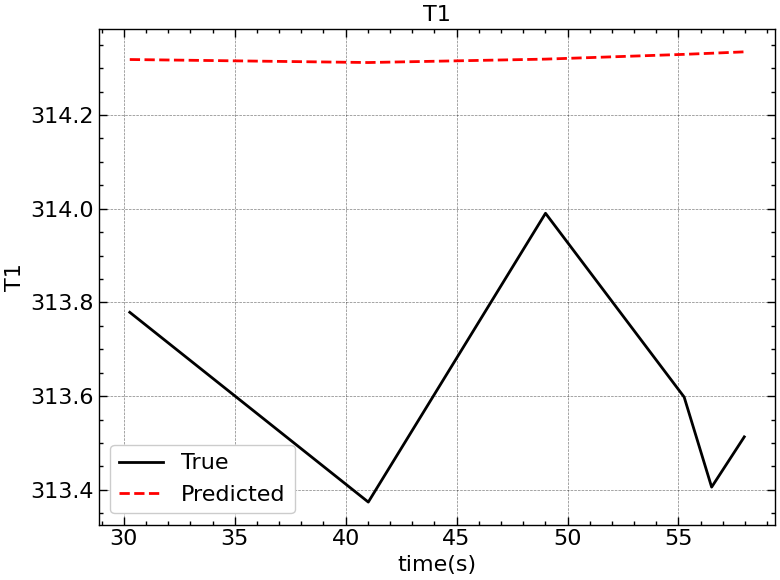


Epoch 40000/140001
------------------------------------------------------------
IC_loss_T1 = 3.35e-10
Eq_loss_T1 = 2.69e-06
Total PINN3 Loss = 2.69e-06
------------------------------------------------------------


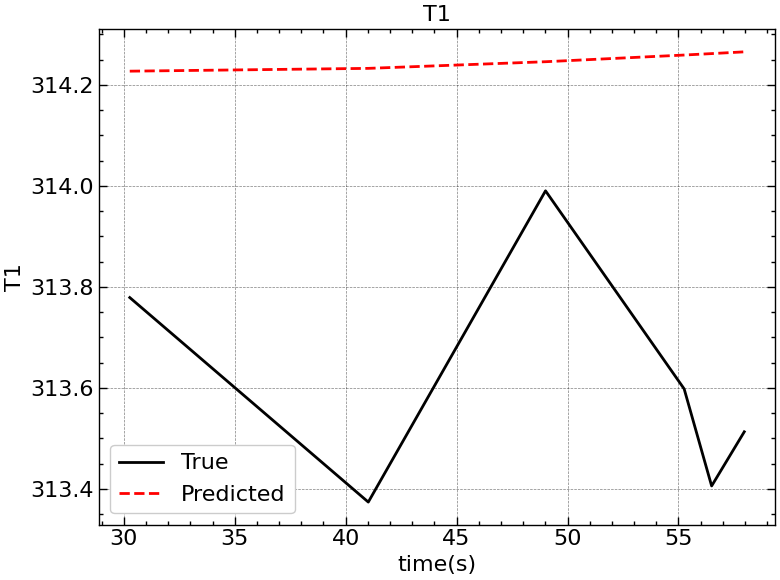


Epoch 45000/140001
------------------------------------------------------------
IC_loss_T1 = 3.36e-09
Eq_loss_T1 = 2.53e-06
Total PINN3 Loss = 2.53e-06
------------------------------------------------------------


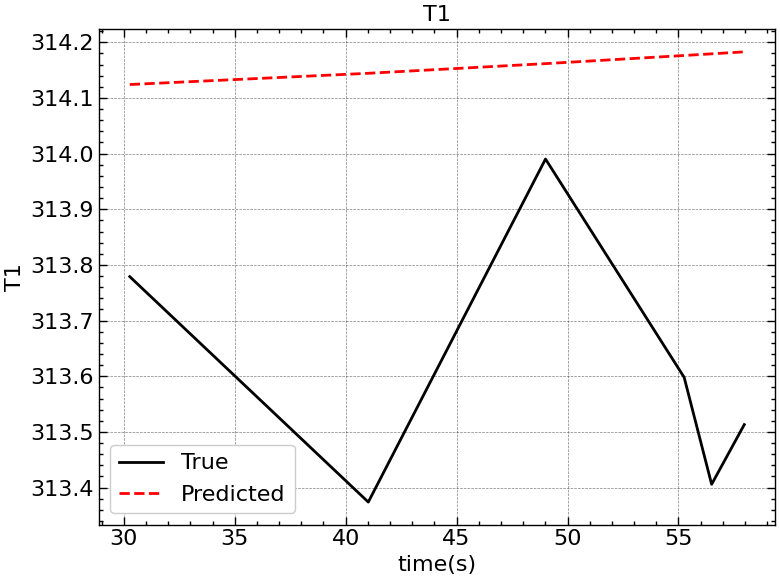


Epoch 50000/140001
------------------------------------------------------------
IC_loss_T1 = 8.95e-09
Eq_loss_T1 = 2.30e-06
Total PINN3 Loss = 2.31e-06
------------------------------------------------------------


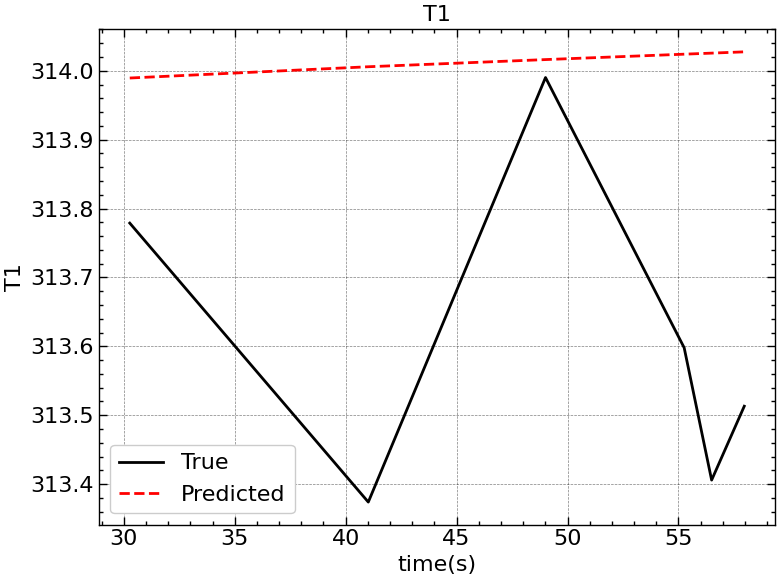


Epoch 55000/140001
------------------------------------------------------------
IC_loss_T1 = 3.35e-10
Eq_loss_T1 = 2.14e-06
Total PINN3 Loss = 2.14e-06
------------------------------------------------------------


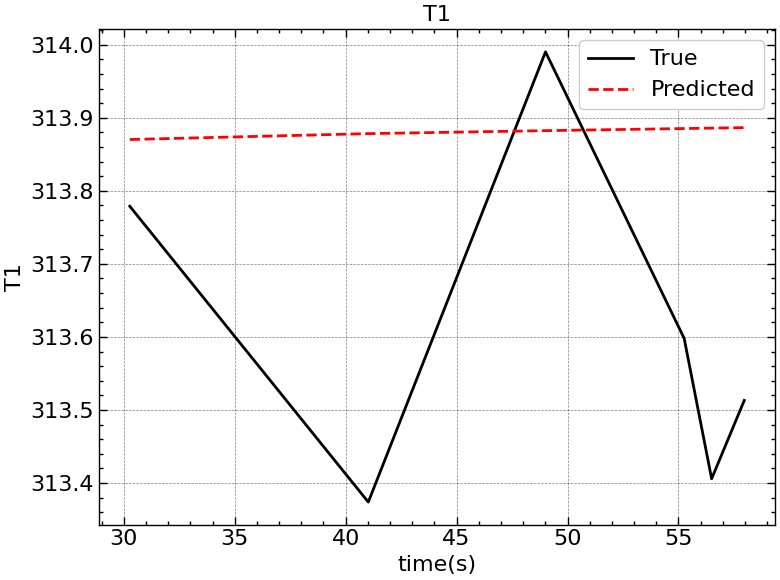


Epoch 60000/140001
------------------------------------------------------------
IC_loss_T1 = 3.35e-08
Eq_loss_T1 = 2.13e-06
Total PINN3 Loss = 2.16e-06
------------------------------------------------------------


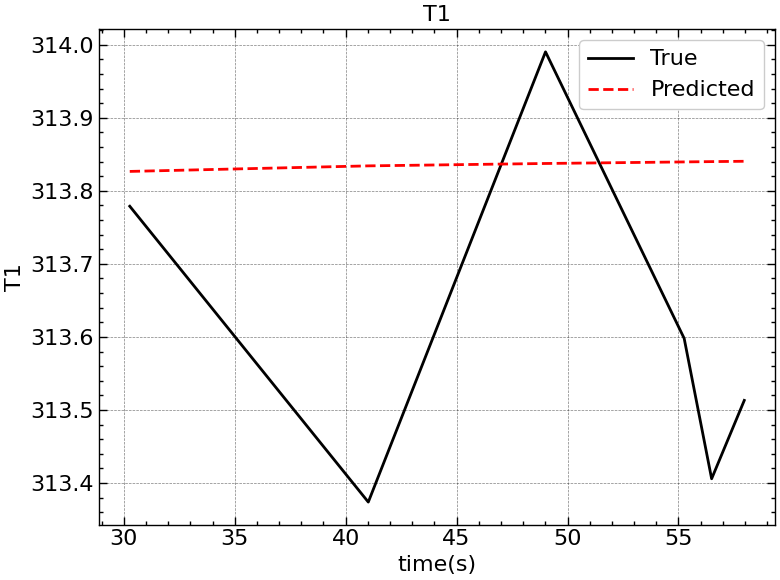


Epoch 65000/140001
------------------------------------------------------------
IC_loss_T1 = 1.34e-09
Eq_loss_T1 = 2.10e-06
Total PINN3 Loss = 2.11e-06
------------------------------------------------------------


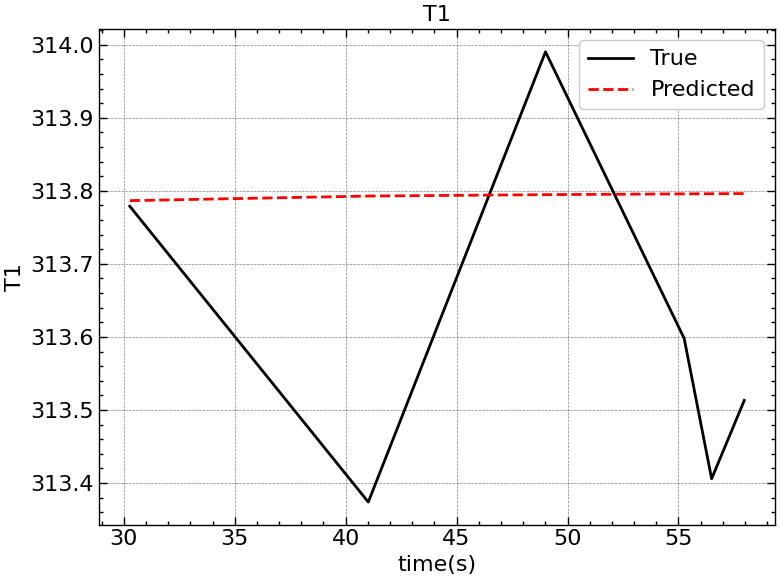


Epoch 70000/140001
------------------------------------------------------------
IC_loss_T1 = 3.61e-07
Eq_loss_T1 = 2.09e-06
Total PINN3 Loss = 2.45e-06
------------------------------------------------------------


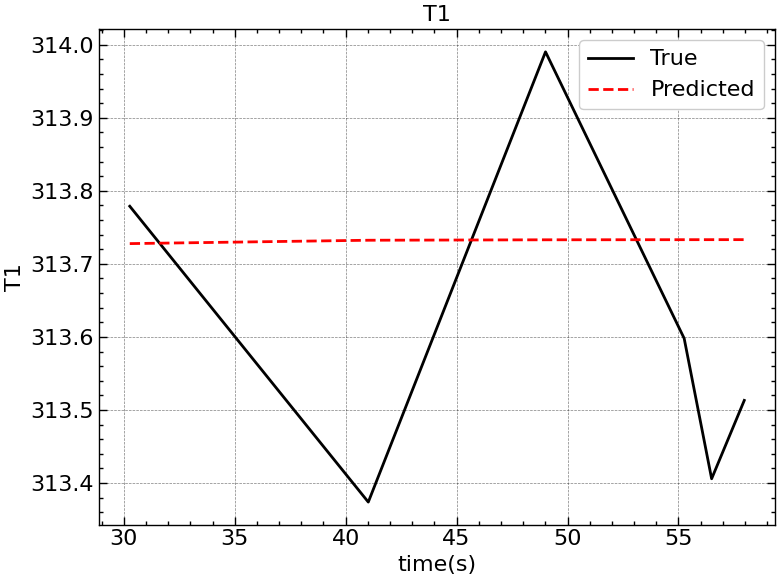


Epoch 75000/140001
------------------------------------------------------------
IC_loss_T1 = 7.54e-08
Eq_loss_T1 = 2.06e-06
Total PINN3 Loss = 2.14e-06
------------------------------------------------------------


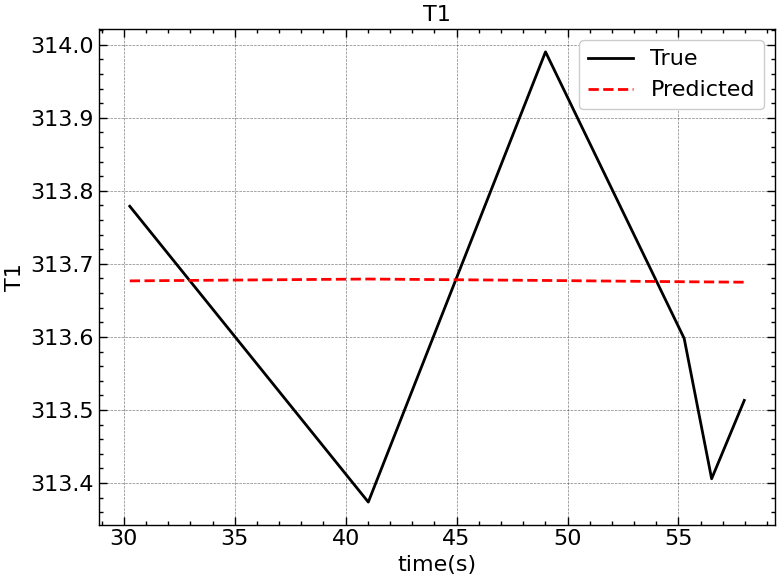


Epoch 80000/140001
------------------------------------------------------------
IC_loss_T1 = 1.13e-09
Eq_loss_T1 = 2.06e-06
Total PINN3 Loss = 2.06e-06
------------------------------------------------------------


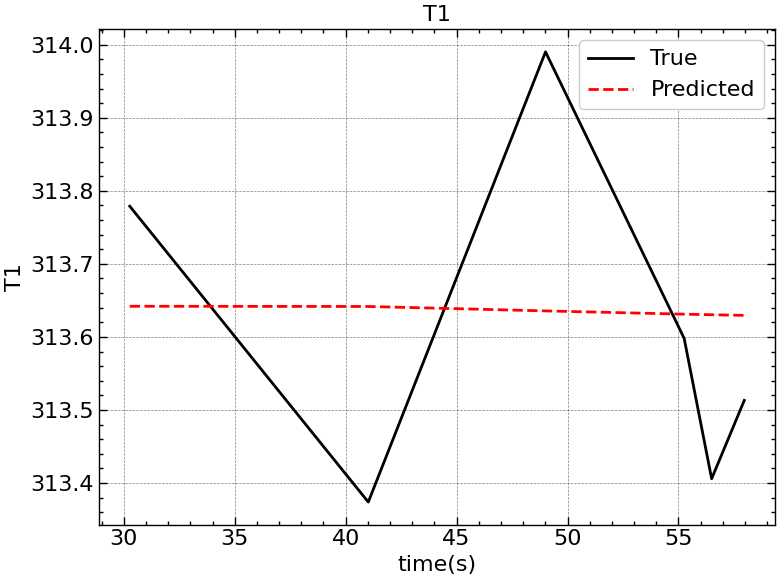


Epoch 85000/140001
------------------------------------------------------------
IC_loss_T1 = 1.21e-08
Eq_loss_T1 = 2.05e-06
Total PINN3 Loss = 2.06e-06
------------------------------------------------------------


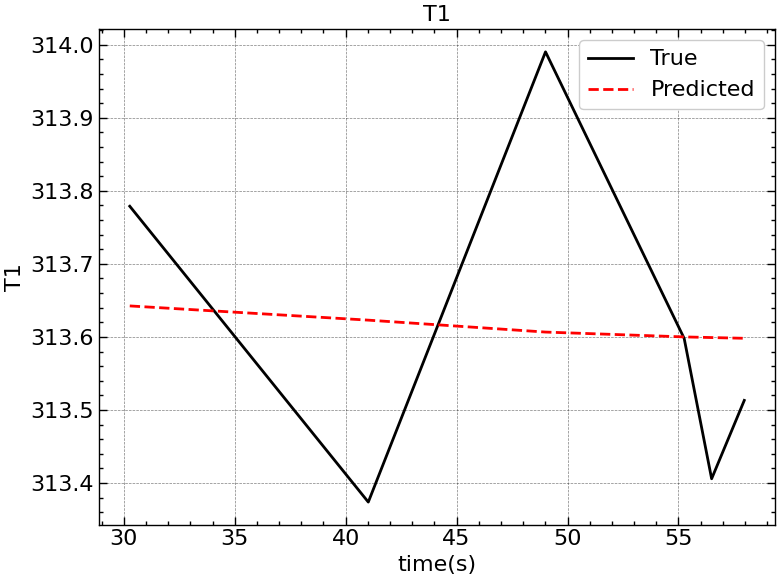


Epoch 90000/140001
------------------------------------------------------------
IC_loss_T1 = 2.33e-10
Eq_loss_T1 = 2.32e-07
Total PINN3 Loss = 2.33e-07
------------------------------------------------------------


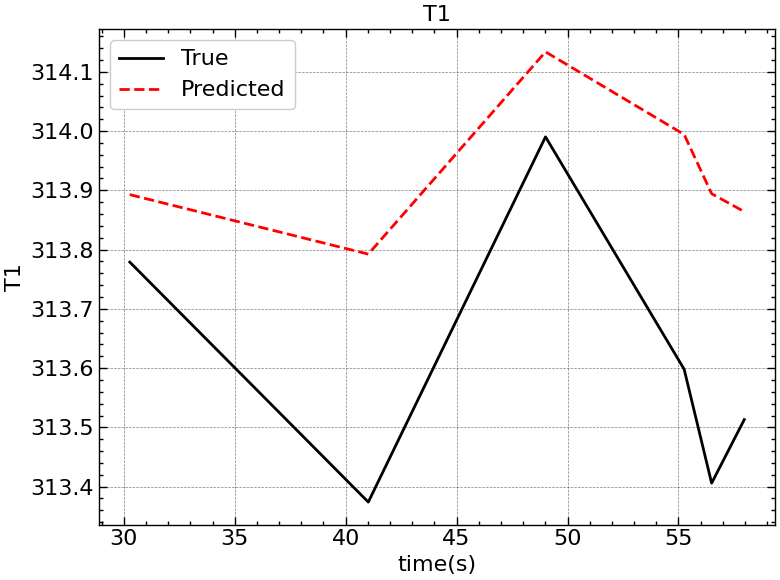


Epoch 95000/140001
------------------------------------------------------------
IC_loss_T1 = 2.42e-08
Eq_loss_T1 = 3.69e-08
Total PINN3 Loss = 6.11e-08
------------------------------------------------------------


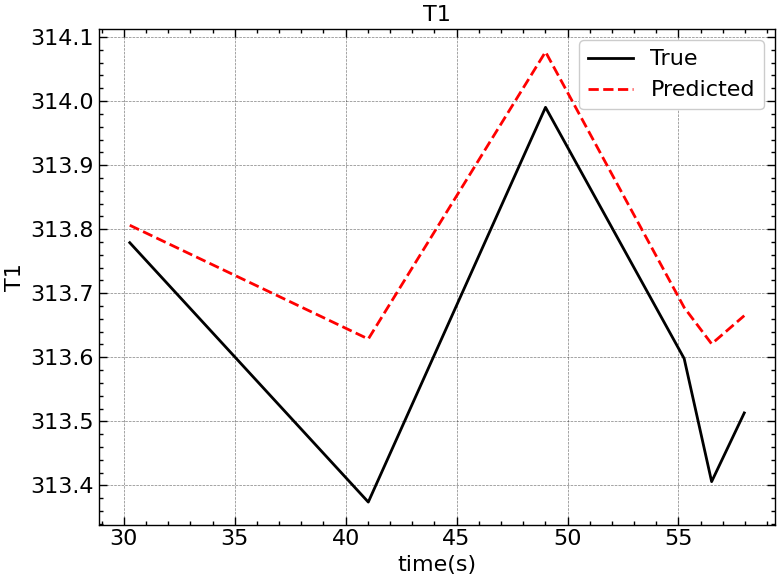


Epoch 100000/140001
------------------------------------------------------------
IC_loss_T1 = 6.26e-08
Eq_loss_T1 = 2.27e-08
Total PINN3 Loss = 8.53e-08
------------------------------------------------------------


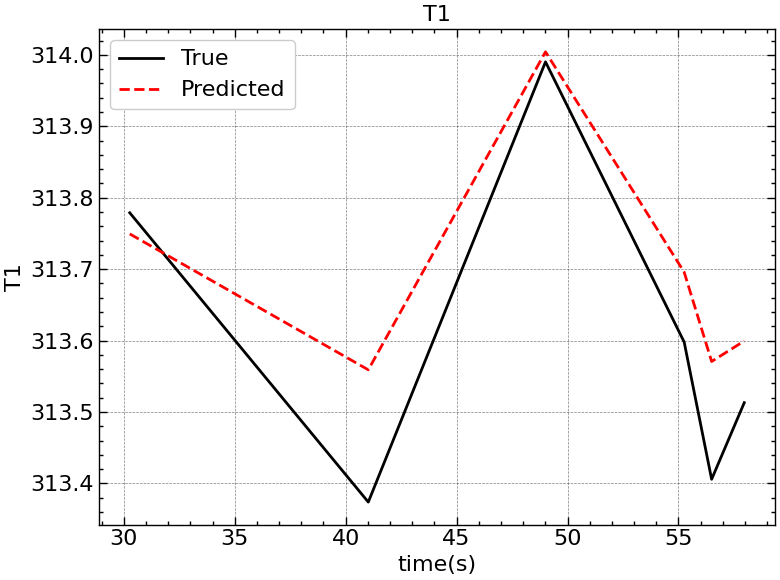


Epoch 105000/140001
------------------------------------------------------------
IC_loss_T1 = 5.96e-10
Eq_loss_T1 = 1.33e-08
Total PINN3 Loss = 1.39e-08
------------------------------------------------------------


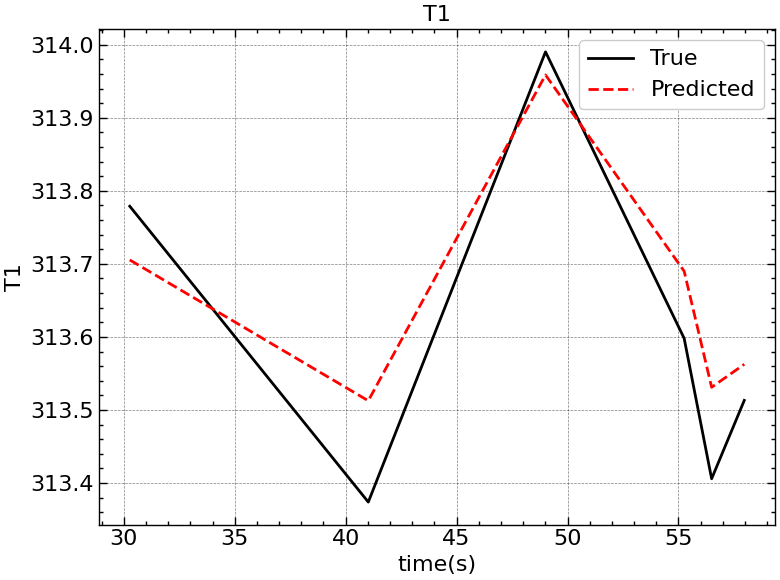


Epoch 110000/140001
------------------------------------------------------------
IC_loss_T1 = 1.34e-09
Eq_loss_T1 = 1.02e-08
Total PINN3 Loss = 1.15e-08
------------------------------------------------------------


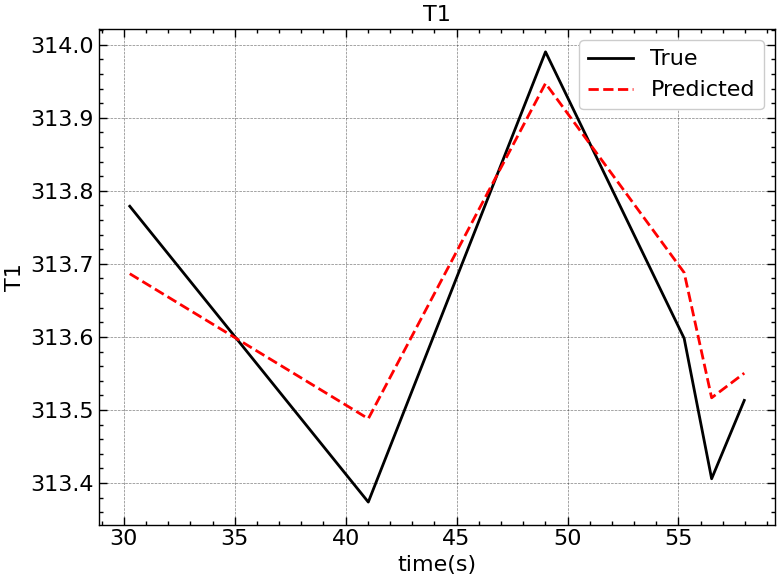


Epoch 115000/140001
------------------------------------------------------------
IC_loss_T1 = 3.70e-08
Eq_loss_T1 = 5.61e-09
Total PINN3 Loss = 4.26e-08
------------------------------------------------------------


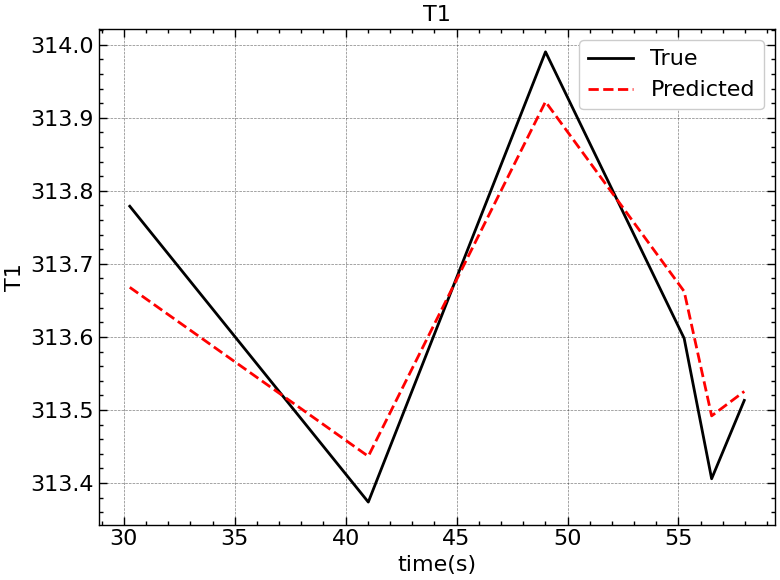


Epoch 120000/140001
------------------------------------------------------------
IC_loss_T1 = 4.56e-10
Eq_loss_T1 = 4.27e-09
Total PINN3 Loss = 4.73e-09
------------------------------------------------------------


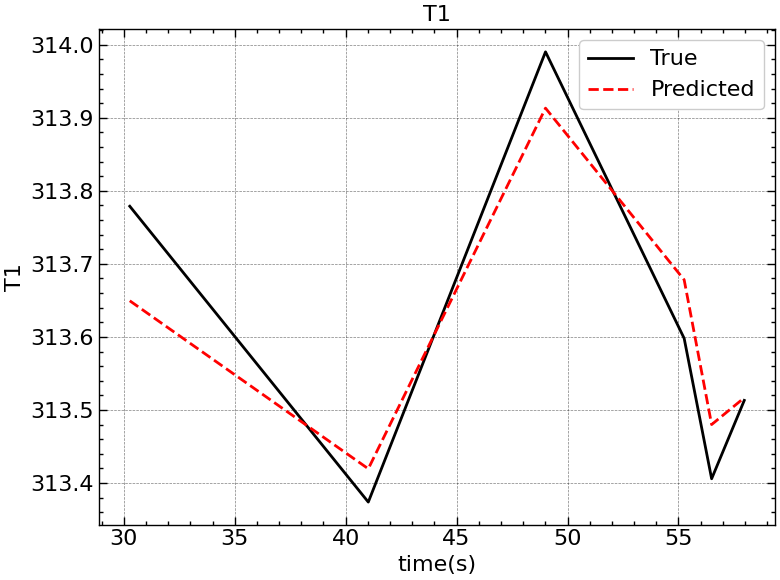


Epoch 125000/140001
------------------------------------------------------------
IC_loss_T1 = 1.57e-09
Eq_loss_T1 = 3.45e-09
Total PINN3 Loss = 5.02e-09
------------------------------------------------------------


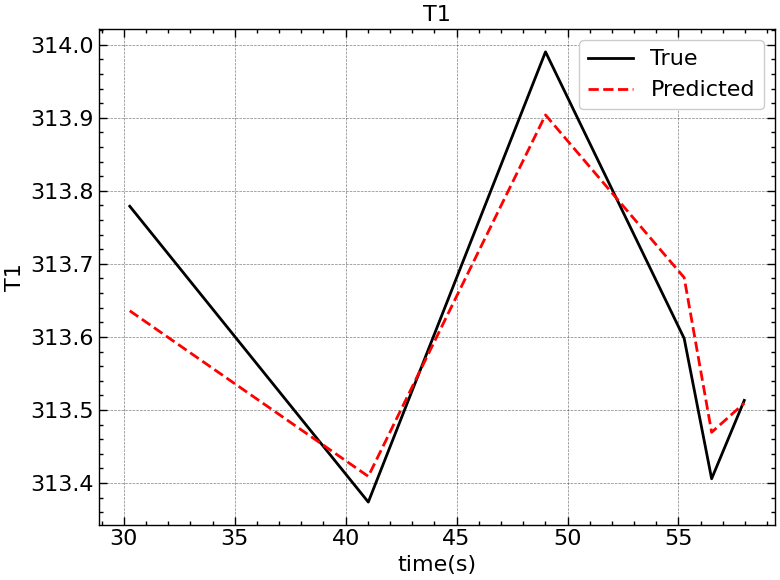


Epoch 130000/140001
------------------------------------------------------------
IC_loss_T1 = 4.51e-07
Eq_loss_T1 = 3.90e-09
Total PINN3 Loss = 4.55e-07
------------------------------------------------------------


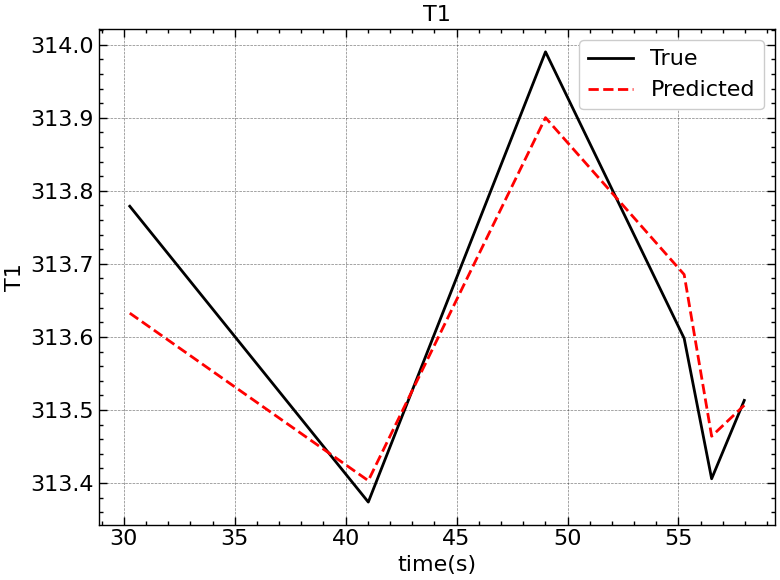


Epoch 135000/140001
------------------------------------------------------------
IC_loss_T1 = 9.54e-09
Eq_loss_T1 = 2.51e-09
Total PINN3 Loss = 1.20e-08
------------------------------------------------------------


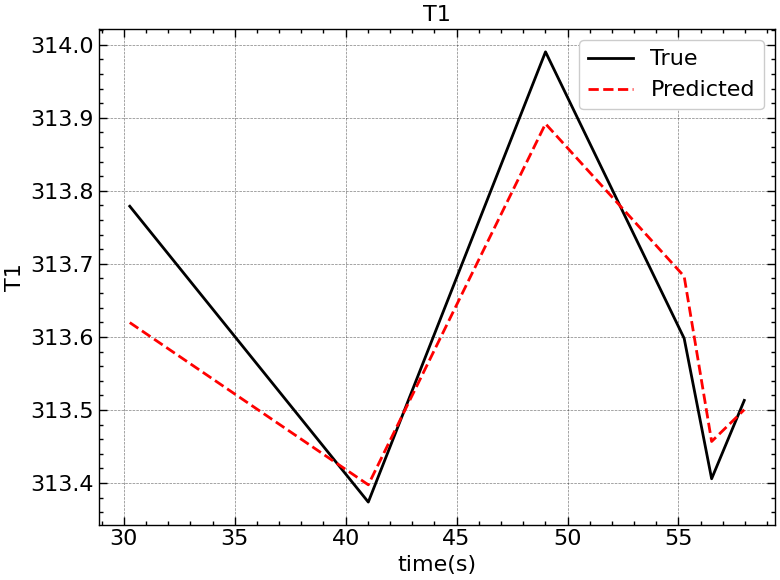


Epoch 140000/140001
------------------------------------------------------------
IC_loss_T1 = 2.38e-09
Eq_loss_T1 = 2.08e-09
Total PINN3 Loss = 4.47e-09
------------------------------------------------------------


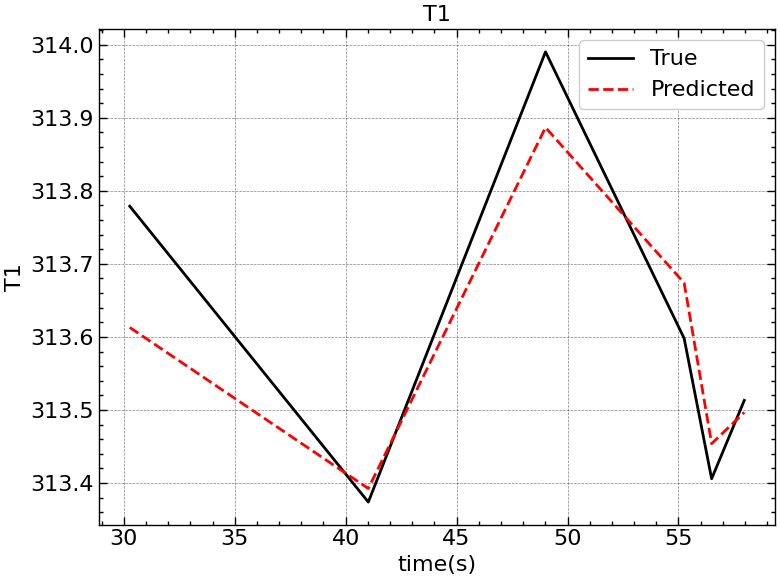

Training complete. Best test loss: 1.88e-09


In [123]:
# ---------- Setup (unchanged) ----------
pinn3 = FFN3(1, 1, 64)  # T1

# Learnable parameters
hsc = torch.nn.Parameter(torch.tensor([1.0], dtype=torch.float32, requires_grad=True))

# Optimizer
optimizer = optim.Adam(list(pinn3.parameters()) + [hsc], lr=0.001)

# Training hyperparams
num_epochs = 140001
print_every = 5000

best_test_loss = float('inf')

MSE_Loss = nn.MSELoss()
Loss_history_PINN3_new = []
hsc_values = []

FFNN1_PT.eval()  

for epoch in range(num_epochs):
     
    pinn3.train()
    optimizer.zero_grad()

    # ---- Initial condition loss ----
    T1_pred_boundary = pinn3(t_boundary_scaled_tensor)
    IC_loss_T1 = MSE_Loss(
        torch.squeeze(T1_pred_boundary),
        torch.full_like(torch.squeeze(T1_pred_boundary), T1_data_train[0])
    )
    
    # eta_vol
    pim_data_train_pred_norm = normalize_tensor_0_1(pim_data_train_pred)
    input_tensor_eta_vol = torch.cat((pim_data_train_pred_norm, ne_physics_tensor_norm), dim=1)
    eta_vol_data_train_pred = FFNN1_PT(input_tensor_eta_vol).detach()
    
    # T1 prediction dynamics on training points (physics)
    T1_pred_physics = pinn3(t_physics_scaled_tensor).view(-1, 1)
    
    Wei = (eta_vol_data_train_pred * pim_data_train_pred * ne_physics_tensor * Vd) / (120 * Ra * Tim)
    Wf = 1e-6 * u_delta_physics_tensor * ne_physics_tensor * ncyl / 120
    Weo = (Wei + Wf)
    Pe = pem_data_train_pred / pim_data_train_pred
    qin = (Wf * qHV * (1 - xr_data_train_pred)) / (Wei + Wf)  
    xp = (1 + (qin * xcv) / (cva * T1_pred_physics * (rc ** (gamma_a - 1))))
    xv = (1 + qin * (1 - xcv) / (cpa * ((qin * xcv / cva) + T1_pred_physics * (rc ** (gamma_a - 1)))))
    Pe = pem_data_train_pred/pim_data_train_pred
    Te = (hsc * (Pe ** (1 - 1 / gamma_a)) * (rc ** (1 - gamma_a)) *
          (xp ** (1 / gamma_a - 1)) *
          (qin * ((1 - xcv) / cpa + xcv / cva) + T1_pred_physics * (rc ** (gamma_a - 1))))


    # residual and physics loss (only depends on T1_pred_physics, hsc)
    res_T1 = T1_pred_physics - (xr_data_train_pred * Te + (1 - xr_data_train_pred) * Tim)
    Eq_loss_T1 = torch.mean(res_T1 ** 2)

    # ---- Weighted loss and backward ----
    lambda_ic_T1, lambda_eq_T1 = 1e-2, 1e-4 / 4
    IC_loss_T1_weighted = lambda_ic_T1 * IC_loss_T1
    Eq_loss_T1_weighted = lambda_eq_T1 * Eq_loss_T1

    PINN3_loss = IC_loss_T1_weighted + Eq_loss_T1_weighted
    Total_loss_T1 = PINN3_loss

    # single backward for the graph containing pinn3, hsc
    Total_loss_T1.backward()
    optimizer.step()

    # ---- Tracking ----
    Loss_history_PINN3_new.append(PINN3_loss.item())
    hsc_values.append(hsc.item())
    

    # ---- Logging & plotting ----
    if epoch % print_every == 0:
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 60)
        print(f"IC_loss_T1 = {IC_loss_T1_weighted:.2e}")
        print(f"Eq_loss_T1 = {Eq_loss_T1_weighted:.2e}")
        print(f"Total PINN3 Loss = {PINN3_loss:.2e}")
        print("-" * 60)

        pinn3.eval()
        with torch.no_grad():
            T1_pred_test = pinn3(t_test_scaled_tensor).view(-1, 1)
    
        plt.plot(t_test, T1_data_test, label="True", color='black')
        plt.plot(t_test, T1_pred_test.detach().cpu().numpy(), label="Predicted", color='red', linestyle='--')
        plt.ylabel("T1")
        plt.xlabel("time(s)")
        plt.title("T1")
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        pinn3.train()  # Switch back to training mode

    if PINN3_loss.item() < best_test_loss:
        best_test_loss = PINN3_loss.item()
        best_model_wts = FFNN1_PT.state_dict()

FFNN1_PT.load_state_dict(best_model_wts)
print(f"Training complete. Best test loss: {best_test_loss:.2e}")

### Unknown Parameters

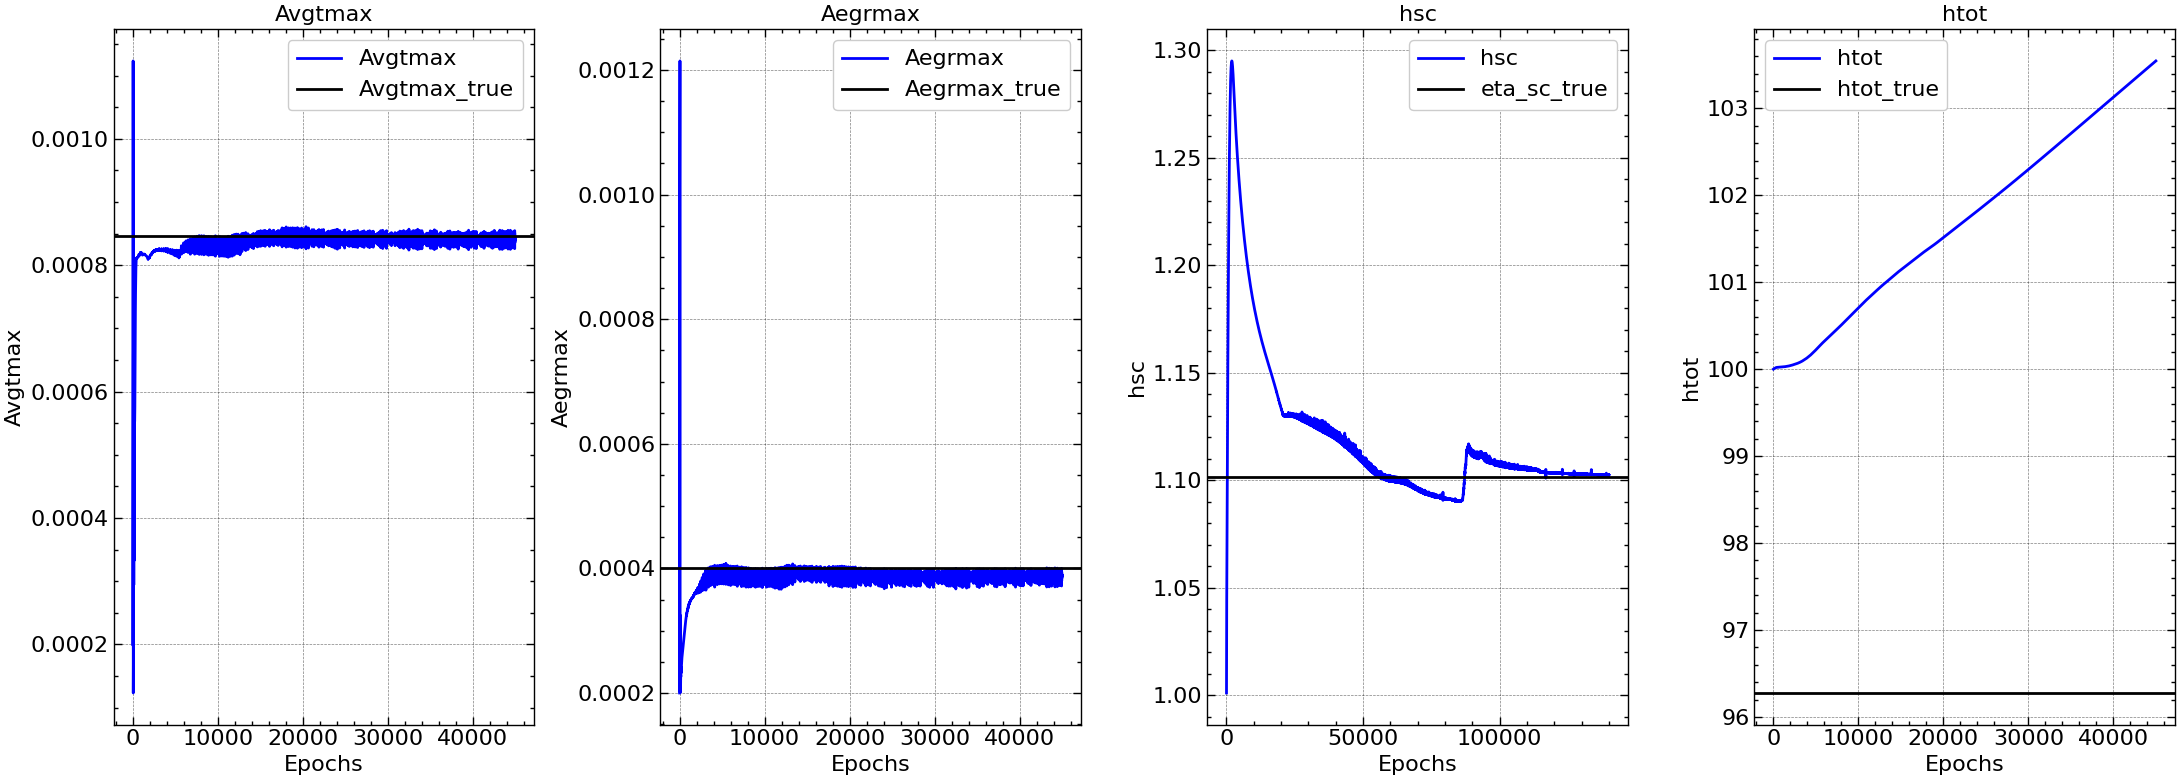

In [124]:
# Plottintg the predicted values of the unknown parameters
fig, ax = plt.subplots(1, 4, figsize=(22, 8))
ax[0].plot(Avgtmax_values, label = "Avgtmax", color = 'blue')
ax[0].axhline(Avgtmax_true, color='black', label='Avgtmax_true')
ax[0].set_ylabel("Avgtmax")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Avgtmax")
ax[0].legend()

ax[1].plot(Aegrmax_values, label = "Aegrmax", color = 'blue')
ax[1].axhline(Aegrmax_true, color='black', label='Aegrmax_true')
ax[1].set_ylabel("Aegrmax")
ax[1].set_xlabel("Epochs")
ax[1].set_title("Aegrmax")
ax[1].legend()

ax[2].plot(hsc_values, label = "hsc", color = 'blue')
ax[2].axhline(eta_sc_true, color='black', label='eta_sc_true')
ax[2].set_ylabel("hsc")
ax[2].set_xlabel("Epochs")
ax[2].set_title("hsc")
ax[2].legend()

ax[3].plot(htot_values, label = "htot", color = 'blue')
ax[3].axhline(htot_true, label = "htot_true", color = 'black')
ax[3].set_ylabel("htot")
ax[3].set_xlabel("Epochs")
ax[3].set_title("htot")
ax[3].legend()
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
plt.show()

# Results

## State Variables

### Training Points

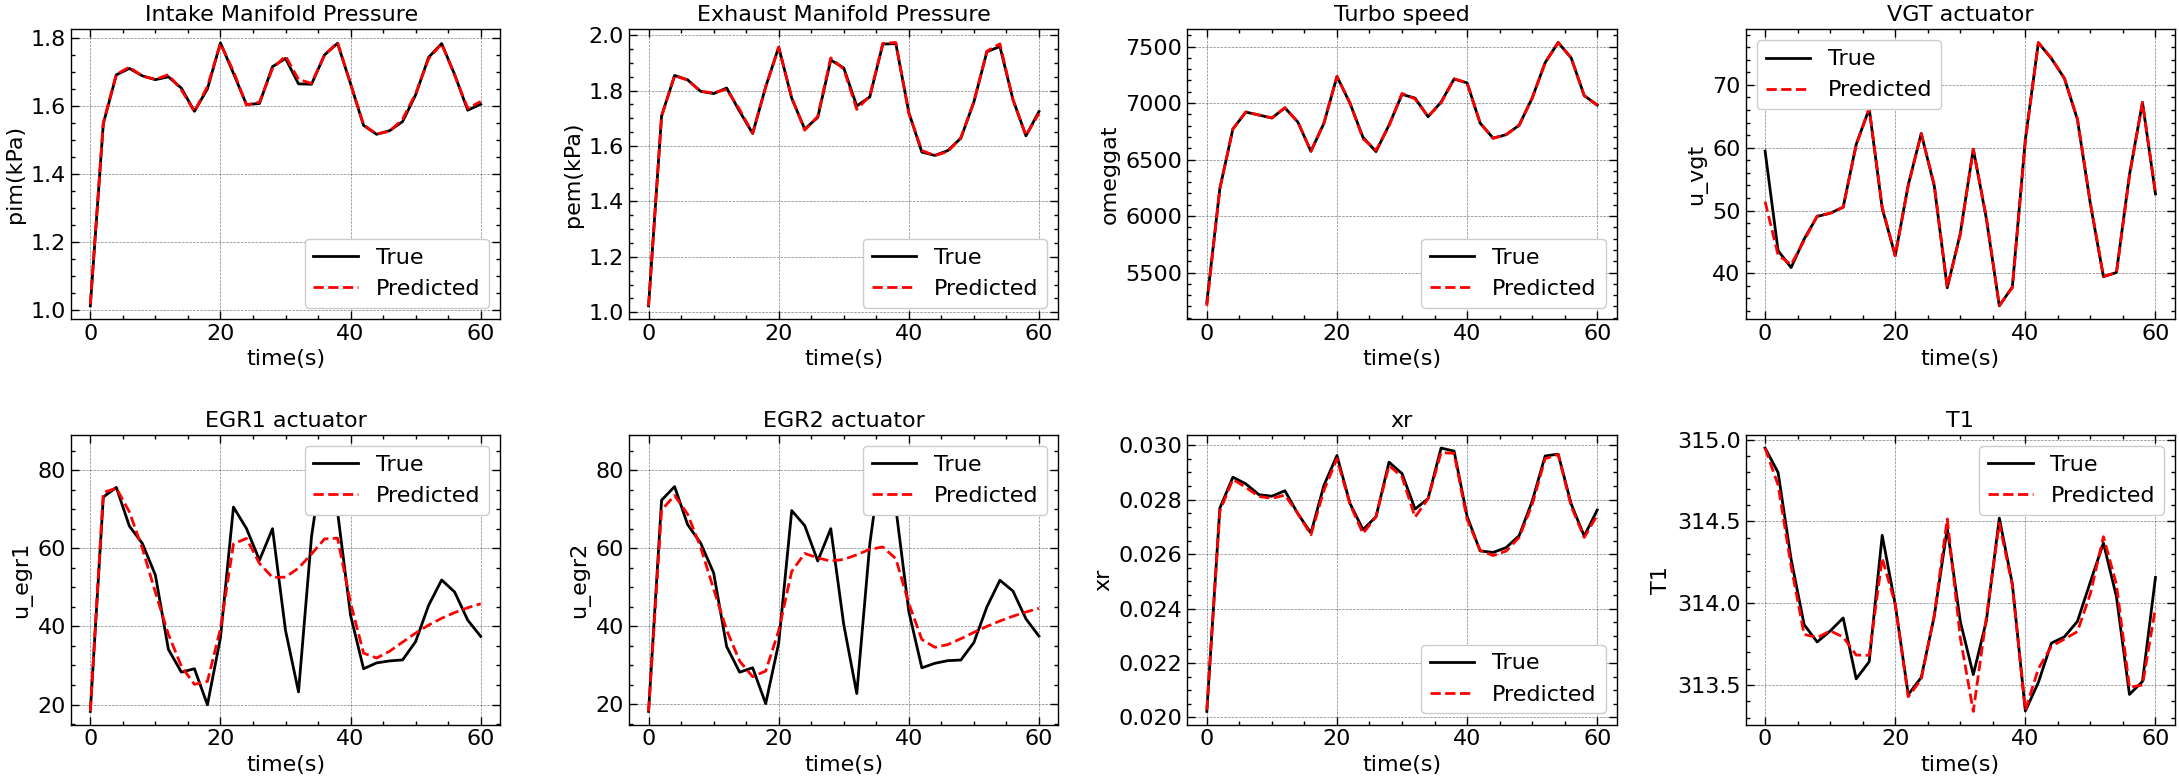

In [125]:
# pim, pem 
p_pred_physics = pinn1(t_physics_scaled_tensor)
pim_pred_physics = p_pred_physics[:,0].view(-1,1)
pem_pred_physics = p_pred_physics[:,1].view(-1,1)

# omeggat
omeggat_pred_physics = pinn5(t_physics_scaled_tensor).view(-1,1)

# u_egr1, u_egr2
u_egr_pred_physics = pinn4(t_physics_scaled_tensor)
u_egr1_pred_physics = u_egr_pred_physics[:,0].view(-1,1)
u_egr2_pred_physics = u_egr_pred_physics[:,1].view(-1,1)

# u_vgt
u_vgt_pred_physics = pinn6(t_physics_scaled_tensor).view(-1,1)

# T1
T1_pred_physics = pinn3(t_physics_scaled_tensor).view(-1,1)

# xr
xr_pred_physics = pinn2(t_physics_scaled_tensor).view(-1,1)

# Plotting the state variables
fig, ax = plt.subplots(2, 4, figsize=(22, 8))
ax[0][0].plot(t_data, (1/1e5) * pim_data_train, label = "True", color = 'black')
ax[0][0].plot(t_physics, (1/1e5) * pim_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][0].set_ylabel("pim(kPa)")
ax[0][0].set_xlabel("time(s)")
ax[0][0].set_title("Intake Manifold Pressure ")
ax[0][0].legend()

ax[0][1].plot(t_data, (1/1e5) * pem_data_train, label = "True", color = 'black')
ax[0][1].plot(t_physics, (1/1e5) * pem_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][1].set_ylabel("pem(kPa)")
ax[0][1].set_xlabel("time(s)")
ax[0][1].set_title("Exhaust Manifold Pressure")
ax[0][1].legend()

ax[0][2].plot(t_data, omegat_data_train, label = "True", color = 'black')
ax[0][2].plot(t_physics, omeggat_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][2].set_ylabel("omeggat")
ax[0][2].set_xlabel("time(s)")
ax[0][2].set_title("Turbo speed")
ax[0][2].legend()

ax[0][3].plot(t_data, u_vgt_data_train_tensor.detach().numpy(), label = "True", color = 'black')
ax[0][3].plot(t_physics, u_vgt_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][3].set_ylabel("u_vgt")
ax[0][3].set_xlabel("time(s)")
ax[0][3].set_title("VGT actuator")
ax[0][3].legend()

ax[1][0].plot(t_data, u_egr1_data_train_tensor.detach().numpy(), label = "True", color = 'black')
ax[1][0].plot(t_physics, u_egr1_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][0].set_ylabel("u_egr1")
ax[1][0].set_xlabel("time(s)")
ax[1][0].set_title("EGR1 actuator")
ax[1][0].legend()

ax[1][1].plot(t_data, u_egr2_data_train_tensor.detach().numpy(), label = "True", color = 'black')
ax[1][1].plot(t_physics, u_egr2_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][1].set_ylabel("u_egr2")
ax[1][1].set_xlabel("time(s)")
ax[1][1].set_title("EGR2 actuator")
ax[1][1].legend()

ax[1][2].plot(t_data, xr_data_train, label = "True", color = 'black')
ax[1][2].plot(t_physics, xr_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][2].set_ylabel("xr")
ax[1][2].set_xlabel("time(s)")
ax[1][2].set_title("xr")
ax[1][2].legend()

ax[1][3].plot(t_data, T1_data_train, label = "True", color = 'black')
ax[1][3].plot(t_physics, T1_pred_physics.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][3].set_ylabel("T1")
ax[1][3].set_xlabel("time(s)")
ax[1][3].set_title("T1")
ax[1][3].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
plt.show()

### Testing Points

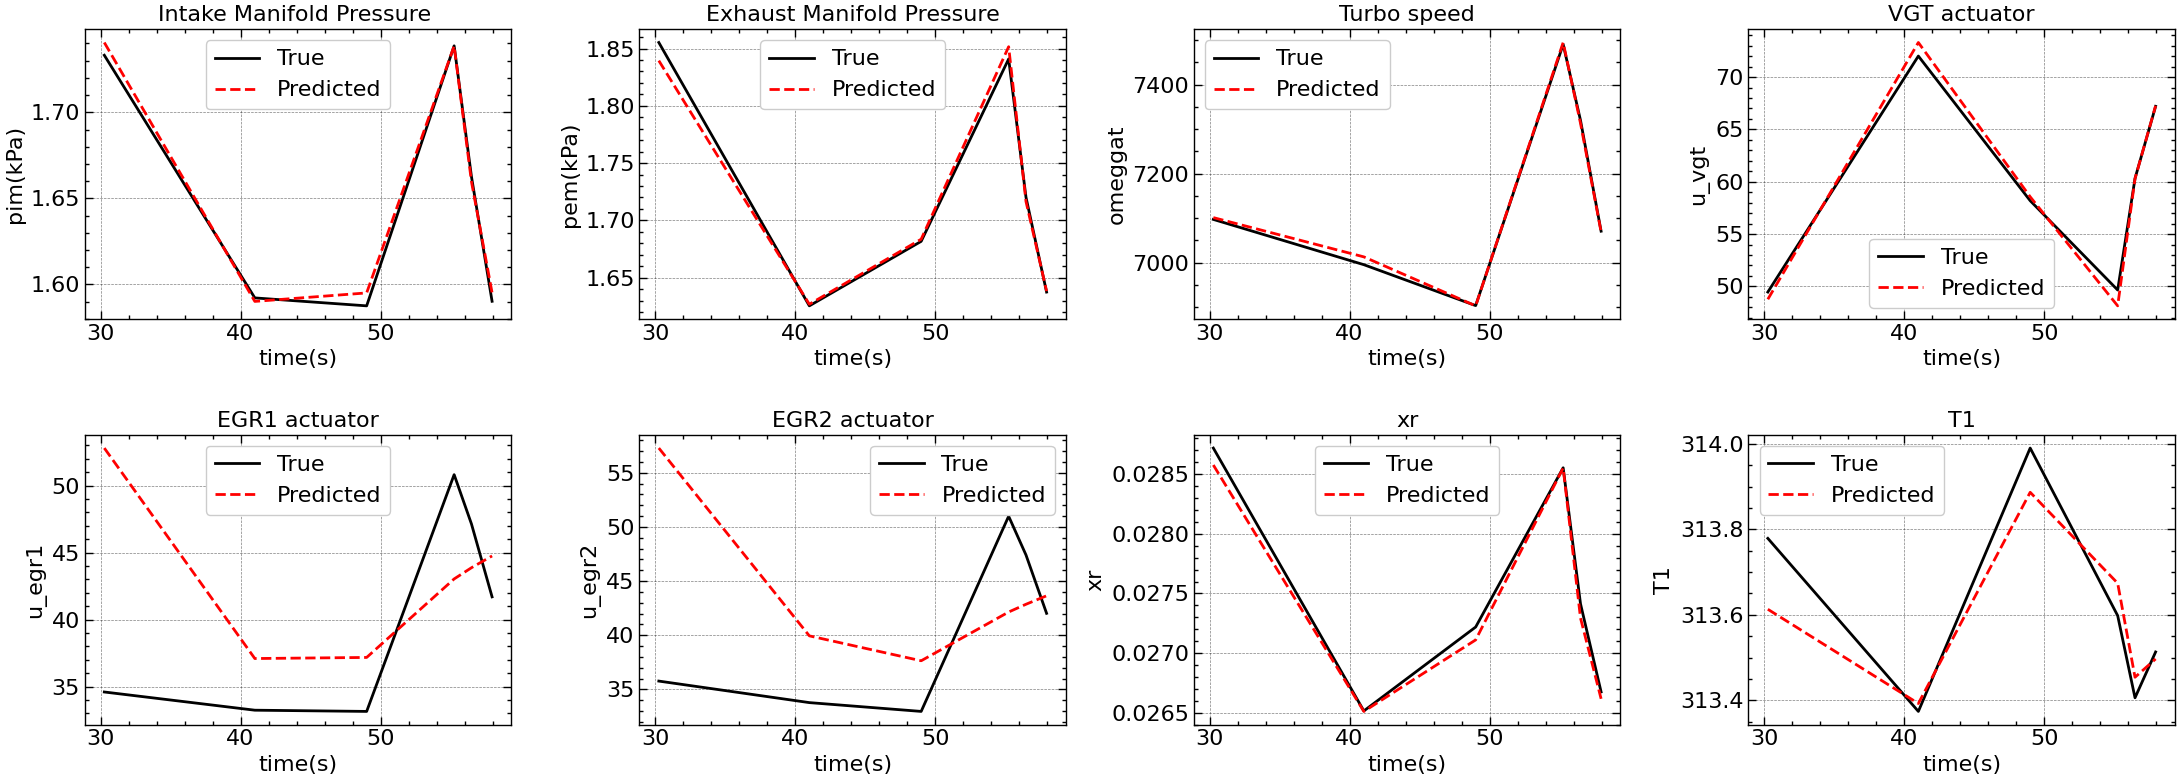

In [126]:
# pim, pem predictions on testing points
p_pred_test = pinn1(t_test_scaled_tensor)
pim_pred_test = p_pred_test[:,0].view(-1,1)
pem_pred_test = p_pred_test[:,1].view(-1,1)

# omeggat
omeggat_pred_test = pinn5(t_test_scaled_tensor).view(-1,1)

# u_egr1, u_egr2
u_egr_pred_test = pinn4(t_test_scaled_tensor)
u_egr1_pred_test = u_egr_pred_test[:,0].view(-1,1)
u_egr2_pred_test = u_egr_pred_test[:,1].view(-1,1)

# u_vgt
u_vgt_pred_test = pinn6(t_test_scaled_tensor).view(-1,1)

# T1
T1_pred_test = pinn3(t_test_scaled_tensor).view(-1,1)

# xr
xr_pred_test = pinn2(t_test_scaled_tensor).view(-1,1)

# Plotting the state variables
fig, ax = plt.subplots(2, 4, figsize=(22, 8))
ax[0][0].plot(t_test, (1/1e5) * pim_data_test, label = "True", color = 'black')
ax[0][0].plot(t_test, (1/1e5) * pim_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][0].set_ylabel("pim(kPa)")
ax[0][0].set_xlabel("time(s)")
ax[0][0].set_title("Intake Manifold Pressure ")
ax[0][0].legend()

ax[0][1].plot(t_test, (1/1e5) * pem_data_test, label = "True", color = 'black')
ax[0][1].plot(t_test, (1/1e5) * pem_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][1].set_ylabel("pem(kPa)")
ax[0][1].set_xlabel("time(s)")
ax[0][1].set_title("Exhaust Manifold Pressure")
ax[0][1].legend()

ax[0][2].plot(t_test, omegat_data_test, label = "True", color = 'black')
ax[0][2].plot(t_test, omeggat_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][2].set_ylabel("omeggat")
ax[0][2].set_xlabel("time(s)")
ax[0][2].set_title("Turbo speed")
ax[0][2].legend()

ax[0][3].plot(t_test, u_vgt_data_test, label = "True", color = 'black')
ax[0][3].plot(t_test, u_vgt_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[0][3].set_ylabel("u_vgt")
ax[0][3].set_xlabel("time(s)")
ax[0][3].set_title("VGT actuator")
ax[0][3].legend()

ax[1][0].plot(t_test, u_egr1_data_test, label = "True", color = 'black')
ax[1][0].plot(t_test, u_egr1_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][0].set_ylabel("u_egr1")
ax[1][0].set_xlabel("time(s)")
ax[1][0].set_title("EGR1 actuator")
ax[1][0].legend()

ax[1][1].plot(t_test, u_egr2_data_test, label = "True", color = 'black')
ax[1][1].plot(t_test, u_egr2_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][1].set_ylabel("u_egr2")
ax[1][1].set_xlabel("time(s)")
ax[1][1].set_title("EGR2 actuator")
ax[1][1].legend()

ax[1][2].plot(t_test, xr_data_test, label = "True", color = 'black')
ax[1][2].plot(t_test, xr_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][2].set_ylabel("xr")
ax[1][2].set_xlabel("time(s)")
ax[1][2].set_title("xr")
ax[1][2].legend()

ax[1][3].plot(t_test, T1_data_test, label = "True", color = 'black')
ax[1][3].plot(t_test, T1_pred_test.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
ax[1][3].set_ylabel("T1")
ax[1][3].set_xlabel("time(s)")
ax[1][3].set_title("T1")
ax[1][3].legend()

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.subplots_adjust(wspace=0.3)
plt.show()




### Performance on unseen data

#### $p_{im}$

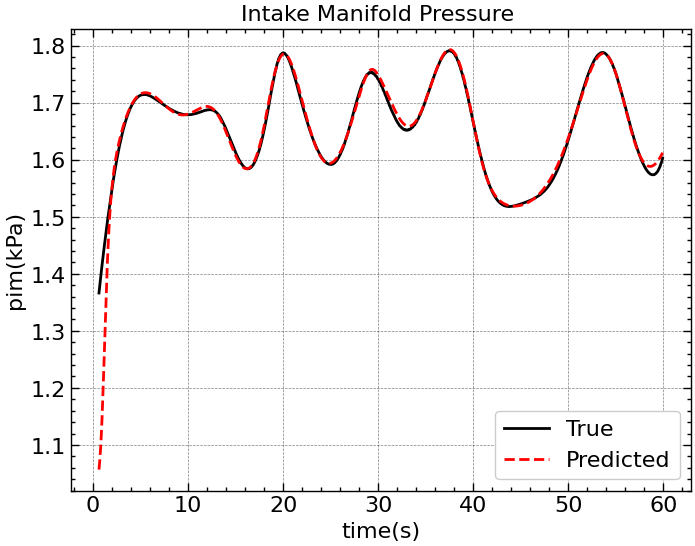

In [127]:
pinn1.eval()
p_pred_evaluation = pinn1(t_eval_scaled_tensor)
pim_pred_evaluation = p_pred_evaluation[:,0].view(-1,1)
pem_pred_evaluation = p_pred_evaluation[:,1].view(-1,1)


plt.plot(df_evaluation['Time'].to_numpy(), (1/1e5) * df_evaluation['pim'].to_numpy(), label = "True", color = 'black')
plt.plot(t_eval, (1/1e5) * pim_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("pim(kPa)")
plt.xlabel("time(s)")
plt.title("Intake Manifold Pressure ")
plt.legend()

#### $p_{em}$

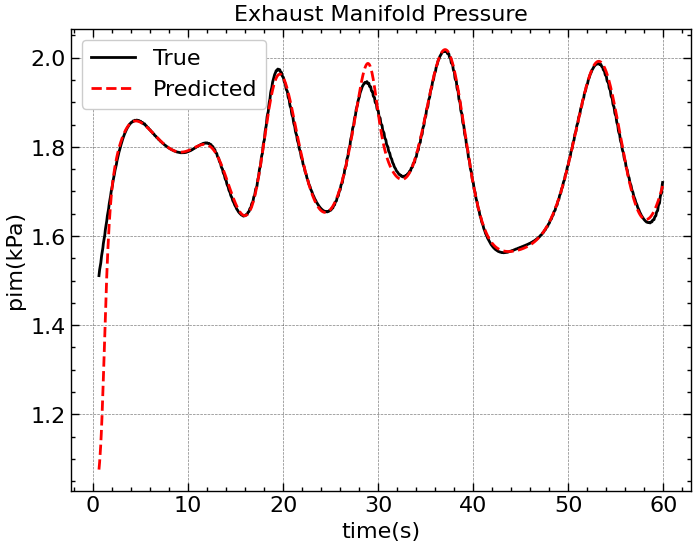

In [128]:
pinn1.eval()
p_pred_evaluation = pinn1(t_eval_scaled_tensor)
pim_pred_evaluation = p_pred_evaluation[:,0].view(-1,1)
pem_pred_evaluation = p_pred_evaluation[:,1].view(-1,1)


plt.plot(df_evaluation['Time'].to_numpy(), (1/1e5) * df_evaluation['pem'].to_numpy(), label = "True", color = 'black')
plt.plot(t_eval, (1/1e5) * pem_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("pim(kPa)")
plt.xlabel("time(s)")
plt.title("Exhaust Manifold Pressure")
plt.legend()

#### $\omega_{t}$

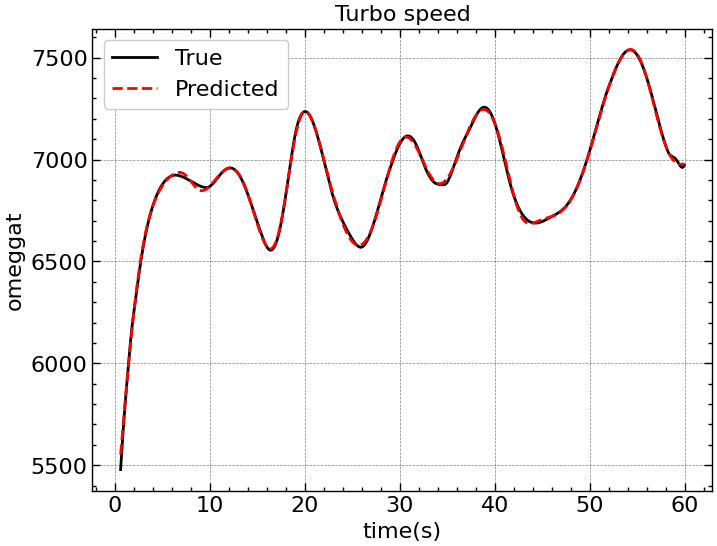

In [129]:
pinn5.eval()

omegat_pred_evaluation = pinn5(t_eval_scaled_tensor).view(-1,1)

plt.plot(t_eval, omegat_data_eval, label = "True", color = 'black')
plt.plot(t_eval, omegat_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("omeggat")
plt.xlabel("time(s)")
plt.title("Turbo speed")
plt.legend()
plt.show()

#### $\tilde{u}_{egr1}$

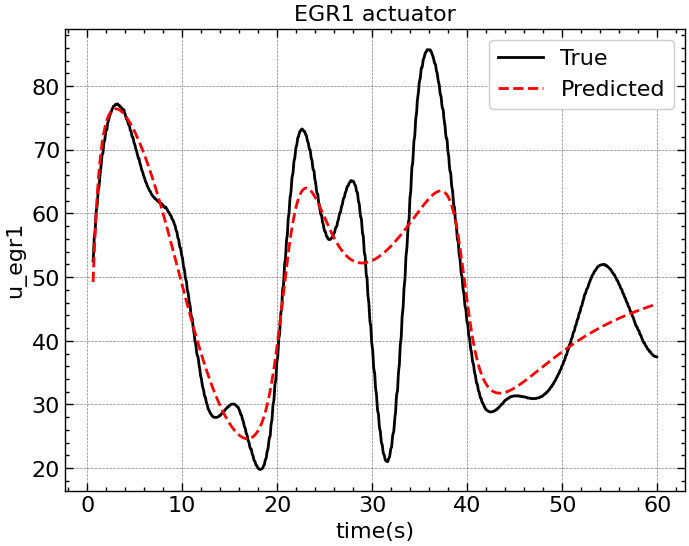

In [130]:
pinn4.eval()

u_egr_data_evaluation_pred= pinn4(t_eval_scaled_tensor)
u_egr1_pred_eval = u_egr_data_evaluation_pred[:,0].view(-1,1)
u_egr2_pred_eval = u_egr_data_evaluation_pred[:,1].view(-1,1)

plt.plot(t_eval, u_egr1_data_eval, label = "True", color = 'black')
plt.plot(t_eval, u_egr1_pred_eval.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("u_egr1")
plt.xlabel("time(s)")
plt.title("EGR1 actuator")
plt.legend()    
plt.show()

#### $\tilde{u}_{egr2}$

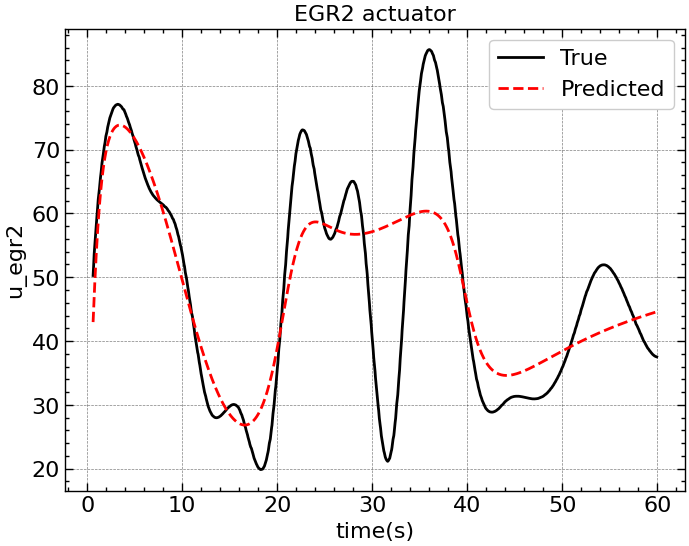

In [131]:
pinn4.eval()

u_egr_data_evaluation_pred= pinn4(t_eval_scaled_tensor)
u_egr1_pred_eval = u_egr_data_evaluation_pred[:,0].view(-1,1)
u_egr2_pred_eval = u_egr_data_evaluation_pred[:,1].view(-1,1)

plt.plot(t_eval, u_egr2_data_eval, label = "True", color = 'black')
plt.plot(t_eval, u_egr2_pred_eval.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("u_egr2")
plt.xlabel("time(s)")
plt.title("EGR2 actuator")
plt.legend()    
plt.show()

#### $\tilde{u}_{vgt}$

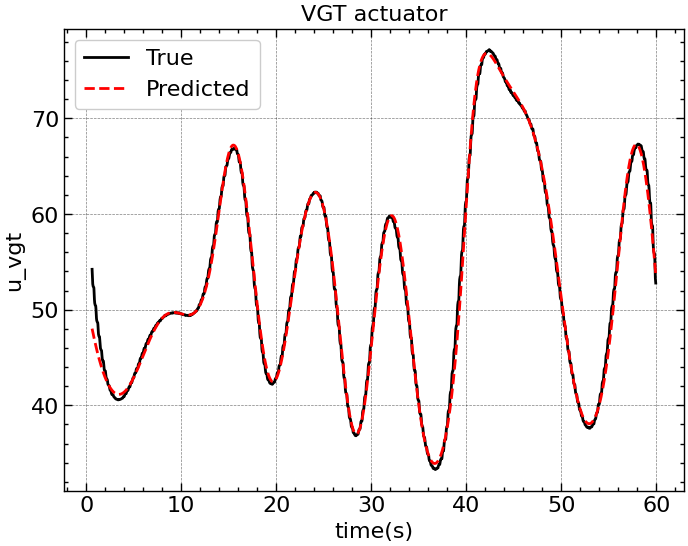

In [132]:
pinn6.eval()
u_vgt_pred_evaluation = pinn6(t_eval_scaled_tensor).view(-1,1)

plt.plot(t_eval, u_vgt_data_eval, label = "True", color = 'black')
plt.plot(t_eval, u_vgt_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("u_vgt")
plt.xlabel("time(s)")
plt.title("VGT actuator")
plt.legend()
plt.show()

#### $T_1$

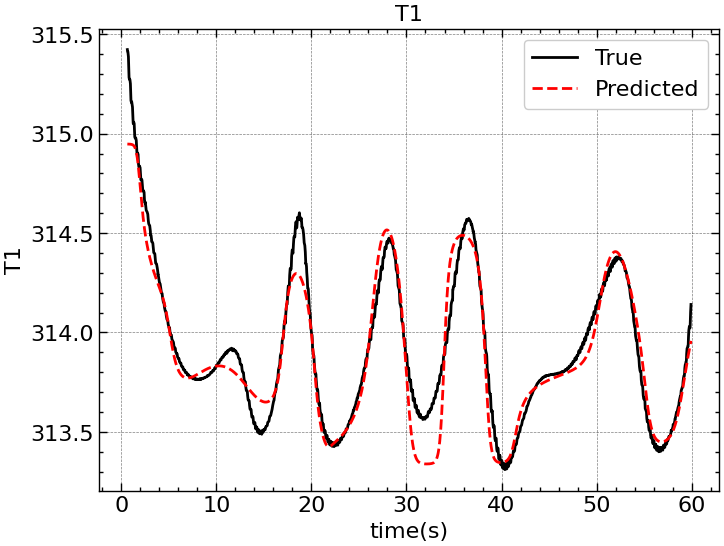

In [133]:
pinn3.eval()

T1_pred_evaluation = pinn3(t_eval_scaled_tensor).view(-1,1)
plt.plot(df_evaluation['Time'].to_numpy(), df_evaluation['T1'].to_numpy(), label = "True", color = 'black')
plt.plot(t_eval, T1_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("T1")
plt.xlabel("time(s)")
plt.title("T1")
plt.legend()
plt.show()

#### $x_r$

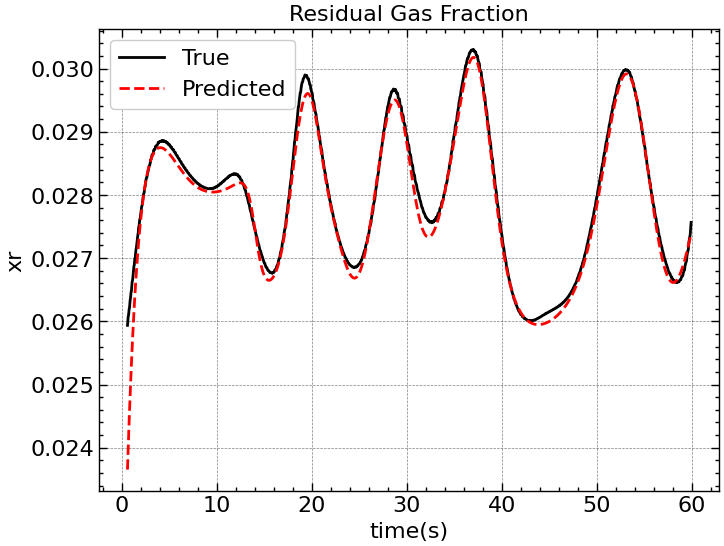

In [134]:
pinn2.eval()

xr_pred_evaluation = pinn2(t_eval_scaled_tensor).view(-1,1)
plt.plot(df_evaluation['Time'].to_numpy(), df_evaluation['xr'].to_numpy(), label = "True", color = 'black')
plt.plot(t_eval, xr_pred_evaluation.detach().numpy(), label = "Predicted", color = 'red', linestyle = '--')
plt.ylabel("xr")
plt.xlabel("time(s)")
plt.title("Residual Gas Fraction")
plt.legend()
plt.show()

## Unknown Parameters

### Plots

#### $A_{vgtmax}$

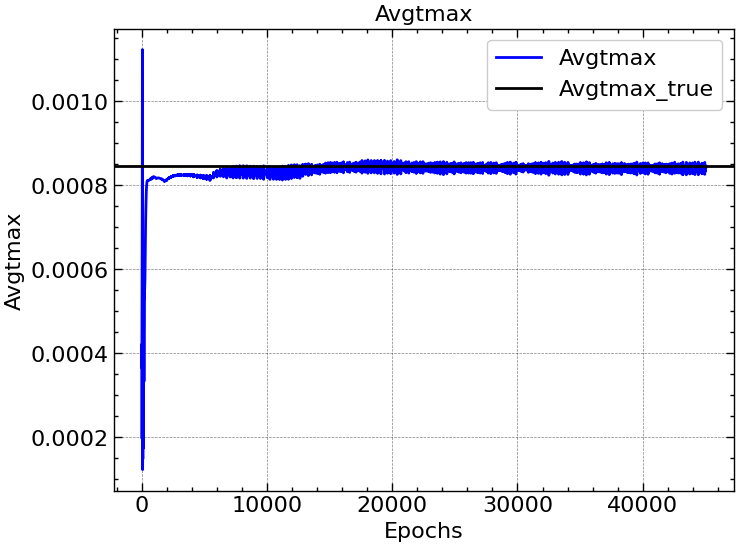

In [135]:
plt.plot(Avgtmax_values, label = "Avgtmax", color = 'blue')
plt.axhline(Avgtmax_true, color='black', label='Avgtmax_true')
plt.ylabel("Avgtmax")
plt.xlabel("Epochs")
plt.title("Avgtmax")
plt.legend()

#### $A_{egrmax}$

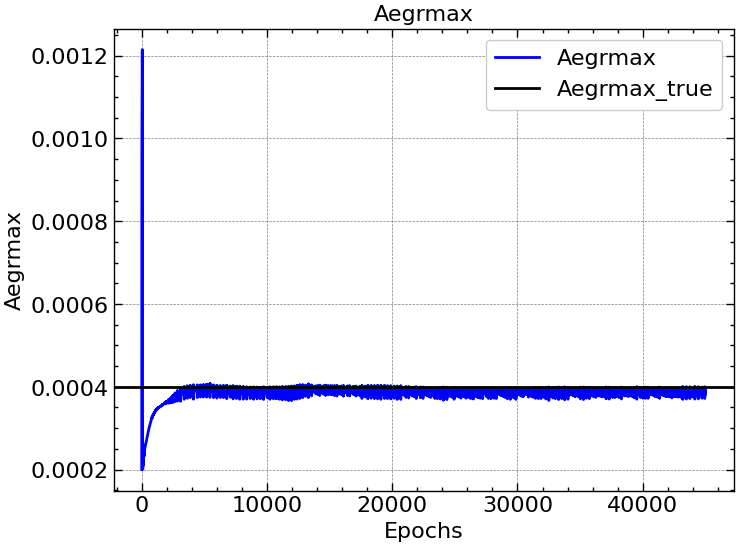

In [136]:
plt.plot(Aegrmax_values, label = "Aegrmax", color = 'blue')
plt.axhline(Aegrmax_true, color='black', label='Aegrmax_true')
plt.ylabel("Aegrmax")
plt.xlabel("Epochs")
plt.title("Aegrmax")
plt.legend()

#### $h_{sc}$

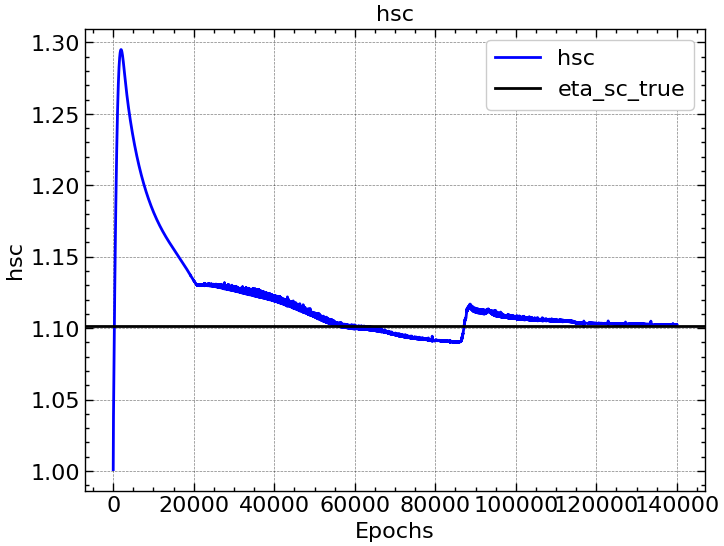

In [137]:
plt.plot(hsc_values, label = "hsc", color = 'blue')
plt.axhline(eta_sc_true, color='black', label='eta_sc_true')
plt.ylabel("hsc")
plt.xlabel("Epochs")
plt.title("hsc")
plt.legend()

#### $h_{tot}$

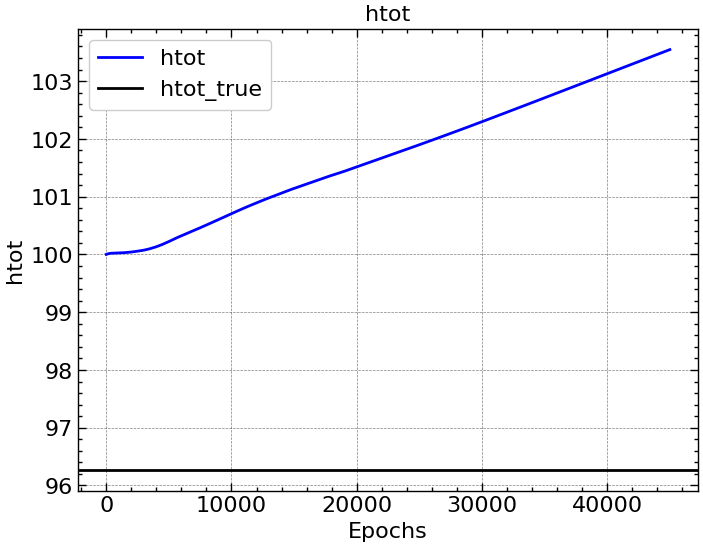

In [138]:
plt.plot(htot_values, label = "htot", color = 'blue')
plt.axhline(htot_true, label = "htot_true", color = 'black')
plt.ylabel("htot")
plt.xlabel("Epochs")
plt.title("htot")
plt.legend()

### Metrics

## Losses

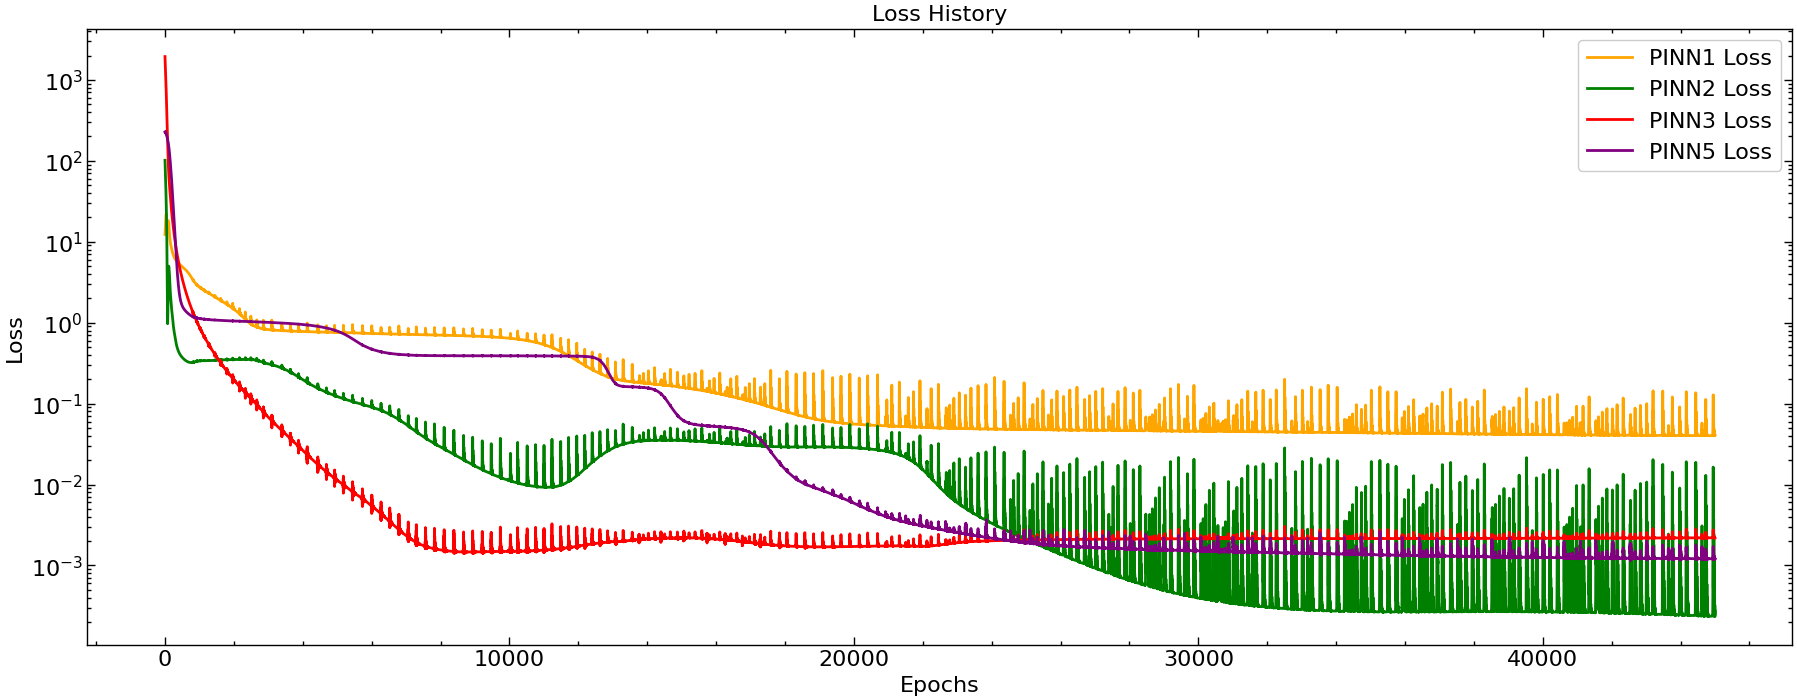

In [139]:
# Plotting the loss history
plt.figure(figsize=(22, 8))

plt.plot(Loss_history_PINN1, label='PINN1 Loss', color='orange')
plt.plot(Loss_history_PINN2, label='PINN2 Loss', color='green')
plt.plot(Loss_history_PINN3, label='PINN3 Loss', color='red')
plt.plot(Loss_history_PINN5, label='PINN5 Loss', color='purple')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()
plt.grid()
plt.show()

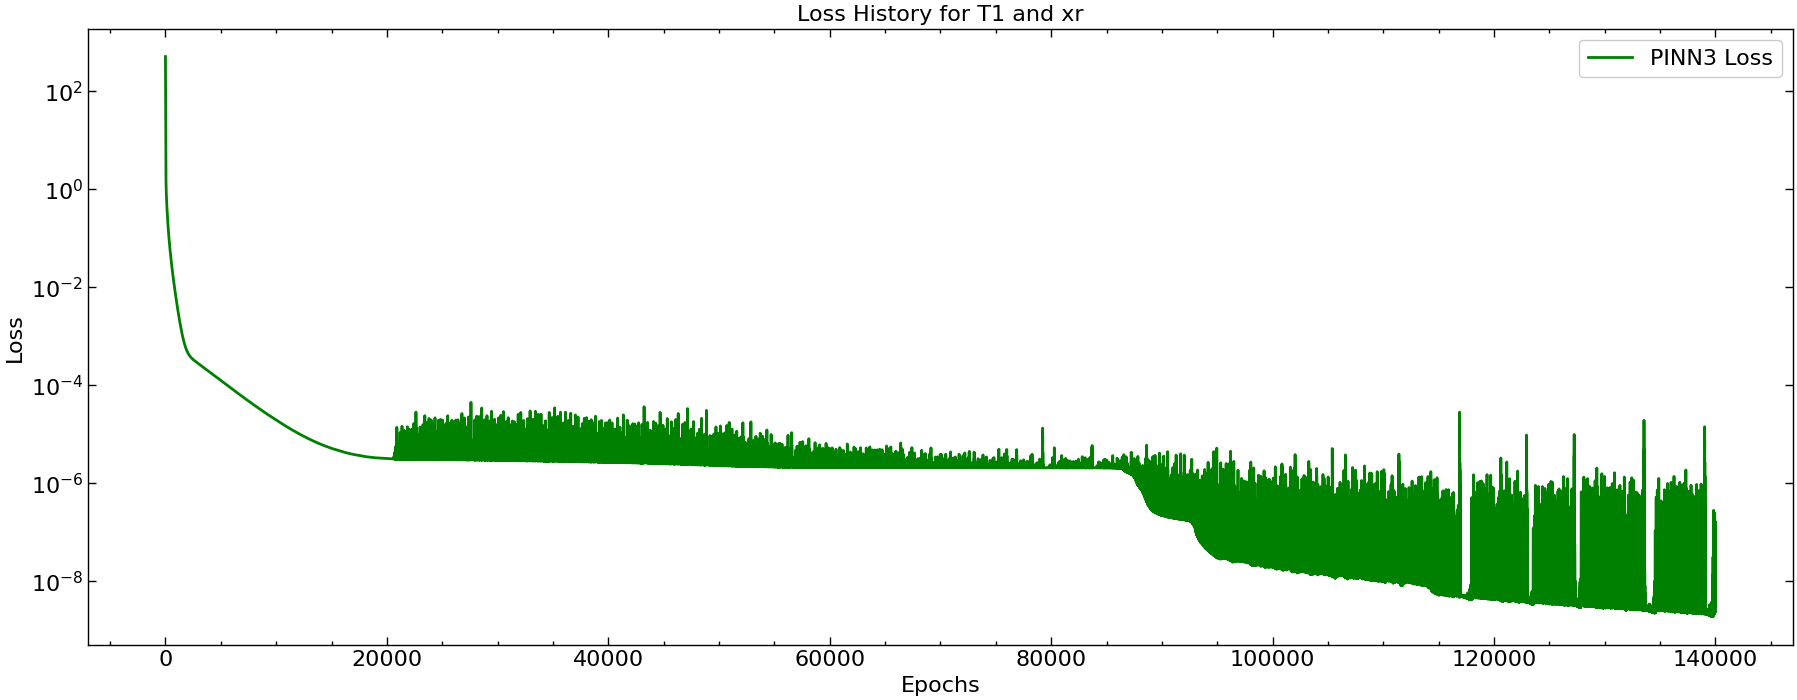

In [140]:
# Plotting loss history for T1 
plt.figure(figsize=(22, 8))

plt.plot(Loss_history_PINN3_new, label='PINN3 Loss', color='green')
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History for T1 and xr')
plt.legend()
plt.grid()
plt.show()

## Accuracy

### Metrics for state variables

In [141]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# L2 relative error metric
def l2_relative_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.linalg.norm(y_true - y_pred, ord=2)
    denominator = np.linalg.norm(y_true, ord=2)
    return numerator / denominator if denominator != 0 else float('inf')

#### Training Data

In [142]:
# Converting predictions to 1D numpy arrays
pim_pred_physics_np = pim_pred_physics.detach().numpy().flatten()
pem_pred_physics_np = pem_pred_physics.detach().numpy().flatten()
omeggat_pred_physics_np = omeggat_pred_physics.detach().numpy().flatten()
u_egr1_pred_physics_np = u_egr1_pred_physics.detach().numpy().flatten()
u_egr2_pred_physics_np = u_egr2_pred_physics.detach().numpy().flatten()
u_vgt_pred_physics_np = u_vgt_pred_physics.detach().numpy().flatten()
T1_pred_physics_np = T1_pred_physics.detach().numpy().flatten()
xr_pred_physics_np = xr_pred_physics.detach().numpy().flatten()

In [143]:
# Calculating the metrics for each variable
metrics = {
    'pim': {
        'L2_relative_error': l2_relative_error(pim_data_train, pim_pred_physics_np),
        'MSE': mean_squared_error(pim_data_train, pim_pred_physics_np),
        'MAE': mean_absolute_error(pim_data_train, pim_pred_physics_np),
        'R2': r2_score(pim_data_train, pim_pred_physics_np)
    },
    'pem': {
        'L2_relative_error': l2_relative_error(pem_data_train, pem_pred_physics_np),
        'MSE': mean_squared_error(pem_data_train, pem_pred_physics_np),
        'MAE': mean_absolute_error(pem_data_train, pem_pred_physics_np),
        'R2': r2_score(pem_data_train, pem_pred_physics_np)
    },
    'omeggat': {
        'L2_relative_error': l2_relative_error(omegat_data_train, omeggat_pred_physics_np),
        'MSE': mean_squared_error(omegat_data_train, omeggat_pred_physics_np),
        'MAE': mean_absolute_error(omegat_data_train, omeggat_pred_physics_np),
        'R2': r2_score(omegat_data_train, omeggat_pred_physics_np)
    },
    'u_egr1': {
        'L2_relative_error': l2_relative_error(u_egr1_data_train, u_egr1_pred_physics_np),
        'MSE': mean_squared_error(u_egr1_data_train, u_egr1_pred_physics_np),
        'MAE': mean_absolute_error(u_egr1_data_train, u_egr1_pred_physics_np),
        'R2': r2_score(u_egr1_data_train, u_egr1_pred_physics_np)
    },
    'u_egr2': {
        'L2_relative_error': l2_relative_error(u_egr2_data_train, u_egr2_pred_physics_np),
        'MSE': mean_squared_error(u_egr2_data_train, u_egr2_pred_physics_np),
        'MAE': mean_absolute_error(u_egr2_data_train, u_egr2_pred_physics_np),
        'R2': r2_score(u_egr2_data_train, u_egr2_pred_physics_np)
    },
    'u_vgt': {
        'L2_relative_error': l2_relative_error(u_vgt_data_train, u_vgt_pred_physics_np),
        'MSE': mean_squared_error(u_vgt_data_train, u_vgt_pred_physics_np),
        'MAE': mean_absolute_error(u_vgt_data_train, u_vgt_pred_physics_np),
        'R2': r2_score(u_vgt_data_train, u_vgt_pred_physics_np)
    },
    'T1': {
        'L2_relative_error': l2_relative_error(T1_data_train, T1_pred_physics_np),
        'MSE': mean_squared_error(T1_data_train, T1_pred_physics_np),
        'MAE': mean_absolute_error(T1_data_train, T1_pred_physics_np),
        'R2': r2_score(T1_data_train, T1_pred_physics_np)
    },
    'xr': {
        'L2_relative_error': l2_relative_error(xr_data_train, xr_pred_physics_np),
        'MSE': mean_squared_error(xr_data_train, xr_pred_physics_np),
        'MAE': mean_absolute_error(xr_data_train, xr_pred_physics_np),
        'R2': r2_score(xr_data_train, xr_pred_physics_np)
    }
}
# Displaying the metrics
for variable, metric_values in metrics.items():
    print(f"Metrics for {variable}:")
    for metric, value in metric_values.items():
        print(f"  {metric}: {value:.4e}")
    print()

Metrics for pim:
  L2_relative_error: 2.8486e-03
  MSE: 2.1950e+05
  MAE: 3.7225e+02
  R2: 9.9883e-01

Metrics for pem:
  L2_relative_error: 2.4833e-03
  MSE: 1.9049e+05
  MAE: 3.3054e+02
  R2: 9.9939e-01

Metrics for omeggat:
  L2_relative_error: 1.0222e-03
  MSE: 4.9605e+01
  MAE: 3.8814e+00
  R2: 9.9968e-01

Metrics for u_egr1:
  L2_relative_error: 1.9943e+00
  MSE: 7.8823e+01
  MAE: 5.8896e+00
  R2: 7.5849e-01

Metrics for u_egr2:
  L2_relative_error: 1.9917e+00
  MSE: 1.0417e+02
  MAE: 6.8997e+00
  R2: 6.8015e-01

Metrics for u_vgt:
  L2_relative_error: 1.1467e+00
  MSE: 2.1336e+00
  MAE: 4.0766e-01
  R2: 9.8260e-01

Metrics for T1:
  L2_relative_error: 2.5173e-04
  MSE: 6.2456e-03
  MAE: 5.6191e-02
  R2: 9.6027e-01

Metrics for xr:
  L2_relative_error: 4.1845e-03
  MSE: 1.3532e-08
  MAE: 9.8035e-05
  R2: 9.9561e-01



#### Testing Data

In [144]:
# Converting predictions to 1D numpy arrays
pim_pred_test_np = pim_pred_test.detach().numpy().flatten()
pem_pred_test_np = pem_pred_test.detach().numpy().flatten()
omeggat_pred_test_np = omeggat_pred_test.detach().numpy().flatten()
u_egr1_pred_test_np = u_egr1_pred_test.detach().numpy().flatten()
u_egr2_pred_test_np = u_egr2_pred_test.detach().numpy().flatten()
u_vgt_pred_test_np = u_vgt_pred_test.detach().numpy().flatten()
T1_pred_test_np = T1_pred_test.detach().numpy().flatten()
xr_pred_test_np = xr_pred_test.detach().numpy().flatten()


In [145]:
# Calculating metrics for each variable on test data
metrics_test = {
    'pim': {
        'L2_relative_error': l2_relative_error(pim_data_test, pim_pred_test_np),
        'MSE': mean_squared_error(pim_data_test, pim_pred_test_np),
        'MAE': mean_absolute_error(pim_data_test, pim_pred_test_np),
        'R2': r2_score(pim_data_test, pim_pred_test_np)
    },
    'pem': {
        'L2_relative_error': l2_relative_error(pem_data_test, pem_pred_test_np),
        'MSE': mean_squared_error(pem_data_test, pem_pred_test_np),
        'MAE': mean_absolute_error(pem_data_test, pem_pred_test_np),
        'R2': r2_score(pem_data_test, pem_pred_test_np)
    },
    'omeggat': {
        'L2_relative_error': l2_relative_error(omegat_data_test, omeggat_pred_test_np),
        'MSE': mean_squared_error(omegat_data_test, omeggat_pred_test_np),
        'MAE': mean_absolute_error(omegat_data_test, omeggat_pred_test_np),
        'R2': r2_score(omegat_data_test, omeggat_pred_test_np)
    },
    'u_egr1': {
        'L2_relative_error': l2_relative_error(u_egr1_data_test, u_egr1_pred_test_np),
        'MSE': mean_squared_error(u_egr1_data_test, u_egr1_pred_test_np),
        'MAE': mean_absolute_error(u_egr1_data_test, u_egr1_pred_test_np),
        'R2': r2_score(u_egr1_data_test, u_egr1_pred_test_np)
    },
    'u_egr2': {
        'L2_relative_error': l2_relative_error(u_egr2_data_test, u_egr2_pred_test_np),
        'MSE': mean_squared_error(u_egr2_data_test, u_egr2_pred_test_np),
        'MAE': mean_absolute_error(u_egr2_data_test, u_egr2_pred_test_np),
        'R2': r2_score(u_egr2_data_test, u_egr2_pred_test_np)
    },
    'u_vgt': {
        'L2_relative_error': l2_relative_error(u_vgt_data_test, u_vgt_pred_test_np),
        'MSE': mean_squared_error(u_vgt_data_test, u_vgt_pred_test_np),
        'MAE': mean_absolute_error(u_vgt_data_test, u_vgt_pred_test_np),
        'R2': r2_score(u_vgt_data_test, u_vgt_pred_test_np)
    },
    'T1': {
        'L2_relative_error': l2_relative_error(T1_data_test, T1_pred_test_np),
        'MSE': mean_squared_error(T1_data_test, T1_pred_test_np),
        'MAE': mean_absolute_error(T1_data_test, T1_pred_test_np),
        'R2': r2_score(T1_data_test, T1_pred_test_np)
    },
    'xr': {
        'L2_relative_error': l2_relative_error(xr_data_test, xr_pred_test_np),
        'MSE': mean_squared_error(xr_data_test, xr_pred_test_np),
        'MAE': mean_absolute_error(xr_data_test, xr_pred_test_np),
        'R2': r2_score(xr_data_test, xr_pred_test_np)
    }
}

In [146]:
# Displaying the metrics for test data
for variable, metric_values in metrics_test.items():
    print(f"Metrics for {variable} on test data:")
    for metric, value in metric_values.items():
        print(f"  {metric}: {value:.4e}")
    print()

Metrics for pim on test data:
  L2_relative_error: 3.0168e-03
  MSE: 2.4837e+05
  MAE: 4.1600e+02
  R2: 9.9422e-01

Metrics for pem on test data:
  L2_relative_error: 4.6313e-03
  MSE: 6.4138e+05
  MAE: 5.7187e+02
  R2: 9.9228e-01

Metrics for omeggat on test data:
  L2_relative_error: 1.1257e-03
  MSE: 6.4764e+01
  MAE: 5.7675e+00
  R2: 9.9837e-01

Metrics for u_egr1 on test data:
  L2_relative_error: 2.1117e-01
  MSE: 7.3894e+01
  MAE: 6.7004e+00
  R2: -5.1406e-01

Metrics for u_egr2 on test data:
  L2_relative_error: 2.4821e-01
  MSE: 1.0391e+02
  MAE: 7.8897e+00
  R2: -1.1951e+00

Metrics for u_vgt on test data:
  L2_relative_error: 1.4552e-02
  MSE: 7.6361e-01
  MAE: 6.5586e-01
  R2: 9.8898e-01

Metrics for T1 on test data:
  L2_relative_error: 2.8199e-04
  MSE: 7.8206e-03
  MAE: 7.1377e-02
  R2: 8.3244e-01

Metrics for xr on test data:
  L2_relative_error: 3.3050e-03
  MSE: 8.2779e-09
  MAE: 7.2310e-05
  R2: 9.8855e-01



#### Evaluation Data

In [147]:
# Predictions on evaluation data
t_evaluation_full = df_evaluation['Time'].to_numpy()
t_evaluation_full_scaled = scale_time(t_evaluation_full)
t_evaluation_full_scaled_tensor = torch.tensor(t_evaluation_full_scaled, dtype=torch.float32).view(-1, 1)

pinn1.eval()
p_pred_evaluation = pinn1(t_evaluation_full_scaled_tensor)
pim_pred_evaluation = p_pred_evaluation[:,0].view(-1,1)
pem_pred_evaluation = p_pred_evaluation[:,1].view(-1,1)

pinn5.eval()
omeggat_pred_evaluation = pinn5(t_eval_scaled_tensor).view(-1,1)

pinn4.eval()
u_egr_data_evaluation_pred = pinn4(t_eval_scaled_tensor)
u_egr1_pred_eval = u_egr_data_evaluation_pred[:,0].view(-1,1)
u_egr2_pred_eval = u_egr_data_evaluation_pred[:,1].view(-1,1)

pinn6.eval()
u_vgt_pred_evaluation = pinn6(t_eval_scaled_tensor).view(-1,1)

pinn2.eval()
xr_pred_evaluation = pinn2(t_evaluation_full_scaled_tensor).view(-1,1)

pinn3.eval()
T1_pred_evaluation = pinn3(t_evaluation_full_scaled_tensor).view(-1,1)



In [148]:
# Calculating metrics for evaluation data
metrics_evaluation = {
    'pim': {
        'L2_relative_error': l2_relative_error(df_evaluation['pim'].to_numpy(), pim_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(df_evaluation['pim'].to_numpy(), pim_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(df_evaluation['pim'].to_numpy(), pim_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(df_evaluation['pim'].to_numpy(), pim_pred_evaluation.detach().numpy().flatten())
    },
    'pem': {
        'L2_relative_error': l2_relative_error(df_evaluation['pem'].to_numpy(), pem_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(df_evaluation['pem'].to_numpy(), pem_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(df_evaluation['pem'].to_numpy(), pem_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(df_evaluation['pem'].to_numpy(), pem_pred_evaluation.detach().numpy().flatten())
    },
    'omeggat': {
        'L2_relative_error': l2_relative_error(omegat_data_eval, omegat_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(omegat_data_eval, omegat_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(omegat_data_eval, omegat_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(omegat_data_eval, omegat_pred_evaluation.detach().numpy().flatten())
    },
    'u_egr1': {
        'L2_relative_error': l2_relative_error(u_egr1_data_eval, u_egr1_pred_eval.detach().numpy().flatten()),
        'MSE': mean_squared_error(u_egr1_data_eval, u_egr1_pred_eval.detach().numpy().flatten()),
        'MAE': mean_absolute_error(u_egr1_data_eval, u_egr1_pred_eval.detach().numpy().flatten()),
        'R2': r2_score(u_egr1_data_eval, u_egr1_pred_eval.detach().numpy().flatten())
    },
    'u_egr2': {
        'L2_relative_error': l2_relative_error(u_egr2_data_eval, u_egr2_pred_eval.detach().numpy().flatten()),
        'MSE': mean_squared_error(u_egr2_data_eval, u_egr2_pred_eval.detach().numpy().flatten()),
        'MAE': mean_absolute_error(u_egr2_data_eval, u_egr2_pred_eval.detach().numpy().flatten()),
        'R2': r2_score(u_egr2_data_eval, u_egr2_pred_eval.detach().numpy().flatten())
    },
    'u_vgt': {
        'L2_relative_error': l2_relative_error(u_vgt_data_eval, u_vgt_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(u_vgt_data_eval, u_vgt_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(u_vgt_data_eval, u_vgt_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(u_vgt_data_eval, u_vgt_pred_evaluation.detach().numpy().flatten())
    },
    'T1': {
        'L2_relative_error': l2_relative_error(df_evaluation['T1'].to_numpy(), T1_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(df_evaluation['T1'].to_numpy(), T1_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(df_evaluation['T1'].to_numpy(), T1_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(df_evaluation['T1'].to_numpy(), T1_pred_evaluation.detach().numpy().flatten())
    },
    'xr': {
        'L2_relative_error': l2_relative_error(df_evaluation['xr'].to_numpy(), xr_pred_evaluation.detach().numpy().flatten()),
        'MSE': mean_squared_error(df_evaluation['xr'].to_numpy(), xr_pred_evaluation.detach().numpy().flatten()),
        'MAE': mean_absolute_error(df_evaluation['xr'].to_numpy(), xr_pred_evaluation.detach().numpy().flatten()),
        'R2': r2_score(df_evaluation['xr'].to_numpy(), xr_pred_evaluation.detach().numpy().flatten())
    }
}


In [149]:
# Displaying the metrics for evaluation data
for variable, metric_values in metrics_evaluation.items():
    print(f"Metrics for {variable} on evaluation data:")
    for metric, value in metric_values.items():
        print(f"  {metric}: {value:.4e}")
    print()

Metrics for pim on evaluation data:
  L2_relative_error: 1.9824e-02
  MSE: 1.0852e+07
  MAE: 8.2211e+02
  R2: 8.3278e-01

Metrics for pem on evaluation data:
  L2_relative_error: 2.5613e-02
  MSE: 2.0718e+07
  MAE: 1.1492e+03
  R2: 8.5437e-01

Metrics for omeggat on evaluation data:
  L2_relative_error: 1.3241e-03
  MSE: 8.4151e+01
  MAE: 6.6941e+00
  R2: 9.9905e-01

Metrics for u_egr1 on evaluation data:
  L2_relative_error: 1.7554e-01
  MSE: 8.0842e+01
  MAE: 6.0526e+00
  R2: 7.3246e-01

Metrics for u_egr2 on evaluation data:
  L2_relative_error: 2.0276e-01
  MSE: 1.0783e+02
  MAE: 7.2090e+00
  R2: 6.4130e-01

Metrics for u_vgt on evaluation data:
  L2_relative_error: 1.5000e-02
  MSE: 6.5386e-01
  MAE: 4.8557e-01
  R2: 9.9445e-01

Metrics for T1 on evaluation data:
  L2_relative_error: 3.6698e-04
  MSE: 1.3272e-02
  MAE: 8.0522e-02
  R2: 9.0941e-01

Metrics for xr on evaluation data:
  L2_relative_error: 8.0317e-03
  MSE: 5.0643e-08
  MAE: 1.2414e-04
  R2: 9.5919e-01



#### Table

In [150]:
# Defining consistent column widths
col_widths = [10, 12] + [12] * 8  # Dataset, Noise Level, then 8 variables

# Helper for line separator
line_sep = "|" + "|".join(["-" * (w + 2) for w in col_widths]) + "|"

# -------------------------------
# L2 error table
# -------------------------------
print(f"| {'Dataset':^{col_widths[0]}} | {'Noise Level':^{col_widths[1]}} | "
      f"{'pim':^{col_widths[2]}} | {'pem':^{col_widths[3]}} | {'omeggat':^{col_widths[4]}} | "
      f"{'u_egr1':^{col_widths[5]}} | {'u_egr2':^{col_widths[6]}} | {'u_vgt':^{col_widths[7]}} | "
      f"{'T1':^{col_widths[8]}} | {'xr':^{col_widths[9]}} |")
print(line_sep)
print(f"| {'L2 error':^{col_widths[0]}} | {'':^{col_widths[1]}} | "
      f"{'':^{col_widths[2]}} | {'':^{col_widths[3]}} | {'':^{col_widths[4]}} | "
      f"{'':^{col_widths[5]}} | {'':^{col_widths[6]}} | {'':^{col_widths[7]}} | "
      f"{'':^{col_widths[8]}} | {'':^{col_widths[9]}} |")

print(f"| {'Training':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics['pim']['L2_relative_error']:{col_widths[2]}.2e} | "
      f"{metrics['pem']['L2_relative_error']:{col_widths[3]}.2e} | "
      f"{metrics['omeggat']['L2_relative_error']:{col_widths[4]}.2e} | "
      f"{metrics['u_egr1']['L2_relative_error']:{col_widths[5]}.2e} | "
      f"{metrics['u_egr2']['L2_relative_error']:{col_widths[6]}.2e} | "
      f"{metrics['u_vgt']['L2_relative_error']:{col_widths[7]}.2e} | "
      f"{metrics['T1']['L2_relative_error']:{col_widths[8]}.2e} | "
      f"{metrics['xr']['L2_relative_error']:{col_widths[9]}.2e} |")

print(f"| {'Testing':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics['pim']['L2_relative_error']:{col_widths[2]}.2e} | "
      f"{metrics['pem']['L2_relative_error']:{col_widths[3]}.2e} | "
      f"{metrics['omeggat']['L2_relative_error']:{col_widths[4]}.2e} | "
      f"{metrics['u_egr1']['L2_relative_error']:{col_widths[5]}.2e} | "
      f"{metrics['u_egr2']['L2_relative_error']:{col_widths[6]}.2e} | "
      f"{metrics['u_vgt']['L2_relative_error']:{col_widths[7]}.2e} | "
      f"{metrics['T1']['L2_relative_error']:{col_widths[8]}.2e} | "
      f"{metrics['xr']['L2_relative_error']:{col_widths[9]}.2e} |")

print(f"| {'Evaluation':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics_evaluation['pim']['L2_relative_error']:{col_widths[2]}.2e} | "
      f"{metrics_evaluation['pem']['L2_relative_error']:{col_widths[3]}.2e} | "
      f"{metrics_evaluation['omeggat']['L2_relative_error']:{col_widths[4]}.2e} | "
      f"{metrics_evaluation['u_egr1']['L2_relative_error']:{col_widths[5]}.2e} | "
      f"{metrics_evaluation['u_egr2']['L2_relative_error']:{col_widths[6]}.2e} | "
      f"{metrics_evaluation['u_vgt']['L2_relative_error']:{col_widths[7]}.2e} | "
      f"{metrics_evaluation['T1']['L2_relative_error']:{col_widths[8]}.2e} | "
      f"{metrics_evaluation['xr']['L2_relative_error']:{col_widths[9]}.2e} |")
print(line_sep)

print()

# -------------------------------
# R2 table
# -------------------------------
print(f"| {'Dataset':^{col_widths[0]}} | {'Noise Level':^{col_widths[1]}} | "
      f"{'pim':^{col_widths[2]}} | {'pem':^{col_widths[3]}} | {'omeggat':^{col_widths[4]}} | "
      f"{'u_egr1':^{col_widths[5]}} | {'u_egr2':^{col_widths[6]}} | {'u_vgt':^{col_widths[7]}} | "
      f"{'T1':^{col_widths[8]}} | {'xr':^{col_widths[9]}} |")
print(line_sep)
print(f"| {'R2 score':^{col_widths[0]}} | {'':^{col_widths[1]}} | "
      f"{'':^{col_widths[2]}} | {'':^{col_widths[3]}} | {'':^{col_widths[4]}} | "
      f"{'':^{col_widths[5]}} | {'':^{col_widths[6]}} | {'':^{col_widths[7]}} | "
      f"{'':^{col_widths[8]}} | {'':^{col_widths[9]}} |")

print(f"| {'Training':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics['pim']['R2']:{col_widths[2]}.2e} | "
      f"{metrics['pem']['R2']:{col_widths[3]}.2e} | "
      f"{metrics['omeggat']['R2']:{col_widths[4]}.2e} | "
      f"{metrics['u_egr1']['R2']:{col_widths[5]}.2e} | "
      f"{metrics['u_egr2']['R2']:{col_widths[6]}.2e} | "
      f"{metrics['u_vgt']['R2']:{col_widths[7]}.2e} | "
      f"{metrics['T1']['R2']:{col_widths[8]}.2e} | "
      f"{metrics['xr']['R2']:{col_widths[9]}.2e} |")

print(f"| {'Testing':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics['pim']['R2']:{col_widths[2]}.2e} | "
      f"{metrics['pem']['R2']:{col_widths[3]}.2e} | "
      f"{metrics['omeggat']['R2']:{col_widths[4]}.2e} | "
      f"{metrics['u_egr1']['R2']:{col_widths[5]}.2e} | "
      f"{metrics['u_egr2']['R2']:{col_widths[6]}.2e} | "
      f"{metrics['u_vgt']['R2']:{col_widths[7]}.2e} | "
      f"{metrics['T1']['R2']:{col_widths[8]}.2e} | "
      f"{metrics['xr']['R2']:{col_widths[9]}.2e} |")

print(f"| {'Evaluation':^{col_widths[0]}} | {'0.0%':^{col_widths[1]}} | "
      f"{metrics_evaluation['pim']['R2']:{col_widths[2]}.2e} | "
      f"{metrics_evaluation['pem']['R2']:{col_widths[3]}.2e} | "
      f"{metrics_evaluation['omeggat']['R2']:{col_widths[4]}.2e} | "
      f"{metrics_evaluation['u_egr1']['R2']:{col_widths[5]}.2e} | "
      f"{metrics_evaluation['u_egr2']['R2']:{col_widths[6]}.2e} | "
      f"{metrics_evaluation['u_vgt']['R2']:{col_widths[7]}.2e} | "
      f"{metrics_evaluation['T1']['R2']:{col_widths[8]}.2e} | "
      f"{metrics_evaluation['xr']['R2']:{col_widths[9]}.2e} |")
print(line_sep)







|  Dataset   | Noise Level  |     pim      |     pem      |   omeggat    |    u_egr1    |    u_egr2    |    u_vgt     |      T1      |      xr      |
|------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|--------------|
|  L2 error  |              |              |              |              |              |              |              |              |              |
|  Training  |     0.0%     |     2.85e-03 |     2.48e-03 |     1.02e-03 |     1.99e+00 |     1.99e+00 |     1.15e+00 |     2.52e-04 |     4.18e-03 |
|  Testing   |     0.0%     |     2.85e-03 |     2.48e-03 |     1.02e-03 |     1.99e+00 |     1.99e+00 |     1.15e+00 |     2.52e-04 |     4.18e-03 |
| Evaluation |     0.0%     |     1.98e-02 |     2.56e-02 |     1.32e-03 |     1.76e-01 |     2.03e-01 |     1.50e-02 |     3.67e-04 |     8.03e-03 |
|------------|--------------|--------------|--------------|--------------|--------------|-----------

# Saving Models

In [151]:
torch.save(pinn1.state_dict(), 'pinn1_model_sparse.pth')
torch.save(pinn2.state_dict(), 'pinn2_model_sparse.pth')
torch.save(pinn3.state_dict(), 'pinn3_model_sparse.pth')
torch.save(pinn4.state_dict(), 'pinn4_model_sparse.pth')
torch.save(pinn5.state_dict(), 'pinn5_model_sparse.pth')
torch.save(pinn6.state_dict(), 'pinn6_model_sparse.pth')